In [34]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

### Read Data

In [81]:
X_train = pd.read_csv("train_inputs.csv")
y_train = pd.read_csv("train_outputs.csv")

data_train = X_train.drop(['ID'], axis=1).copy()
data_train['Score'] = y_train.Score

X_test = pd.read_csv("test_inputs.csv")

In [9]:
print("Size of Train data: {}".format(data_train.shape))
print("Size of Test data : {}".format(X_test.shape))

data_train.head()

Size of Train data: (8000, 8)
Size of Test data : (2000, 7)


,ID,Date,Temperature,Humidity,Humex,CO2,Bright,Score
0,0,2017-08-31 23:30:00,22.7,56.0,25.7,534.0,1.0,4.0
1,1,2017-09-01 00:30:00,22.8,55.0,25.7,506.0,1.0,4.0
2,2,2017-09-01 01:30:00,22.9,55.0,25.9,577.0,1.0,4.0
3,3,2017-09-01 02:30:00,23.0,55.0,26.1,630.0,1.0,2.0
4,4,2017-09-01 03:30:00,23.0,55.0,26.1,643.0,1.0,3.0


## Data Discovery

### Classes distribution

In [ ]:
#  dictionary label: classes names
#sleeping_labels = {0: "Awake",
#                   1: "N1 - light sleep 1",
#                   2: "N2 - light sleep 2",
#                   3: "N3 - Deep sleep",
#                   4: "REM - paradoxical sleep"
#                   }
#print("Sleeping labels:", sleeping_labels)

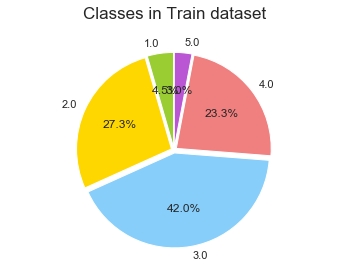

In [35]:
# Distribution
classes_labels, classes_frequencies = np.unique(data_train.Score, return_counts=True)

#labels_names = np.array([sleeping_labels[label] for label in train_labels])

colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral', "mediumorchid"]
explode = (0.03, 0.03, 0.03, 0.03, 0.03)
plt.pie(counter_train, labels=classes_labels, colors=colors, explode=explode,
        autopct='%1.1f%%', startangle=90)   # shadow=True

plt.axis('equal')
plt.title("Classes in Train dataset\n", fontsize=17)
plt.show()

### Boxplots

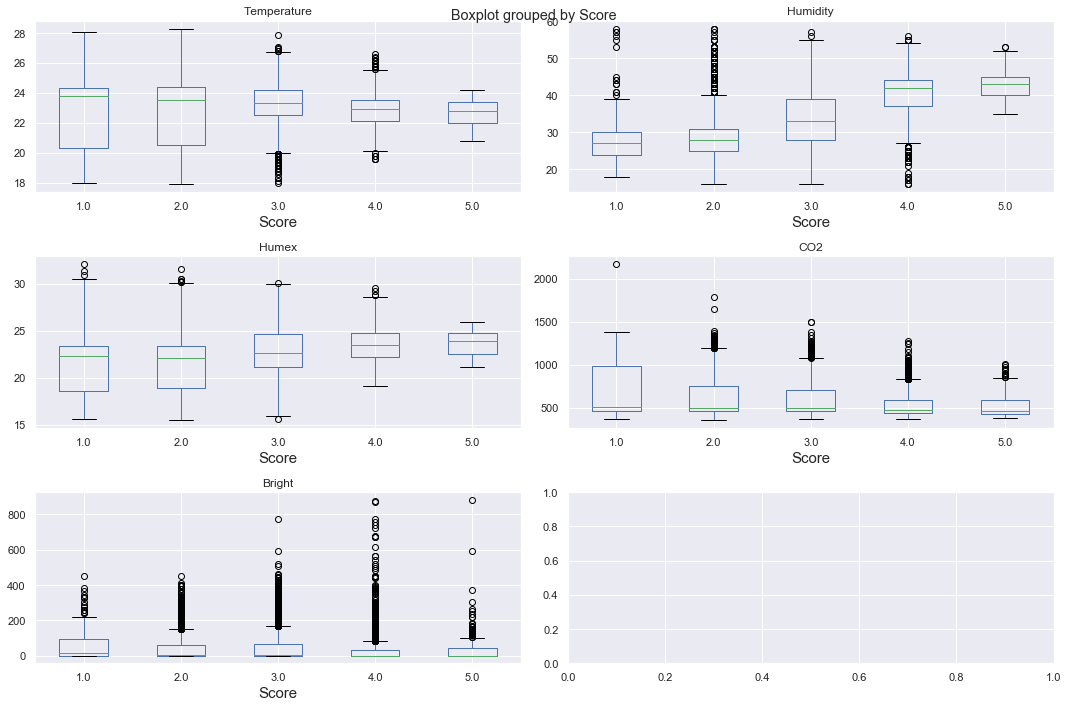

In [82]:
box_plot_columns = data_train.drop(['Score', 'Date'], axis=1).columns
    
fig, axes = plt.subplots(3,2, figsize=(15,10)) # create figure and axes
fig.suptitle("Boxplots grouped by Class")

for i, col in enumerate(box_plot_columns):
    boxplot = data_train.boxplot(column=col, by=['Score'], figsize=(15,10), 
                                 grid=True, showfliers=True, ax=axes.flatten()[i])
    boxplot.set_xlabel('Score', fontsize=15)
    
#fig.delaxes(axes[1,1]) # remove empty subplot
plt.tight_layout() 
plt.show()
# Same plot same axis
#boxplots = data_train_features.boxplot(by=['Score'], figsize=(15,10), grid=True, showfliers=False)

### Null Values and Cardinatily

In [83]:
continuous_columns = [col for col in data_train.columns if data_train[col].dtype == 'float64']
categorical_features_int = [col for col in data_train.columns if data_train[col].dtype == 'int64']
categorical_features_object = [col for col in data_train.columns if data_train[col].dtype == 'object']

columns = data_train.columns
types = data_train.dtypes.values
cardinality = data_train.nunique().values
nulls = (data_train.isnull().sum() / len(data_train)).values * 100

pd.DataFrame({'Feat': columns, 'Nulls (%)': nulls, 
              'Type': types, 'Cardinality': cardinality}).set_index('Feat').sort_values(by='Cardinality')

,Nulls (%),Type,Cardinality
Feat,,,
Score,0.0,float64,5
Humidity,0.0,float64,43
Temperature,0.0,float64,101
Humex,0.0,float64,154
Bright,0.0,float64,389
CO2,0.0,float64,871
Date,0.0,object,8000


### Date preprocessing

In [84]:
def preprocess_time(df, col_time='selection time'):
    temp_df = df.copy()
    
    temp_df[col_time] = pd.to_datetime(temp_df[col_time])
    temp_df['weekday'] = temp_df[col_time].dt.weekday
    temp_df['weekend'] = temp_df['weekday'] // 5
    temp_df['month'] = temp_df[col_time].dt.month
    temp_df['hour'] = temp_df[col_time].dt.hour
    temp_df['week'] = temp_df[col_time].dt.week
    
    return temp_df.drop([col_time], axis=1)

In [85]:
data_train_1 = preprocess_time(data_train, col_time='Date')

In [86]:
data_train_1.head()

,Temperature,Humidity,Humex,CO2,Bright,Score,weekday,weekend,month,hour,week
0,22.7,56.0,25.7,534.0,1.0,4.0,3,0,8,23,35
1,22.8,55.0,25.7,506.0,1.0,4.0,4,0,9,0,35
2,22.9,55.0,25.9,577.0,1.0,4.0,4,0,9,1,35
3,23.0,55.0,26.1,630.0,1.0,2.0,4,0,9,2,35
4,23.0,55.0,26.1,643.0,1.0,3.0,4,0,9,3,35


## Stacking Model

In [110]:
# Preprocessing
from sklearn.model_selection import train_test_split

# Evaluation
from sklearn.metrics import accuracy_score

# Models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression

from sklearn.svm import SVC

from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

In [135]:
# Séparatation en trois jeux de données
X_train_1 = data_train_1.drop('Score', axis=1)
y_train_1 = y_train[['Score']]
X_tr, X_val, y_tr, y_val = train_test_split(X_train_1, y_train_1, test_size=0.4, random_state=2019)

#### Define models for stacking

In [158]:
# Generate multiple models by changing value of random state

models = []
for rand_state in range(20):
    models += [
            RandomForestClassifier(random_state=rand_state, n_jobs=-1), 
            LogisticRegression(random_state=rand_state, n_jobs=-1), 
            #SVC(),
            #KNeighborsClassifier(n_jobs=-1),
            XGBClassifier(random_state=rand_state, n_thread=-1), 
            LGBMClassifier(random_state=rand_state, n_jobs=-1), 
            CatBoostClassifier(random_state=rand_state)
              ]

#names = ['rfc', 'logreg', 'xgbc', 'lgbc', 'catc']
n_models = len(models)

In [149]:

models_regression = [
    RandomForestRegressor(n_jobs=-1), 
    LinearRegression(n_jobs=-1), 
    Ridge(), 
    KNeighborsRegressor(n_jobs=-1),
    XGBRegressor(n_thread=-1), 
    LGBMRegressor(n_jobs=-1), 
    CatBoostRegressor()]

names = ['rf','lr','ridge','knn','xgb','lgb','cat']
n_mod = len(names)

#### Stacking

In [160]:
# First predictions of Models
preds_val = np.zeros(shape=(len(X_val), n_models))

In [161]:
trained_models_step_1 = []

for i, model in enumerate(models):
    model.fit(X_tr, y_tr)
    trained_models_step_1.append(model)
    preds_val[:, i] = model.predict(X_val).ravel()


/Users/ddebbaghnour/Documents/Apache_Beam/beam_env_python3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/ddebbaghnour/Documents/Apache_Beam/beam_env_python3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.
/Users/ddebbaghnour/Documents/Apache_Beam/beam_env_python3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ddebbaghnour/Documents/Apache_Beam/beam_env_python3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was pas

0:	learn: 1.5690402	total: 42ms	remaining: 42s
1:	learn: 1.5332740	total: 83.2ms	remaining: 41.5s
2:	learn: 1.4999604	total: 122ms	remaining: 40.5s
3:	learn: 1.4697609	total: 169ms	remaining: 42.2s
4:	learn: 1.4400329	total: 213ms	remaining: 42.5s
5:	learn: 1.4152277	total: 254ms	remaining: 42.1s
6:	learn: 1.3904534	total: 285ms	remaining: 40.5s
7:	learn: 1.3680546	total: 320ms	remaining: 39.7s
8:	learn: 1.3445598	total: 354ms	remaining: 39s
9:	learn: 1.3228054	total: 387ms	remaining: 38.3s
10:	learn: 1.3039048	total: 425ms	remaining: 38.2s
11:	learn: 1.2856461	total: 484ms	remaining: 39.8s
12:	learn: 1.2673524	total: 554ms	remaining: 42s
13:	learn: 1.2502684	total: 622ms	remaining: 43.8s
14:	learn: 1.2334546	total: 677ms	remaining: 44.4s
15:	learn: 1.2174026	total: 728ms	remaining: 44.8s
16:	learn: 1.2039522	total: 772ms	remaining: 44.7s
17:	learn: 1.1886329	total: 813ms	remaining: 44.3s
18:	learn: 1.1750921	total: 850ms	remaining: 43.9s
19:	learn: 1.1631949	total: 891ms	remaining: 43

161:	learn: 0.8026708	total: 6.84s	remaining: 35.4s
162:	learn: 0.8022746	total: 6.87s	remaining: 35.3s
163:	learn: 0.8018547	total: 6.9s	remaining: 35.2s
164:	learn: 0.8014831	total: 6.93s	remaining: 35.1s
165:	learn: 0.8011530	total: 6.97s	remaining: 35s
166:	learn: 0.8009462	total: 7s	remaining: 34.9s
167:	learn: 0.8004738	total: 7.03s	remaining: 34.8s
168:	learn: 0.7997159	total: 7.07s	remaining: 34.8s
169:	learn: 0.7995069	total: 7.11s	remaining: 34.7s
170:	learn: 0.7992283	total: 7.15s	remaining: 34.6s
171:	learn: 0.7989245	total: 7.2s	remaining: 34.6s
172:	learn: 0.7980006	total: 7.25s	remaining: 34.7s
173:	learn: 0.7975326	total: 7.33s	remaining: 34.8s
174:	learn: 0.7970719	total: 7.38s	remaining: 34.8s
175:	learn: 0.7964879	total: 7.41s	remaining: 34.7s
176:	learn: 0.7961805	total: 7.44s	remaining: 34.6s
177:	learn: 0.7960700	total: 7.47s	remaining: 34.5s
178:	learn: 0.7954872	total: 7.51s	remaining: 34.4s
179:	learn: 0.7952572	total: 7.54s	remaining: 34.4s
180:	learn: 0.79445

326:	learn: 0.7514410	total: 12.5s	remaining: 25.7s
327:	learn: 0.7513360	total: 12.5s	remaining: 25.7s
328:	learn: 0.7511512	total: 12.6s	remaining: 25.6s
329:	learn: 0.7508867	total: 12.6s	remaining: 25.6s
330:	learn: 0.7507579	total: 12.6s	remaining: 25.5s
331:	learn: 0.7506036	total: 12.7s	remaining: 25.5s
332:	learn: 0.7504018	total: 12.7s	remaining: 25.4s
333:	learn: 0.7501148	total: 12.7s	remaining: 25.4s
334:	learn: 0.7498647	total: 12.8s	remaining: 25.3s
335:	learn: 0.7495191	total: 12.8s	remaining: 25.3s
336:	learn: 0.7489853	total: 12.8s	remaining: 25.2s
337:	learn: 0.7488956	total: 12.9s	remaining: 25.2s
338:	learn: 0.7486350	total: 12.9s	remaining: 25.1s
339:	learn: 0.7482423	total: 12.9s	remaining: 25.1s
340:	learn: 0.7478810	total: 13s	remaining: 25.1s
341:	learn: 0.7477415	total: 13s	remaining: 25s
342:	learn: 0.7475545	total: 13s	remaining: 25s
343:	learn: 0.7472246	total: 13.1s	remaining: 24.9s
344:	learn: 0.7469031	total: 13.1s	remaining: 24.9s
345:	learn: 0.7466368	

486:	learn: 0.7179755	total: 17.9s	remaining: 18.9s
487:	learn: 0.7179403	total: 18s	remaining: 18.9s
488:	learn: 0.7178397	total: 18s	remaining: 18.8s
489:	learn: 0.7176881	total: 18s	remaining: 18.8s
490:	learn: 0.7176039	total: 18.1s	remaining: 18.7s
491:	learn: 0.7175286	total: 18.1s	remaining: 18.7s
492:	learn: 0.7174659	total: 18.1s	remaining: 18.7s
493:	learn: 0.7171906	total: 18.2s	remaining: 18.6s
494:	learn: 0.7170896	total: 18.2s	remaining: 18.6s
495:	learn: 0.7169630	total: 18.2s	remaining: 18.5s
496:	learn: 0.7167941	total: 18.3s	remaining: 18.5s
497:	learn: 0.7167007	total: 18.3s	remaining: 18.5s
498:	learn: 0.7165909	total: 18.3s	remaining: 18.4s
499:	learn: 0.7164666	total: 18.4s	remaining: 18.4s
500:	learn: 0.7163259	total: 18.4s	remaining: 18.3s
501:	learn: 0.7159974	total: 18.4s	remaining: 18.3s
502:	learn: 0.7158398	total: 18.5s	remaining: 18.3s
503:	learn: 0.7155401	total: 18.5s	remaining: 18.2s
504:	learn: 0.7154963	total: 18.5s	remaining: 18.2s
505:	learn: 0.7151

647:	learn: 0.6953125	total: 25.3s	remaining: 13.8s
648:	learn: 0.6952075	total: 25.4s	remaining: 13.7s
649:	learn: 0.6950376	total: 25.5s	remaining: 13.7s
650:	learn: 0.6947683	total: 25.5s	remaining: 13.7s
651:	learn: 0.6947271	total: 25.6s	remaining: 13.7s
652:	learn: 0.6946193	total: 25.6s	remaining: 13.6s
653:	learn: 0.6944563	total: 25.7s	remaining: 13.6s
654:	learn: 0.6943729	total: 25.7s	remaining: 13.5s
655:	learn: 0.6942397	total: 25.7s	remaining: 13.5s
656:	learn: 0.6940770	total: 25.8s	remaining: 13.5s
657:	learn: 0.6939805	total: 25.8s	remaining: 13.4s
658:	learn: 0.6938433	total: 25.9s	remaining: 13.4s
659:	learn: 0.6937053	total: 25.9s	remaining: 13.3s
660:	learn: 0.6934749	total: 26s	remaining: 13.3s
661:	learn: 0.6934160	total: 26s	remaining: 13.3s
662:	learn: 0.6933039	total: 26.1s	remaining: 13.2s
663:	learn: 0.6930540	total: 26.1s	remaining: 13.2s
664:	learn: 0.6927970	total: 26.1s	remaining: 13.2s
665:	learn: 0.6926922	total: 26.2s	remaining: 13.1s
666:	learn: 0.69

809:	learn: 0.6777147	total: 32.5s	remaining: 7.63s
810:	learn: 0.6776163	total: 32.6s	remaining: 7.59s
811:	learn: 0.6774827	total: 32.6s	remaining: 7.54s
812:	learn: 0.6773262	total: 32.6s	remaining: 7.5s
813:	learn: 0.6772642	total: 32.6s	remaining: 7.46s
814:	learn: 0.6771743	total: 32.7s	remaining: 7.42s
815:	learn: 0.6769267	total: 32.7s	remaining: 7.38s
816:	learn: 0.6768285	total: 32.7s	remaining: 7.33s
817:	learn: 0.6766102	total: 32.8s	remaining: 7.29s
818:	learn: 0.6765958	total: 32.8s	remaining: 7.25s
819:	learn: 0.6765343	total: 32.8s	remaining: 7.21s
820:	learn: 0.6764178	total: 32.9s	remaining: 7.17s
821:	learn: 0.6763986	total: 32.9s	remaining: 7.13s
822:	learn: 0.6762784	total: 33s	remaining: 7.09s
823:	learn: 0.6761101	total: 33s	remaining: 7.05s
824:	learn: 0.6760662	total: 33s	remaining: 7s
825:	learn: 0.6757221	total: 33.1s	remaining: 6.96s
826:	learn: 0.6756899	total: 33.1s	remaining: 6.92s
827:	learn: 0.6756675	total: 33.1s	remaining: 6.88s
828:	learn: 0.6756138	

972:	learn: 0.6614911	total: 39s	remaining: 1.08s
973:	learn: 0.6613182	total: 39s	remaining: 1.04s
974:	learn: 0.6612449	total: 39.1s	remaining: 1s
975:	learn: 0.6611314	total: 39.1s	remaining: 961ms
976:	learn: 0.6610110	total: 39.1s	remaining: 921ms
977:	learn: 0.6609263	total: 39.2s	remaining: 881ms
978:	learn: 0.6607943	total: 39.2s	remaining: 841ms
979:	learn: 0.6607599	total: 39.2s	remaining: 801ms
980:	learn: 0.6607052	total: 39.3s	remaining: 761ms
981:	learn: 0.6605751	total: 39.3s	remaining: 721ms
982:	learn: 0.6604905	total: 39.4s	remaining: 681ms
983:	learn: 0.6604064	total: 39.5s	remaining: 641ms
984:	learn: 0.6603540	total: 39.5s	remaining: 602ms
985:	learn: 0.6603173	total: 39.6s	remaining: 562ms
986:	learn: 0.6601554	total: 39.6s	remaining: 522ms
987:	learn: 0.6600129	total: 39.7s	remaining: 482ms
988:	learn: 0.6598719	total: 39.7s	remaining: 442ms
989:	learn: 0.6598529	total: 39.8s	remaining: 402ms
990:	learn: 0.6597518	total: 39.9s	remaining: 362ms
991:	learn: 0.65963

/Users/ddebbaghnour/Documents/Apache_Beam/beam_env_python3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/ddebbaghnour/Documents/Apache_Beam/beam_env_python3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.
/Users/ddebbaghnour/Documents/Apache_Beam/beam_env_python3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ddebbaghnour/Documents/Apache_Beam/beam_env_python3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was pas

0:	learn: 1.5692895	total: 104ms	remaining: 1m 43s
1:	learn: 1.5344147	total: 228ms	remaining: 1m 53s
2:	learn: 1.5027306	total: 300ms	remaining: 1m 39s
3:	learn: 1.4745728	total: 368ms	remaining: 1m 31s
4:	learn: 1.4451526	total: 430ms	remaining: 1m 25s
5:	learn: 1.4208016	total: 488ms	remaining: 1m 20s
6:	learn: 1.3961624	total: 535ms	remaining: 1m 15s
7:	learn: 1.3715155	total: 583ms	remaining: 1m 12s
8:	learn: 1.3487758	total: 620ms	remaining: 1m 8s
9:	learn: 1.3252157	total: 654ms	remaining: 1m 4s
10:	learn: 1.3019849	total: 691ms	remaining: 1m 2s
11:	learn: 1.2846019	total: 726ms	remaining: 59.8s
12:	learn: 1.2643190	total: 791ms	remaining: 1m
13:	learn: 1.2464607	total: 834ms	remaining: 58.8s
14:	learn: 1.2321418	total: 872ms	remaining: 57.3s
15:	learn: 1.2176755	total: 918ms	remaining: 56.5s
16:	learn: 1.2051494	total: 967ms	remaining: 55.9s
17:	learn: 1.1888865	total: 1.01s	remaining: 54.9s
18:	learn: 1.1763079	total: 1.05s	remaining: 54.2s
19:	learn: 1.1625783	total: 1.08s	re

165:	learn: 0.7981535	total: 7.82s	remaining: 39.3s
166:	learn: 0.7979084	total: 7.89s	remaining: 39.4s
167:	learn: 0.7975814	total: 7.94s	remaining: 39.3s
168:	learn: 0.7971710	total: 7.98s	remaining: 39.2s
169:	learn: 0.7968925	total: 8.03s	remaining: 39.2s
170:	learn: 0.7966200	total: 8.08s	remaining: 39.2s
171:	learn: 0.7963530	total: 8.13s	remaining: 39.2s
172:	learn: 0.7958952	total: 8.18s	remaining: 39.1s
173:	learn: 0.7955232	total: 8.24s	remaining: 39.1s
174:	learn: 0.7953128	total: 8.3s	remaining: 39.1s
175:	learn: 0.7948760	total: 8.34s	remaining: 39s
176:	learn: 0.7945472	total: 8.38s	remaining: 39s
177:	learn: 0.7941957	total: 8.42s	remaining: 38.9s
178:	learn: 0.7939465	total: 8.47s	remaining: 38.8s
179:	learn: 0.7937794	total: 8.51s	remaining: 38.8s
180:	learn: 0.7934693	total: 8.54s	remaining: 38.7s
181:	learn: 0.7931783	total: 8.59s	remaining: 38.6s
182:	learn: 0.7926634	total: 8.64s	remaining: 38.6s
183:	learn: 0.7920084	total: 8.71s	remaining: 38.6s
184:	learn: 0.791

327:	learn: 0.7543350	total: 14.9s	remaining: 30.4s
328:	learn: 0.7540910	total: 14.9s	remaining: 30.4s
329:	learn: 0.7539290	total: 14.9s	remaining: 30.3s
330:	learn: 0.7537389	total: 15s	remaining: 30.2s
331:	learn: 0.7535836	total: 15s	remaining: 30.2s
332:	learn: 0.7532909	total: 15s	remaining: 30.1s
333:	learn: 0.7529743	total: 15.1s	remaining: 30.1s
334:	learn: 0.7525399	total: 15.1s	remaining: 30s
335:	learn: 0.7524609	total: 15.2s	remaining: 30s
336:	learn: 0.7522490	total: 15.2s	remaining: 29.9s
337:	learn: 0.7518538	total: 15.2s	remaining: 29.8s
338:	learn: 0.7514237	total: 15.3s	remaining: 29.7s
339:	learn: 0.7511726	total: 15.3s	remaining: 29.7s
340:	learn: 0.7507676	total: 15.3s	remaining: 29.6s
341:	learn: 0.7500685	total: 15.4s	remaining: 29.6s
342:	learn: 0.7498367	total: 15.4s	remaining: 29.5s
343:	learn: 0.7494622	total: 15.4s	remaining: 29.4s
344:	learn: 0.7493195	total: 15.5s	remaining: 29.3s
345:	learn: 0.7491017	total: 15.5s	remaining: 29.3s
346:	learn: 0.7490374	

486:	learn: 0.7226768	total: 20.9s	remaining: 22s
487:	learn: 0.7226359	total: 21s	remaining: 22s
488:	learn: 0.7225468	total: 21s	remaining: 22s
489:	learn: 0.7224313	total: 21.1s	remaining: 22s
490:	learn: 0.7222938	total: 21.2s	remaining: 22s
491:	learn: 0.7221426	total: 21.2s	remaining: 21.9s
492:	learn: 0.7219797	total: 21.3s	remaining: 21.9s
493:	learn: 0.7219008	total: 21.3s	remaining: 21.8s
494:	learn: 0.7218058	total: 21.3s	remaining: 21.8s
495:	learn: 0.7215326	total: 21.4s	remaining: 21.7s
496:	learn: 0.7213012	total: 21.4s	remaining: 21.7s
497:	learn: 0.7211978	total: 21.4s	remaining: 21.6s
498:	learn: 0.7210980	total: 21.5s	remaining: 21.6s
499:	learn: 0.7210246	total: 21.5s	remaining: 21.5s
500:	learn: 0.7209394	total: 21.5s	remaining: 21.5s
501:	learn: 0.7206491	total: 21.6s	remaining: 21.4s
502:	learn: 0.7205950	total: 21.6s	remaining: 21.4s
503:	learn: 0.7204448	total: 21.7s	remaining: 21.3s
504:	learn: 0.7203298	total: 21.7s	remaining: 21.3s
505:	learn: 0.7201838	tota

647:	learn: 0.7022177	total: 28.1s	remaining: 15.3s
648:	learn: 0.7021486	total: 28.1s	remaining: 15.2s
649:	learn: 0.7021005	total: 28.2s	remaining: 15.2s
650:	learn: 0.7020837	total: 28.2s	remaining: 15.1s
651:	learn: 0.7020112	total: 28.2s	remaining: 15.1s
652:	learn: 0.7019365	total: 28.3s	remaining: 15s
653:	learn: 0.7017858	total: 28.3s	remaining: 15s
654:	learn: 0.7016321	total: 28.3s	remaining: 14.9s
655:	learn: 0.7014843	total: 28.4s	remaining: 14.9s
656:	learn: 0.7014029	total: 28.4s	remaining: 14.8s
657:	learn: 0.7011254	total: 28.5s	remaining: 14.8s
658:	learn: 0.7010339	total: 28.5s	remaining: 14.7s
659:	learn: 0.7008409	total: 28.6s	remaining: 14.7s
660:	learn: 0.7007202	total: 28.6s	remaining: 14.7s
661:	learn: 0.7005796	total: 28.7s	remaining: 14.7s
662:	learn: 0.7005243	total: 28.8s	remaining: 14.6s
663:	learn: 0.7004622	total: 28.9s	remaining: 14.6s
664:	learn: 0.7003953	total: 28.9s	remaining: 14.6s
665:	learn: 0.7002299	total: 29s	remaining: 14.5s
666:	learn: 0.7001

807:	learn: 0.6834741	total: 34.4s	remaining: 8.17s
808:	learn: 0.6834410	total: 34.4s	remaining: 8.13s
809:	learn: 0.6832191	total: 34.5s	remaining: 8.08s
810:	learn: 0.6831674	total: 34.5s	remaining: 8.04s
811:	learn: 0.6829974	total: 34.5s	remaining: 8s
812:	learn: 0.6829566	total: 34.6s	remaining: 7.96s
813:	learn: 0.6829216	total: 34.6s	remaining: 7.92s
814:	learn: 0.6827621	total: 34.7s	remaining: 7.87s
815:	learn: 0.6825564	total: 34.7s	remaining: 7.83s
816:	learn: 0.6824424	total: 34.8s	remaining: 7.79s
817:	learn: 0.6822683	total: 34.8s	remaining: 7.75s
818:	learn: 0.6821475	total: 34.9s	remaining: 7.7s
819:	learn: 0.6820659	total: 34.9s	remaining: 7.66s
820:	learn: 0.6819672	total: 35s	remaining: 7.62s
821:	learn: 0.6818967	total: 35s	remaining: 7.58s
822:	learn: 0.6818009	total: 35.1s	remaining: 7.54s
823:	learn: 0.6815113	total: 35.1s	remaining: 7.5s
824:	learn: 0.6814303	total: 35.1s	remaining: 7.45s
825:	learn: 0.6813101	total: 35.2s	remaining: 7.41s
826:	learn: 0.6812535

966:	learn: 0.6677074	total: 41s	remaining: 1.4s
967:	learn: 0.6675213	total: 41s	remaining: 1.35s
968:	learn: 0.6674546	total: 41s	remaining: 1.31s
969:	learn: 0.6672636	total: 41.1s	remaining: 1.27s
970:	learn: 0.6671686	total: 41.1s	remaining: 1.23s
971:	learn: 0.6670037	total: 41.1s	remaining: 1.19s
972:	learn: 0.6669514	total: 41.2s	remaining: 1.14s
973:	learn: 0.6667524	total: 41.2s	remaining: 1.1s
974:	learn: 0.6666929	total: 41.3s	remaining: 1.06s
975:	learn: 0.6665325	total: 41.3s	remaining: 1.01s
976:	learn: 0.6664215	total: 41.3s	remaining: 973ms
977:	learn: 0.6663139	total: 41.4s	remaining: 930ms
978:	learn: 0.6662186	total: 41.4s	remaining: 888ms
979:	learn: 0.6661909	total: 41.4s	remaining: 846ms
980:	learn: 0.6659290	total: 41.5s	remaining: 803ms
981:	learn: 0.6659153	total: 41.5s	remaining: 761ms
982:	learn: 0.6657797	total: 41.5s	remaining: 718ms
983:	learn: 0.6657338	total: 41.6s	remaining: 676ms
984:	learn: 0.6657000	total: 41.6s	remaining: 634ms
985:	learn: 0.665618

/Users/ddebbaghnour/Documents/Apache_Beam/beam_env_python3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/ddebbaghnour/Documents/Apache_Beam/beam_env_python3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.
/Users/ddebbaghnour/Documents/Apache_Beam/beam_env_python3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ddebbaghnour/Documents/Apache_Beam/beam_env_python3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was pas

0:	learn: 1.5701784	total: 82.8ms	remaining: 1m 22s
1:	learn: 1.5330142	total: 135ms	remaining: 1m 7s
2:	learn: 1.5014579	total: 175ms	remaining: 58.1s
3:	learn: 1.4649673	total: 208ms	remaining: 51.8s
4:	learn: 1.4342657	total: 242ms	remaining: 48.1s
5:	learn: 1.4065827	total: 274ms	remaining: 45.5s
6:	learn: 1.3816408	total: 316ms	remaining: 44.8s
7:	learn: 1.3583655	total: 357ms	remaining: 44.3s
8:	learn: 1.3385663	total: 423ms	remaining: 46.6s
9:	learn: 1.3193575	total: 489ms	remaining: 48.4s
10:	learn: 1.2993464	total: 551ms	remaining: 49.6s
11:	learn: 1.2810834	total: 612ms	remaining: 50.4s
12:	learn: 1.2642092	total: 666ms	remaining: 50.6s
13:	learn: 1.2474773	total: 748ms	remaining: 52.7s
14:	learn: 1.2307953	total: 800ms	remaining: 52.5s
15:	learn: 1.2145484	total: 846ms	remaining: 52s
16:	learn: 1.2016586	total: 887ms	remaining: 51.3s
17:	learn: 1.1880345	total: 921ms	remaining: 50.2s
18:	learn: 1.1729743	total: 954ms	remaining: 49.3s
19:	learn: 1.1611197	total: 1s	remaining:

166:	learn: 0.8009383	total: 7.08s	remaining: 35.3s
167:	learn: 0.8003110	total: 7.12s	remaining: 35.2s
168:	learn: 0.7996362	total: 7.15s	remaining: 35.1s
169:	learn: 0.7992921	total: 7.18s	remaining: 35s
170:	learn: 0.7988943	total: 7.21s	remaining: 35s
171:	learn: 0.7980194	total: 7.24s	remaining: 34.9s
172:	learn: 0.7975494	total: 7.27s	remaining: 34.8s
173:	learn: 0.7972124	total: 7.32s	remaining: 34.7s
174:	learn: 0.7967578	total: 7.35s	remaining: 34.7s
175:	learn: 0.7964410	total: 7.38s	remaining: 34.6s
176:	learn: 0.7960070	total: 7.42s	remaining: 34.5s
177:	learn: 0.7954342	total: 7.46s	remaining: 34.4s
178:	learn: 0.7949760	total: 7.49s	remaining: 34.3s
179:	learn: 0.7947221	total: 7.52s	remaining: 34.3s
180:	learn: 0.7942957	total: 7.56s	remaining: 34.2s
181:	learn: 0.7938314	total: 7.59s	remaining: 34.1s
182:	learn: 0.7934538	total: 7.62s	remaining: 34s
183:	learn: 0.7932158	total: 7.64s	remaining: 33.9s
184:	learn: 0.7927155	total: 7.67s	remaining: 33.8s
185:	learn: 0.7922

328:	learn: 0.7512635	total: 12.5s	remaining: 25.5s
329:	learn: 0.7510501	total: 12.5s	remaining: 25.5s
330:	learn: 0.7509798	total: 12.6s	remaining: 25.4s
331:	learn: 0.7503237	total: 12.6s	remaining: 25.3s
332:	learn: 0.7501881	total: 12.6s	remaining: 25.3s
333:	learn: 0.7497398	total: 12.7s	remaining: 25.3s
334:	learn: 0.7492411	total: 12.7s	remaining: 25.2s
335:	learn: 0.7487174	total: 12.8s	remaining: 25.2s
336:	learn: 0.7482458	total: 12.8s	remaining: 25.2s
337:	learn: 0.7478536	total: 12.8s	remaining: 25.1s
338:	learn: 0.7477893	total: 12.9s	remaining: 25.1s
339:	learn: 0.7474257	total: 12.9s	remaining: 25s
340:	learn: 0.7473446	total: 12.9s	remaining: 25s
341:	learn: 0.7473107	total: 13s	remaining: 25s
342:	learn: 0.7471108	total: 13s	remaining: 24.9s
343:	learn: 0.7467203	total: 13s	remaining: 24.9s
344:	learn: 0.7465587	total: 13.1s	remaining: 24.8s
345:	learn: 0.7464809	total: 13.1s	remaining: 24.8s
346:	learn: 0.7461011	total: 13.1s	remaining: 24.7s
347:	learn: 0.7457847	to

491:	learn: 0.7184058	total: 19.2s	remaining: 19.9s
492:	learn: 0.7182480	total: 19.3s	remaining: 19.8s
493:	learn: 0.7181847	total: 19.3s	remaining: 19.8s
494:	learn: 0.7180700	total: 19.4s	remaining: 19.8s
495:	learn: 0.7179556	total: 19.5s	remaining: 19.8s
496:	learn: 0.7175184	total: 19.5s	remaining: 19.8s
497:	learn: 0.7172905	total: 19.6s	remaining: 19.8s
498:	learn: 0.7170240	total: 19.6s	remaining: 19.7s
499:	learn: 0.7169657	total: 19.7s	remaining: 19.7s
500:	learn: 0.7168940	total: 19.7s	remaining: 19.7s
501:	learn: 0.7168005	total: 19.8s	remaining: 19.6s
502:	learn: 0.7167417	total: 19.8s	remaining: 19.6s
503:	learn: 0.7165486	total: 19.9s	remaining: 19.5s
504:	learn: 0.7161958	total: 19.9s	remaining: 19.5s
505:	learn: 0.7161145	total: 19.9s	remaining: 19.5s
506:	learn: 0.7159992	total: 20s	remaining: 19.4s
507:	learn: 0.7159121	total: 20s	remaining: 19.4s
508:	learn: 0.7156298	total: 20.1s	remaining: 19.3s
509:	learn: 0.7154815	total: 20.1s	remaining: 19.3s
510:	learn: 0.71

650:	learn: 0.6969090	total: 25.8s	remaining: 13.8s
651:	learn: 0.6967874	total: 25.8s	remaining: 13.8s
652:	learn: 0.6967477	total: 25.9s	remaining: 13.7s
653:	learn: 0.6967382	total: 25.9s	remaining: 13.7s
654:	learn: 0.6965522	total: 25.9s	remaining: 13.7s
655:	learn: 0.6963186	total: 26s	remaining: 13.6s
656:	learn: 0.6962550	total: 26s	remaining: 13.6s
657:	learn: 0.6961673	total: 26.1s	remaining: 13.6s
658:	learn: 0.6961160	total: 26.1s	remaining: 13.5s
659:	learn: 0.6959930	total: 26.2s	remaining: 13.5s
660:	learn: 0.6958098	total: 26.2s	remaining: 13.4s
661:	learn: 0.6956330	total: 26.3s	remaining: 13.4s
662:	learn: 0.6956062	total: 26.3s	remaining: 13.4s
663:	learn: 0.6954623	total: 26.4s	remaining: 13.3s
664:	learn: 0.6952926	total: 26.4s	remaining: 13.3s
665:	learn: 0.6950668	total: 26.5s	remaining: 13.3s
666:	learn: 0.6948297	total: 26.5s	remaining: 13.2s
667:	learn: 0.6945779	total: 26.5s	remaining: 13.2s
668:	learn: 0.6944604	total: 26.6s	remaining: 13.1s
669:	learn: 0.69

809:	learn: 0.6798877	total: 34.6s	remaining: 8.12s
810:	learn: 0.6798631	total: 34.7s	remaining: 8.08s
811:	learn: 0.6797929	total: 34.8s	remaining: 8.04s
812:	learn: 0.6797597	total: 34.8s	remaining: 8.01s
813:	learn: 0.6796281	total: 34.9s	remaining: 7.97s
814:	learn: 0.6795884	total: 34.9s	remaining: 7.93s
815:	learn: 0.6795458	total: 35s	remaining: 7.89s
816:	learn: 0.6794678	total: 35.1s	remaining: 7.85s
817:	learn: 0.6793254	total: 35.1s	remaining: 7.81s
818:	learn: 0.6792436	total: 35.2s	remaining: 7.77s
819:	learn: 0.6791615	total: 35.2s	remaining: 7.72s
820:	learn: 0.6790587	total: 35.2s	remaining: 7.68s
821:	learn: 0.6790261	total: 35.3s	remaining: 7.64s
822:	learn: 0.6788067	total: 35.4s	remaining: 7.61s
823:	learn: 0.6787813	total: 35.4s	remaining: 7.57s
824:	learn: 0.6785221	total: 35.5s	remaining: 7.53s
825:	learn: 0.6784096	total: 35.5s	remaining: 7.49s
826:	learn: 0.6782405	total: 35.6s	remaining: 7.45s
827:	learn: 0.6781670	total: 35.6s	remaining: 7.4s
828:	learn: 0.6

969:	learn: 0.6650542	total: 42.4s	remaining: 1.31s
970:	learn: 0.6650347	total: 42.4s	remaining: 1.27s
971:	learn: 0.6649263	total: 42.5s	remaining: 1.22s
972:	learn: 0.6648988	total: 42.6s	remaining: 1.18s
973:	learn: 0.6648456	total: 42.6s	remaining: 1.14s
974:	learn: 0.6647688	total: 42.6s	remaining: 1.09s
975:	learn: 0.6645686	total: 42.7s	remaining: 1.05s
976:	learn: 0.6645439	total: 42.7s	remaining: 1.01s
977:	learn: 0.6644032	total: 42.8s	remaining: 962ms
978:	learn: 0.6643772	total: 42.8s	remaining: 919ms
979:	learn: 0.6641286	total: 42.9s	remaining: 875ms
980:	learn: 0.6640308	total: 42.9s	remaining: 831ms
981:	learn: 0.6639769	total: 43s	remaining: 787ms
982:	learn: 0.6638223	total: 43s	remaining: 744ms
983:	learn: 0.6637144	total: 43s	remaining: 700ms
984:	learn: 0.6637088	total: 43.1s	remaining: 656ms
985:	learn: 0.6636444	total: 43.1s	remaining: 612ms
986:	learn: 0.6634815	total: 43.2s	remaining: 569ms
987:	learn: 0.6633103	total: 43.2s	remaining: 525ms
988:	learn: 0.6632

/Users/ddebbaghnour/Documents/Apache_Beam/beam_env_python3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/ddebbaghnour/Documents/Apache_Beam/beam_env_python3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.
/Users/ddebbaghnour/Documents/Apache_Beam/beam_env_python3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ddebbaghnour/Documents/Apache_Beam/beam_env_python3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was pas

0:	learn: 1.5723303	total: 49.1ms	remaining: 49.1s
1:	learn: 1.5367748	total: 92.4ms	remaining: 46.1s
2:	learn: 1.5027361	total: 135ms	remaining: 44.8s
3:	learn: 1.4703648	total: 177ms	remaining: 44s
4:	learn: 1.4428857	total: 211ms	remaining: 42.1s
5:	learn: 1.4149205	total: 248ms	remaining: 41.1s
6:	learn: 1.3878379	total: 285ms	remaining: 40.5s
7:	learn: 1.3643825	total: 319ms	remaining: 39.6s
8:	learn: 1.3420346	total: 351ms	remaining: 38.7s
9:	learn: 1.3208409	total: 383ms	remaining: 38s
10:	learn: 1.3022334	total: 419ms	remaining: 37.6s
11:	learn: 1.2834540	total: 451ms	remaining: 37.1s
12:	learn: 1.2671313	total: 483ms	remaining: 36.7s
13:	learn: 1.2498462	total: 517ms	remaining: 36.4s
14:	learn: 1.2325031	total: 549ms	remaining: 36.1s
15:	learn: 1.2172740	total: 582ms	remaining: 35.8s
16:	learn: 1.2031971	total: 615ms	remaining: 35.6s
17:	learn: 1.1904574	total: 649ms	remaining: 35.4s
18:	learn: 1.1771420	total: 685ms	remaining: 35.4s
19:	learn: 1.1644104	total: 730ms	remaining

163:	learn: 0.7997445	total: 6.39s	remaining: 32.6s
164:	learn: 0.7993287	total: 6.42s	remaining: 32.5s
165:	learn: 0.7989087	total: 6.45s	remaining: 32.4s
166:	learn: 0.7985050	total: 6.49s	remaining: 32.4s
167:	learn: 0.7977787	total: 6.52s	remaining: 32.3s
168:	learn: 0.7973383	total: 6.55s	remaining: 32.2s
169:	learn: 0.7970141	total: 6.63s	remaining: 32.4s
170:	learn: 0.7967844	total: 6.7s	remaining: 32.5s
171:	learn: 0.7965862	total: 6.79s	remaining: 32.7s
172:	learn: 0.7963725	total: 6.85s	remaining: 32.8s
173:	learn: 0.7960137	total: 6.9s	remaining: 32.8s
174:	learn: 0.7958726	total: 6.95s	remaining: 32.7s
175:	learn: 0.7954429	total: 6.99s	remaining: 32.7s
176:	learn: 0.7948229	total: 7.03s	remaining: 32.7s
177:	learn: 0.7945452	total: 7.06s	remaining: 32.6s
178:	learn: 0.7942741	total: 7.09s	remaining: 32.5s
179:	learn: 0.7941033	total: 7.13s	remaining: 32.5s
180:	learn: 0.7940750	total: 7.14s	remaining: 32.3s
181:	learn: 0.7939753	total: 7.15s	remaining: 32.1s
182:	learn: 0.

325:	learn: 0.7516362	total: 12.2s	remaining: 25.2s
326:	learn: 0.7514211	total: 12.2s	remaining: 25.1s
327:	learn: 0.7511704	total: 12.2s	remaining: 25.1s
328:	learn: 0.7509471	total: 12.3s	remaining: 25.1s
329:	learn: 0.7505164	total: 12.3s	remaining: 25s
330:	learn: 0.7504317	total: 12.4s	remaining: 25s
331:	learn: 0.7502535	total: 12.4s	remaining: 24.9s
332:	learn: 0.7499365	total: 12.4s	remaining: 24.9s
333:	learn: 0.7498058	total: 12.5s	remaining: 24.8s
334:	learn: 0.7495306	total: 12.5s	remaining: 24.8s
335:	learn: 0.7492017	total: 12.5s	remaining: 24.8s
336:	learn: 0.7488883	total: 12.6s	remaining: 24.7s
337:	learn: 0.7487612	total: 12.6s	remaining: 24.7s
338:	learn: 0.7486887	total: 12.7s	remaining: 24.7s
339:	learn: 0.7483207	total: 12.7s	remaining: 24.7s
340:	learn: 0.7478180	total: 12.9s	remaining: 24.8s
341:	learn: 0.7476527	total: 12.9s	remaining: 24.9s
342:	learn: 0.7475499	total: 13s	remaining: 24.9s
343:	learn: 0.7471859	total: 13.1s	remaining: 24.9s
344:	learn: 0.7470

485:	learn: 0.7211307	total: 19.1s	remaining: 20.2s
486:	learn: 0.7209235	total: 19.1s	remaining: 20.2s
487:	learn: 0.7205783	total: 19.2s	remaining: 20.1s
488:	learn: 0.7202712	total: 19.3s	remaining: 20.1s
489:	learn: 0.7199593	total: 19.3s	remaining: 20.1s
490:	learn: 0.7199396	total: 19.4s	remaining: 20.1s
491:	learn: 0.7197125	total: 19.4s	remaining: 20s
492:	learn: 0.7196121	total: 19.5s	remaining: 20s
493:	learn: 0.7193927	total: 19.5s	remaining: 20s
494:	learn: 0.7191470	total: 19.6s	remaining: 20s
495:	learn: 0.7188167	total: 19.6s	remaining: 20s
496:	learn: 0.7185232	total: 19.7s	remaining: 19.9s
497:	learn: 0.7184071	total: 19.7s	remaining: 19.9s
498:	learn: 0.7183269	total: 19.7s	remaining: 19.8s
499:	learn: 0.7182290	total: 19.8s	remaining: 19.8s
500:	learn: 0.7180593	total: 19.8s	remaining: 19.7s
501:	learn: 0.7179804	total: 19.9s	remaining: 19.7s
502:	learn: 0.7179011	total: 20s	remaining: 19.8s
503:	learn: 0.7176834	total: 20.1s	remaining: 19.8s
504:	learn: 0.7175093	to

648:	learn: 0.6965479	total: 25.8s	remaining: 14s
649:	learn: 0.6964640	total: 25.9s	remaining: 13.9s
650:	learn: 0.6962819	total: 25.9s	remaining: 13.9s
651:	learn: 0.6960201	total: 25.9s	remaining: 13.8s
652:	learn: 0.6959410	total: 26s	remaining: 13.8s
653:	learn: 0.6958672	total: 26s	remaining: 13.8s
654:	learn: 0.6957716	total: 26s	remaining: 13.7s
655:	learn: 0.6956184	total: 26.1s	remaining: 13.7s
656:	learn: 0.6954479	total: 26.1s	remaining: 13.6s
657:	learn: 0.6953940	total: 26.1s	remaining: 13.6s
658:	learn: 0.6953849	total: 26.1s	remaining: 13.5s
659:	learn: 0.6952748	total: 26.2s	remaining: 13.5s
660:	learn: 0.6951574	total: 26.2s	remaining: 13.4s
661:	learn: 0.6950747	total: 26.3s	remaining: 13.4s
662:	learn: 0.6949621	total: 26.3s	remaining: 13.4s
663:	learn: 0.6948705	total: 26.3s	remaining: 13.3s
664:	learn: 0.6947929	total: 26.4s	remaining: 13.3s
665:	learn: 0.6946091	total: 26.4s	remaining: 13.2s
666:	learn: 0.6945401	total: 26.4s	remaining: 13.2s
667:	learn: 0.694363

810:	learn: 0.6779364	total: 32.7s	remaining: 7.62s
811:	learn: 0.6778654	total: 32.8s	remaining: 7.59s
812:	learn: 0.6778433	total: 32.9s	remaining: 7.57s
813:	learn: 0.6777540	total: 33s	remaining: 7.53s
814:	learn: 0.6775933	total: 33s	remaining: 7.5s
815:	learn: 0.6775729	total: 33.1s	remaining: 7.46s
816:	learn: 0.6773653	total: 33.2s	remaining: 7.43s
817:	learn: 0.6771574	total: 33.2s	remaining: 7.39s
818:	learn: 0.6770292	total: 33.3s	remaining: 7.35s
819:	learn: 0.6769188	total: 33.4s	remaining: 7.32s
820:	learn: 0.6767792	total: 33.5s	remaining: 7.29s
821:	learn: 0.6766459	total: 33.5s	remaining: 7.26s
822:	learn: 0.6764826	total: 33.6s	remaining: 7.23s
823:	learn: 0.6761186	total: 33.6s	remaining: 7.19s
824:	learn: 0.6759428	total: 33.7s	remaining: 7.14s
825:	learn: 0.6758578	total: 33.7s	remaining: 7.1s
826:	learn: 0.6757763	total: 33.8s	remaining: 7.06s
827:	learn: 0.6757003	total: 33.8s	remaining: 7.02s
828:	learn: 0.6756915	total: 33.8s	remaining: 6.98s
829:	learn: 0.6756

975:	learn: 0.6610871	total: 41.3s	remaining: 1.01s
976:	learn: 0.6610663	total: 41.3s	remaining: 972ms
977:	learn: 0.6610410	total: 41.3s	remaining: 930ms
978:	learn: 0.6609949	total: 41.4s	remaining: 887ms
979:	learn: 0.6609257	total: 41.4s	remaining: 845ms
980:	learn: 0.6607878	total: 41.4s	remaining: 802ms
981:	learn: 0.6606833	total: 41.5s	remaining: 760ms
982:	learn: 0.6606082	total: 41.5s	remaining: 718ms
983:	learn: 0.6605125	total: 41.5s	remaining: 675ms
984:	learn: 0.6604027	total: 41.6s	remaining: 633ms
985:	learn: 0.6602613	total: 41.6s	remaining: 591ms
986:	learn: 0.6602202	total: 41.7s	remaining: 549ms
987:	learn: 0.6601852	total: 41.7s	remaining: 507ms
988:	learn: 0.6601462	total: 41.8s	remaining: 465ms
989:	learn: 0.6599862	total: 41.9s	remaining: 423ms
990:	learn: 0.6598809	total: 42s	remaining: 381ms
991:	learn: 0.6597161	total: 42s	remaining: 339ms
992:	learn: 0.6596003	total: 42.1s	remaining: 297ms
993:	learn: 0.6595569	total: 42.1s	remaining: 254ms
994:	learn: 0.65

/Users/ddebbaghnour/Documents/Apache_Beam/beam_env_python3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/ddebbaghnour/Documents/Apache_Beam/beam_env_python3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.
/Users/ddebbaghnour/Documents/Apache_Beam/beam_env_python3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ddebbaghnour/Documents/Apache_Beam/beam_env_python3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was pas

0:	learn: 1.5698126	total: 57.4ms	remaining: 57.3s
1:	learn: 1.5375077	total: 104ms	remaining: 51.7s
2:	learn: 1.4988121	total: 157ms	remaining: 52.1s
3:	learn: 1.4678037	total: 198ms	remaining: 49.4s
4:	learn: 1.4361043	total: 237ms	remaining: 47.2s
5:	learn: 1.4105103	total: 275ms	remaining: 45.6s
6:	learn: 1.3826329	total: 314ms	remaining: 44.5s
7:	learn: 1.3604920	total: 351ms	remaining: 43.6s
8:	learn: 1.3407575	total: 390ms	remaining: 42.9s
9:	learn: 1.3174479	total: 428ms	remaining: 42.4s
10:	learn: 1.2964219	total: 465ms	remaining: 41.8s
11:	learn: 1.2765332	total: 502ms	remaining: 41.3s
12:	learn: 1.2602576	total: 540ms	remaining: 41s
13:	learn: 1.2444954	total: 565ms	remaining: 39.8s
14:	learn: 1.2271799	total: 602ms	remaining: 39.5s
15:	learn: 1.2131852	total: 643ms	remaining: 39.6s
16:	learn: 1.1996316	total: 685ms	remaining: 39.6s
17:	learn: 1.1865481	total: 729ms	remaining: 39.8s
18:	learn: 1.1738516	total: 767ms	remaining: 39.6s
19:	learn: 1.1628221	total: 810ms	remainin

163:	learn: 0.8012050	total: 5.97s	remaining: 30.4s
164:	learn: 0.8008199	total: 6s	remaining: 30.4s
165:	learn: 0.8004268	total: 6.03s	remaining: 30.3s
166:	learn: 0.8000628	total: 6.06s	remaining: 30.2s
167:	learn: 0.7998305	total: 6.09s	remaining: 30.2s
168:	learn: 0.7993384	total: 6.13s	remaining: 30.1s
169:	learn: 0.7988510	total: 6.16s	remaining: 30.1s
170:	learn: 0.7983142	total: 6.19s	remaining: 30s
171:	learn: 0.7978620	total: 6.22s	remaining: 30s
172:	learn: 0.7974917	total: 6.25s	remaining: 29.9s
173:	learn: 0.7973857	total: 6.28s	remaining: 29.8s
174:	learn: 0.7970850	total: 6.31s	remaining: 29.8s
175:	learn: 0.7967898	total: 6.34s	remaining: 29.7s
176:	learn: 0.7960656	total: 6.37s	remaining: 29.6s
177:	learn: 0.7957962	total: 6.4s	remaining: 29.6s
178:	learn: 0.7954828	total: 6.43s	remaining: 29.5s
179:	learn: 0.7953149	total: 6.46s	remaining: 29.5s
180:	learn: 0.7948292	total: 6.49s	remaining: 29.4s
181:	learn: 0.7943046	total: 6.53s	remaining: 29.3s
182:	learn: 0.793943

324:	learn: 0.7542827	total: 11.8s	remaining: 24.5s
325:	learn: 0.7538857	total: 11.8s	remaining: 24.4s
326:	learn: 0.7536955	total: 11.9s	remaining: 24.4s
327:	learn: 0.7534310	total: 11.9s	remaining: 24.4s
328:	learn: 0.7532347	total: 11.9s	remaining: 24.3s
329:	learn: 0.7526845	total: 12s	remaining: 24.3s
330:	learn: 0.7521383	total: 12s	remaining: 24.2s
331:	learn: 0.7519235	total: 12s	remaining: 24.2s
332:	learn: 0.7514802	total: 12.1s	remaining: 24.1s
333:	learn: 0.7511516	total: 12.1s	remaining: 24.1s
334:	learn: 0.7507811	total: 12.1s	remaining: 24.1s
335:	learn: 0.7504171	total: 12.2s	remaining: 24s
336:	learn: 0.7502405	total: 12.2s	remaining: 24s
337:	learn: 0.7501253	total: 12.2s	remaining: 23.9s
338:	learn: 0.7499796	total: 12.2s	remaining: 23.9s
339:	learn: 0.7496702	total: 12.3s	remaining: 23.8s
340:	learn: 0.7492694	total: 12.3s	remaining: 23.8s
341:	learn: 0.7491540	total: 12.3s	remaining: 23.8s
342:	learn: 0.7490465	total: 12.4s	remaining: 23.7s
343:	learn: 0.7488954	

483:	learn: 0.7208117	total: 17.7s	remaining: 18.9s
484:	learn: 0.7207417	total: 17.8s	remaining: 18.9s
485:	learn: 0.7204971	total: 17.8s	remaining: 18.8s
486:	learn: 0.7203369	total: 17.8s	remaining: 18.8s
487:	learn: 0.7203077	total: 17.9s	remaining: 18.7s
488:	learn: 0.7200519	total: 17.9s	remaining: 18.7s
489:	learn: 0.7197173	total: 17.9s	remaining: 18.7s
490:	learn: 0.7196842	total: 18s	remaining: 18.6s
491:	learn: 0.7196430	total: 18s	remaining: 18.6s
492:	learn: 0.7194941	total: 18s	remaining: 18.5s
493:	learn: 0.7194647	total: 18.1s	remaining: 18.5s
494:	learn: 0.7194127	total: 18.1s	remaining: 18.5s
495:	learn: 0.7192639	total: 18.1s	remaining: 18.4s
496:	learn: 0.7190288	total: 18.1s	remaining: 18.4s
497:	learn: 0.7188698	total: 18.2s	remaining: 18.3s
498:	learn: 0.7186844	total: 18.2s	remaining: 18.3s
499:	learn: 0.7186079	total: 18.2s	remaining: 18.2s
500:	learn: 0.7183589	total: 18.3s	remaining: 18.2s
501:	learn: 0.7181479	total: 18.3s	remaining: 18.2s
502:	learn: 0.7180

644:	learn: 0.6994221	total: 24s	remaining: 13.2s
645:	learn: 0.6992502	total: 24s	remaining: 13.2s
646:	learn: 0.6991559	total: 24s	remaining: 13.1s
647:	learn: 0.6990892	total: 24.1s	remaining: 13.1s
648:	learn: 0.6989595	total: 24.1s	remaining: 13s
649:	learn: 0.6988474	total: 24.2s	remaining: 13s
650:	learn: 0.6988369	total: 24.2s	remaining: 13s
651:	learn: 0.6988139	total: 24.2s	remaining: 12.9s
652:	learn: 0.6987719	total: 24.3s	remaining: 12.9s
653:	learn: 0.6986939	total: 24.3s	remaining: 12.9s
654:	learn: 0.6985847	total: 24.3s	remaining: 12.8s
655:	learn: 0.6984551	total: 24.4s	remaining: 12.8s
656:	learn: 0.6984009	total: 24.4s	remaining: 12.8s
657:	learn: 0.6982511	total: 24.5s	remaining: 12.7s
658:	learn: 0.6981514	total: 24.6s	remaining: 12.7s
659:	learn: 0.6981142	total: 24.6s	remaining: 12.7s
660:	learn: 0.6979858	total: 24.7s	remaining: 12.6s
661:	learn: 0.6979309	total: 24.7s	remaining: 12.6s
662:	learn: 0.6978897	total: 24.8s	remaining: 12.6s
663:	learn: 0.6978387	to

806:	learn: 0.6822770	total: 31.5s	remaining: 7.54s
807:	learn: 0.6821968	total: 31.6s	remaining: 7.5s
808:	learn: 0.6821457	total: 31.6s	remaining: 7.46s
809:	learn: 0.6820647	total: 31.6s	remaining: 7.42s
810:	learn: 0.6819510	total: 31.7s	remaining: 7.38s
811:	learn: 0.6818105	total: 31.7s	remaining: 7.34s
812:	learn: 0.6815273	total: 31.8s	remaining: 7.31s
813:	learn: 0.6814253	total: 31.8s	remaining: 7.28s
814:	learn: 0.6813647	total: 31.9s	remaining: 7.24s
815:	learn: 0.6811881	total: 32s	remaining: 7.21s
816:	learn: 0.6811514	total: 32s	remaining: 7.17s
817:	learn: 0.6811150	total: 32.1s	remaining: 7.13s
818:	learn: 0.6809542	total: 32.1s	remaining: 7.1s
819:	learn: 0.6808123	total: 32.2s	remaining: 7.06s
820:	learn: 0.6807279	total: 32.2s	remaining: 7.03s
821:	learn: 0.6806928	total: 32.3s	remaining: 6.99s
822:	learn: 0.6806404	total: 32.3s	remaining: 6.95s
823:	learn: 0.6804613	total: 32.4s	remaining: 6.91s
824:	learn: 0.6803945	total: 32.4s	remaining: 6.88s
825:	learn: 0.6802

965:	learn: 0.6661053	total: 38.1s	remaining: 1.34s
966:	learn: 0.6659869	total: 38.1s	remaining: 1.3s
967:	learn: 0.6659432	total: 38.1s	remaining: 1.26s
968:	learn: 0.6658271	total: 38.2s	remaining: 1.22s
969:	learn: 0.6656514	total: 38.2s	remaining: 1.18s
970:	learn: 0.6656071	total: 38.3s	remaining: 1.14s
971:	learn: 0.6655733	total: 38.3s	remaining: 1.1s
972:	learn: 0.6654416	total: 38.3s	remaining: 1.06s
973:	learn: 0.6654049	total: 38.4s	remaining: 1.02s
974:	learn: 0.6652217	total: 38.4s	remaining: 986ms
975:	learn: 0.6651383	total: 38.5s	remaining: 946ms
976:	learn: 0.6649485	total: 38.5s	remaining: 907ms
977:	learn: 0.6649309	total: 38.6s	remaining: 868ms
978:	learn: 0.6648246	total: 38.6s	remaining: 829ms
979:	learn: 0.6647439	total: 38.7s	remaining: 789ms
980:	learn: 0.6645037	total: 38.7s	remaining: 750ms
981:	learn: 0.6643313	total: 38.8s	remaining: 710ms
982:	learn: 0.6642248	total: 38.8s	remaining: 671ms
983:	learn: 0.6641497	total: 38.8s	remaining: 632ms
984:	learn: 0.

/Users/ddebbaghnour/Documents/Apache_Beam/beam_env_python3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/ddebbaghnour/Documents/Apache_Beam/beam_env_python3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.
/Users/ddebbaghnour/Documents/Apache_Beam/beam_env_python3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ddebbaghnour/Documents/Apache_Beam/beam_env_python3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was pas

0:	learn: 1.5736298	total: 44.6ms	remaining: 44.5s
1:	learn: 1.5343640	total: 92.5ms	remaining: 46.1s
2:	learn: 1.5019437	total: 145ms	remaining: 48.3s
3:	learn: 1.4684986	total: 204ms	remaining: 50.7s
4:	learn: 1.4405113	total: 261ms	remaining: 51.9s
5:	learn: 1.4137753	total: 318ms	remaining: 52.6s
6:	learn: 1.3890755	total: 373ms	remaining: 52.9s
7:	learn: 1.3657208	total: 427ms	remaining: 52.9s
8:	learn: 1.3438264	total: 473ms	remaining: 52.1s
9:	learn: 1.3222348	total: 508ms	remaining: 50.2s
10:	learn: 1.3033228	total: 540ms	remaining: 48.6s
11:	learn: 1.2851594	total: 574ms	remaining: 47.3s
12:	learn: 1.2657297	total: 606ms	remaining: 46s
13:	learn: 1.2463775	total: 638ms	remaining: 44.9s
14:	learn: 1.2300862	total: 677ms	remaining: 44.5s
15:	learn: 1.2156684	total: 711ms	remaining: 43.7s
16:	learn: 1.2014714	total: 805ms	remaining: 46.6s
17:	learn: 1.1875781	total: 861ms	remaining: 47s
18:	learn: 1.1742032	total: 939ms	remaining: 48.5s
19:	learn: 1.1617429	total: 995ms	remaining

165:	learn: 0.8024941	total: 6.85s	remaining: 34.4s
166:	learn: 0.8023250	total: 6.88s	remaining: 34.3s
167:	learn: 0.8017547	total: 6.92s	remaining: 34.3s
168:	learn: 0.8009744	total: 6.96s	remaining: 34.2s
169:	learn: 0.8002441	total: 7.02s	remaining: 34.3s
170:	learn: 0.7999259	total: 7.07s	remaining: 34.3s
171:	learn: 0.7995971	total: 7.11s	remaining: 34.2s
172:	learn: 0.7993252	total: 7.16s	remaining: 34.2s
173:	learn: 0.7989567	total: 7.21s	remaining: 34.2s
174:	learn: 0.7984896	total: 7.25s	remaining: 34.2s
175:	learn: 0.7982722	total: 7.32s	remaining: 34.3s
176:	learn: 0.7981654	total: 7.35s	remaining: 34.2s
177:	learn: 0.7977549	total: 7.41s	remaining: 34.2s
178:	learn: 0.7973475	total: 7.47s	remaining: 34.3s
179:	learn: 0.7971077	total: 7.53s	remaining: 34.3s
180:	learn: 0.7969768	total: 7.58s	remaining: 34.3s
181:	learn: 0.7968177	total: 7.63s	remaining: 34.3s
182:	learn: 0.7965758	total: 7.69s	remaining: 34.3s
183:	learn: 0.7963899	total: 7.73s	remaining: 34.3s
184:	learn: 

327:	learn: 0.7538835	total: 14.7s	remaining: 30.2s
328:	learn: 0.7537509	total: 14.9s	remaining: 30.3s
329:	learn: 0.7535557	total: 14.9s	remaining: 30.3s
330:	learn: 0.7531353	total: 15s	remaining: 30.3s
331:	learn: 0.7530016	total: 15s	remaining: 30.2s
332:	learn: 0.7526072	total: 15.1s	remaining: 30.2s
333:	learn: 0.7521991	total: 15.1s	remaining: 30.1s
334:	learn: 0.7520336	total: 15.2s	remaining: 30.1s
335:	learn: 0.7515220	total: 15.2s	remaining: 30.1s
336:	learn: 0.7511184	total: 15.3s	remaining: 30s
337:	learn: 0.7506011	total: 15.3s	remaining: 30s
338:	learn: 0.7503485	total: 15.3s	remaining: 29.9s
339:	learn: 0.7500355	total: 15.4s	remaining: 29.9s
340:	learn: 0.7499131	total: 15.4s	remaining: 29.8s
341:	learn: 0.7498076	total: 15.5s	remaining: 29.8s
342:	learn: 0.7497474	total: 15.5s	remaining: 29.8s
343:	learn: 0.7492971	total: 15.6s	remaining: 29.7s
344:	learn: 0.7489973	total: 15.6s	remaining: 29.7s
345:	learn: 0.7487698	total: 15.7s	remaining: 29.7s
346:	learn: 0.748703

489:	learn: 0.7211170	total: 22.6s	remaining: 23.6s
490:	learn: 0.7210435	total: 22.7s	remaining: 23.5s
491:	learn: 0.7208044	total: 22.8s	remaining: 23.5s
492:	learn: 0.7206505	total: 22.9s	remaining: 23.5s
493:	learn: 0.7205837	total: 22.9s	remaining: 23.5s
494:	learn: 0.7204293	total: 23s	remaining: 23.5s
495:	learn: 0.7203516	total: 23.1s	remaining: 23.4s
496:	learn: 0.7201717	total: 23.1s	remaining: 23.4s
497:	learn: 0.7200310	total: 23.1s	remaining: 23.3s
498:	learn: 0.7197891	total: 23.2s	remaining: 23.3s
499:	learn: 0.7196868	total: 23.2s	remaining: 23.2s
500:	learn: 0.7195582	total: 23.2s	remaining: 23.1s
501:	learn: 0.7193997	total: 23.3s	remaining: 23.1s
502:	learn: 0.7193277	total: 23.3s	remaining: 23s
503:	learn: 0.7192834	total: 23.3s	remaining: 22.9s
504:	learn: 0.7192220	total: 23.4s	remaining: 22.9s
505:	learn: 0.7189379	total: 23.4s	remaining: 22.8s
506:	learn: 0.7186679	total: 23.4s	remaining: 22.8s
507:	learn: 0.7186252	total: 23.5s	remaining: 22.7s
508:	learn: 0.71

648:	learn: 0.6997584	total: 29.5s	remaining: 16s
649:	learn: 0.6995450	total: 29.6s	remaining: 15.9s
650:	learn: 0.6994546	total: 29.6s	remaining: 15.9s
651:	learn: 0.6994133	total: 29.7s	remaining: 15.8s
652:	learn: 0.6991903	total: 29.7s	remaining: 15.8s
653:	learn: 0.6990760	total: 29.7s	remaining: 15.7s
654:	learn: 0.6989428	total: 29.8s	remaining: 15.7s
655:	learn: 0.6988460	total: 29.8s	remaining: 15.6s
656:	learn: 0.6986884	total: 29.8s	remaining: 15.6s
657:	learn: 0.6985945	total: 29.9s	remaining: 15.5s
658:	learn: 0.6984072	total: 29.9s	remaining: 15.5s
659:	learn: 0.6981878	total: 29.9s	remaining: 15.4s
660:	learn: 0.6980983	total: 30s	remaining: 15.4s
661:	learn: 0.6978467	total: 30s	remaining: 15.3s
662:	learn: 0.6976393	total: 30s	remaining: 15.3s
663:	learn: 0.6974941	total: 30.1s	remaining: 15.2s
664:	learn: 0.6973690	total: 30.1s	remaining: 15.2s
665:	learn: 0.6972828	total: 30.1s	remaining: 15.1s
666:	learn: 0.6971960	total: 30.2s	remaining: 15.1s
667:	learn: 0.697046

809:	learn: 0.6816997	total: 37.4s	remaining: 8.78s
810:	learn: 0.6816683	total: 37.5s	remaining: 8.75s
811:	learn: 0.6816178	total: 37.6s	remaining: 8.7s
812:	learn: 0.6815590	total: 37.6s	remaining: 8.66s
813:	learn: 0.6814935	total: 37.7s	remaining: 8.62s
814:	learn: 0.6814366	total: 37.8s	remaining: 8.59s
815:	learn: 0.6813280	total: 37.9s	remaining: 8.55s
816:	learn: 0.6812909	total: 38s	remaining: 8.51s
817:	learn: 0.6811817	total: 38.1s	remaining: 8.47s
818:	learn: 0.6810261	total: 38.2s	remaining: 8.43s
819:	learn: 0.6808505	total: 38.2s	remaining: 8.39s
820:	learn: 0.6807477	total: 38.3s	remaining: 8.36s
821:	learn: 0.6805876	total: 38.4s	remaining: 8.31s
822:	learn: 0.6805526	total: 38.4s	remaining: 8.27s
823:	learn: 0.6805208	total: 38.5s	remaining: 8.22s
824:	learn: 0.6804271	total: 38.6s	remaining: 8.18s
825:	learn: 0.6804103	total: 38.6s	remaining: 8.13s
826:	learn: 0.6803909	total: 38.7s	remaining: 8.09s
827:	learn: 0.6803315	total: 38.7s	remaining: 8.04s
828:	learn: 0.6

969:	learn: 0.6669184	total: 45.7s	remaining: 1.41s
970:	learn: 0.6668710	total: 45.7s	remaining: 1.36s
971:	learn: 0.6668142	total: 45.7s	remaining: 1.32s
972:	learn: 0.6665864	total: 45.8s	remaining: 1.27s
973:	learn: 0.6665255	total: 45.8s	remaining: 1.22s
974:	learn: 0.6663739	total: 45.8s	remaining: 1.18s
975:	learn: 0.6662982	total: 45.9s	remaining: 1.13s
976:	learn: 0.6661510	total: 45.9s	remaining: 1.08s
977:	learn: 0.6660620	total: 45.9s	remaining: 1.03s
978:	learn: 0.6660074	total: 46s	remaining: 986ms
979:	learn: 0.6659228	total: 46s	remaining: 939ms
980:	learn: 0.6658200	total: 46s	remaining: 891ms
981:	learn: 0.6656420	total: 46s	remaining: 844ms
982:	learn: 0.6655750	total: 46.1s	remaining: 797ms
983:	learn: 0.6654660	total: 46.1s	remaining: 750ms
984:	learn: 0.6653720	total: 46.1s	remaining: 703ms
985:	learn: 0.6652244	total: 46.2s	remaining: 656ms
986:	learn: 0.6652003	total: 46.2s	remaining: 609ms
987:	learn: 0.6651461	total: 46.2s	remaining: 562ms
988:	learn: 0.665140

/Users/ddebbaghnour/Documents/Apache_Beam/beam_env_python3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/ddebbaghnour/Documents/Apache_Beam/beam_env_python3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.
/Users/ddebbaghnour/Documents/Apache_Beam/beam_env_python3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ddebbaghnour/Documents/Apache_Beam/beam_env_python3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was pas

0:	learn: 1.5693866	total: 65.6ms	remaining: 1m 5s
1:	learn: 1.5355197	total: 114ms	remaining: 56.9s
2:	learn: 1.5038649	total: 143ms	remaining: 47.6s
3:	learn: 1.4735102	total: 179ms	remaining: 44.5s
4:	learn: 1.4424723	total: 234ms	remaining: 46.5s
5:	learn: 1.4158277	total: 282ms	remaining: 46.8s
6:	learn: 1.3925999	total: 329ms	remaining: 46.7s
7:	learn: 1.3672418	total: 360ms	remaining: 44.7s
8:	learn: 1.3456255	total: 391ms	remaining: 43s
9:	learn: 1.3233332	total: 421ms	remaining: 41.7s
10:	learn: 1.3031564	total: 451ms	remaining: 40.5s
11:	learn: 1.2851171	total: 482ms	remaining: 39.6s
12:	learn: 1.2655923	total: 512ms	remaining: 38.9s
13:	learn: 1.2490900	total: 543ms	remaining: 38.2s
14:	learn: 1.2337717	total: 572ms	remaining: 37.6s
15:	learn: 1.2168097	total: 614ms	remaining: 37.8s
16:	learn: 1.2018293	total: 650ms	remaining: 37.6s
17:	learn: 1.1880470	total: 683ms	remaining: 37.3s
18:	learn: 1.1736387	total: 717ms	remaining: 37s
19:	learn: 1.1615108	total: 747ms	remaining:

161:	learn: 0.8019596	total: 6.96s	remaining: 36s
162:	learn: 0.8016468	total: 7s	remaining: 35.9s
163:	learn: 0.8010698	total: 7.03s	remaining: 35.9s
164:	learn: 0.8008647	total: 7.07s	remaining: 35.8s
165:	learn: 0.8005754	total: 7.1s	remaining: 35.7s
166:	learn: 0.8003010	total: 7.13s	remaining: 35.6s
167:	learn: 0.7998411	total: 7.16s	remaining: 35.5s
168:	learn: 0.7994787	total: 7.19s	remaining: 35.4s
169:	learn: 0.7991108	total: 7.22s	remaining: 35.3s
170:	learn: 0.7985372	total: 7.26s	remaining: 35.2s
171:	learn: 0.7980083	total: 7.29s	remaining: 35.1s
172:	learn: 0.7974838	total: 7.32s	remaining: 35s
173:	learn: 0.7970908	total: 7.35s	remaining: 34.9s
174:	learn: 0.7969570	total: 7.38s	remaining: 34.8s
175:	learn: 0.7965643	total: 7.41s	remaining: 34.7s
176:	learn: 0.7960791	total: 7.45s	remaining: 34.6s
177:	learn: 0.7957541	total: 7.49s	remaining: 34.6s
178:	learn: 0.7956373	total: 7.52s	remaining: 34.5s
179:	learn: 0.7953961	total: 7.62s	remaining: 34.7s
180:	learn: 0.795198

322:	learn: 0.7555556	total: 12.1s	remaining: 25.4s
323:	learn: 0.7549854	total: 12.1s	remaining: 25.3s
324:	learn: 0.7545535	total: 12.2s	remaining: 25.3s
325:	learn: 0.7543518	total: 12.2s	remaining: 25.2s
326:	learn: 0.7542554	total: 12.2s	remaining: 25.2s
327:	learn: 0.7541616	total: 12.3s	remaining: 25.1s
328:	learn: 0.7539162	total: 12.3s	remaining: 25.1s
329:	learn: 0.7538466	total: 12.3s	remaining: 25s
330:	learn: 0.7537765	total: 12.3s	remaining: 24.9s
331:	learn: 0.7536427	total: 12.4s	remaining: 24.9s
332:	learn: 0.7535597	total: 12.4s	remaining: 24.8s
333:	learn: 0.7533525	total: 12.4s	remaining: 24.8s
334:	learn: 0.7532331	total: 12.5s	remaining: 24.7s
335:	learn: 0.7527985	total: 12.5s	remaining: 24.7s
336:	learn: 0.7525444	total: 12.5s	remaining: 24.6s
337:	learn: 0.7523082	total: 12.6s	remaining: 24.6s
338:	learn: 0.7521142	total: 12.6s	remaining: 24.5s
339:	learn: 0.7516816	total: 12.6s	remaining: 24.5s
340:	learn: 0.7515637	total: 12.6s	remaining: 24.4s
341:	learn: 0.

485:	learn: 0.7228584	total: 17.6s	remaining: 18.6s
486:	learn: 0.7228215	total: 17.6s	remaining: 18.6s
487:	learn: 0.7226066	total: 17.7s	remaining: 18.5s
488:	learn: 0.7224271	total: 17.7s	remaining: 18.5s
489:	learn: 0.7223475	total: 17.7s	remaining: 18.4s
490:	learn: 0.7222379	total: 17.7s	remaining: 18.4s
491:	learn: 0.7221627	total: 17.8s	remaining: 18.4s
492:	learn: 0.7220359	total: 17.8s	remaining: 18.3s
493:	learn: 0.7218947	total: 17.8s	remaining: 18.3s
494:	learn: 0.7217209	total: 17.9s	remaining: 18.2s
495:	learn: 0.7215913	total: 17.9s	remaining: 18.2s
496:	learn: 0.7215248	total: 17.9s	remaining: 18.1s
497:	learn: 0.7211824	total: 18s	remaining: 18.1s
498:	learn: 0.7210630	total: 18s	remaining: 18.1s
499:	learn: 0.7209895	total: 18s	remaining: 18s
500:	learn: 0.7208697	total: 18.1s	remaining: 18s
501:	learn: 0.7207839	total: 18.1s	remaining: 17.9s
502:	learn: 0.7206514	total: 18.1s	remaining: 17.9s
503:	learn: 0.7205127	total: 18.2s	remaining: 17.9s
504:	learn: 0.7202600	

647:	learn: 0.7020042	total: 23s	remaining: 12.5s
648:	learn: 0.7017619	total: 23s	remaining: 12.4s
649:	learn: 0.7016770	total: 23s	remaining: 12.4s
650:	learn: 0.7015767	total: 23.1s	remaining: 12.4s
651:	learn: 0.7015602	total: 23.1s	remaining: 12.3s
652:	learn: 0.7015041	total: 23.1s	remaining: 12.3s
653:	learn: 0.7014352	total: 23.1s	remaining: 12.2s
654:	learn: 0.7013485	total: 23.2s	remaining: 12.2s
655:	learn: 0.7012703	total: 23.2s	remaining: 12.2s
656:	learn: 0.7011975	total: 23.2s	remaining: 12.1s
657:	learn: 0.7011344	total: 23.3s	remaining: 12.1s
658:	learn: 0.7010636	total: 23.3s	remaining: 12.1s
659:	learn: 0.7009934	total: 23.3s	remaining: 12s
660:	learn: 0.7009306	total: 23.4s	remaining: 12s
661:	learn: 0.7008490	total: 23.4s	remaining: 11.9s
662:	learn: 0.7007165	total: 23.4s	remaining: 11.9s
663:	learn: 0.7005187	total: 23.5s	remaining: 11.9s
664:	learn: 0.7004419	total: 23.5s	remaining: 11.8s
665:	learn: 0.7003034	total: 23.5s	remaining: 11.8s
666:	learn: 0.7001574	

807:	learn: 0.6842267	total: 27.9s	remaining: 6.62s
808:	learn: 0.6842146	total: 27.9s	remaining: 6.58s
809:	learn: 0.6840865	total: 27.9s	remaining: 6.55s
810:	learn: 0.6839435	total: 28s	remaining: 6.51s
811:	learn: 0.6838114	total: 28s	remaining: 6.48s
812:	learn: 0.6837281	total: 28s	remaining: 6.44s
813:	learn: 0.6836603	total: 28s	remaining: 6.41s
814:	learn: 0.6835354	total: 28.1s	remaining: 6.37s
815:	learn: 0.6834769	total: 28.1s	remaining: 6.34s
816:	learn: 0.6833622	total: 28.1s	remaining: 6.3s
817:	learn: 0.6832695	total: 28.2s	remaining: 6.27s
818:	learn: 0.6831841	total: 28.2s	remaining: 6.23s
819:	learn: 0.6831331	total: 28.2s	remaining: 6.2s
820:	learn: 0.6830502	total: 28.3s	remaining: 6.16s
821:	learn: 0.6829102	total: 28.3s	remaining: 6.13s
822:	learn: 0.6826812	total: 28.3s	remaining: 6.09s
823:	learn: 0.6826312	total: 28.3s	remaining: 6.05s
824:	learn: 0.6824806	total: 28.4s	remaining: 6.02s
825:	learn: 0.6824200	total: 28.4s	remaining: 5.98s
826:	learn: 0.6822538	

972:	learn: 0.6697156	total: 33s	remaining: 915ms
973:	learn: 0.6696678	total: 33s	remaining: 881ms
974:	learn: 0.6694892	total: 33s	remaining: 847ms
975:	learn: 0.6693462	total: 33.1s	remaining: 813ms
976:	learn: 0.6692888	total: 33.1s	remaining: 779ms
977:	learn: 0.6691430	total: 33.1s	remaining: 746ms
978:	learn: 0.6690753	total: 33.2s	remaining: 712ms
979:	learn: 0.6690397	total: 33.2s	remaining: 678ms
980:	learn: 0.6689324	total: 33.2s	remaining: 644ms
981:	learn: 0.6687149	total: 33.3s	remaining: 610ms
982:	learn: 0.6686365	total: 33.3s	remaining: 576ms
983:	learn: 0.6686040	total: 33.3s	remaining: 542ms
984:	learn: 0.6685234	total: 33.4s	remaining: 508ms
985:	learn: 0.6684674	total: 33.4s	remaining: 474ms
986:	learn: 0.6684351	total: 33.4s	remaining: 440ms
987:	learn: 0.6683492	total: 33.4s	remaining: 406ms
988:	learn: 0.6683071	total: 33.5s	remaining: 372ms
989:	learn: 0.6682830	total: 33.5s	remaining: 338ms
990:	learn: 0.6682424	total: 33.5s	remaining: 305ms
991:	learn: 0.6681

/Users/ddebbaghnour/Documents/Apache_Beam/beam_env_python3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/ddebbaghnour/Documents/Apache_Beam/beam_env_python3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.
/Users/ddebbaghnour/Documents/Apache_Beam/beam_env_python3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ddebbaghnour/Documents/Apache_Beam/beam_env_python3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was pas

0:	learn: 1.5696175	total: 42ms	remaining: 42s
1:	learn: 1.5334026	total: 82.6ms	remaining: 41.2s
2:	learn: 1.5012655	total: 121ms	remaining: 40.2s
3:	learn: 1.4665403	total: 160ms	remaining: 39.8s
4:	learn: 1.4363754	total: 193ms	remaining: 38.5s
5:	learn: 1.4127021	total: 225ms	remaining: 37.2s
6:	learn: 1.3882949	total: 258ms	remaining: 36.6s
7:	learn: 1.3652559	total: 289ms	remaining: 35.8s
8:	learn: 1.3419735	total: 323ms	remaining: 35.6s
9:	learn: 1.3198116	total: 354ms	remaining: 35.1s
10:	learn: 1.2983876	total: 387ms	remaining: 34.8s
11:	learn: 1.2795122	total: 419ms	remaining: 34.5s
12:	learn: 1.2623602	total: 451ms	remaining: 34.3s
13:	learn: 1.2461514	total: 484ms	remaining: 34.1s
14:	learn: 1.2287095	total: 515ms	remaining: 33.8s
15:	learn: 1.2142204	total: 546ms	remaining: 33.6s
16:	learn: 1.1994505	total: 579ms	remaining: 33.5s
17:	learn: 1.1863246	total: 610ms	remaining: 33.3s
18:	learn: 1.1741951	total: 641ms	remaining: 33.1s
19:	learn: 1.1619674	total: 673ms	remaining

162:	learn: 0.7990889	total: 5.29s	remaining: 27.1s
163:	learn: 0.7986255	total: 5.33s	remaining: 27.2s
164:	learn: 0.7983425	total: 5.36s	remaining: 27.1s
165:	learn: 0.7979059	total: 5.39s	remaining: 27.1s
166:	learn: 0.7977124	total: 5.42s	remaining: 27s
167:	learn: 0.7973143	total: 5.45s	remaining: 27s
168:	learn: 0.7964441	total: 5.49s	remaining: 27s
169:	learn: 0.7957169	total: 5.53s	remaining: 27s
170:	learn: 0.7952795	total: 5.57s	remaining: 27s
171:	learn: 0.7945429	total: 5.61s	remaining: 27s
172:	learn: 0.7943968	total: 5.65s	remaining: 27s
173:	learn: 0.7940909	total: 5.69s	remaining: 27s
174:	learn: 0.7936163	total: 5.73s	remaining: 27s
175:	learn: 0.7934780	total: 5.75s	remaining: 26.9s
176:	learn: 0.7932948	total: 5.79s	remaining: 26.9s
177:	learn: 0.7930507	total: 5.82s	remaining: 26.9s
178:	learn: 0.7929063	total: 5.86s	remaining: 26.9s
179:	learn: 0.7924568	total: 5.9s	remaining: 26.9s
180:	learn: 0.7918154	total: 5.93s	remaining: 26.8s
181:	learn: 0.7913538	total: 5.

322:	learn: 0.7528365	total: 11s	remaining: 23s
323:	learn: 0.7524990	total: 11s	remaining: 23s
324:	learn: 0.7524096	total: 11.1s	remaining: 23s
325:	learn: 0.7522414	total: 11.1s	remaining: 22.9s
326:	learn: 0.7521781	total: 11.1s	remaining: 22.9s
327:	learn: 0.7520456	total: 11.1s	remaining: 22.8s
328:	learn: 0.7515392	total: 11.2s	remaining: 22.8s
329:	learn: 0.7513951	total: 11.2s	remaining: 22.8s
330:	learn: 0.7511287	total: 11.2s	remaining: 22.7s
331:	learn: 0.7507821	total: 11.3s	remaining: 22.7s
332:	learn: 0.7505481	total: 11.3s	remaining: 22.6s
333:	learn: 0.7505102	total: 11.3s	remaining: 22.6s
334:	learn: 0.7503795	total: 11.4s	remaining: 22.6s
335:	learn: 0.7501244	total: 11.4s	remaining: 22.5s
336:	learn: 0.7500113	total: 11.4s	remaining: 22.5s
337:	learn: 0.7497147	total: 11.5s	remaining: 22.5s
338:	learn: 0.7495151	total: 11.5s	remaining: 22.4s
339:	learn: 0.7492943	total: 11.5s	remaining: 22.4s
340:	learn: 0.7490877	total: 11.6s	remaining: 22.4s
341:	learn: 0.7488373	

483:	learn: 0.7220945	total: 16.2s	remaining: 17.2s
484:	learn: 0.7218956	total: 16.2s	remaining: 17.2s
485:	learn: 0.7218027	total: 16.3s	remaining: 17.2s
486:	learn: 0.7215776	total: 16.3s	remaining: 17.2s
487:	learn: 0.7214622	total: 16.4s	remaining: 17.2s
488:	learn: 0.7213243	total: 16.4s	remaining: 17.2s
489:	learn: 0.7210906	total: 16.5s	remaining: 17.2s
490:	learn: 0.7210505	total: 16.6s	remaining: 17.2s
491:	learn: 0.7210058	total: 16.6s	remaining: 17.2s
492:	learn: 0.7208784	total: 16.7s	remaining: 17.1s
493:	learn: 0.7206311	total: 16.7s	remaining: 17.1s
494:	learn: 0.7205364	total: 16.7s	remaining: 17.1s
495:	learn: 0.7204653	total: 16.7s	remaining: 17s
496:	learn: 0.7202322	total: 16.8s	remaining: 17s
497:	learn: 0.7200903	total: 16.8s	remaining: 16.9s
498:	learn: 0.7198874	total: 16.8s	remaining: 16.9s
499:	learn: 0.7196174	total: 16.9s	remaining: 16.9s
500:	learn: 0.7194186	total: 16.9s	remaining: 16.8s
501:	learn: 0.7192388	total: 16.9s	remaining: 16.8s
502:	learn: 0.71

644:	learn: 0.7003812	total: 22.5s	remaining: 12.4s
645:	learn: 0.7002052	total: 22.6s	remaining: 12.4s
646:	learn: 0.7000028	total: 22.6s	remaining: 12.3s
647:	learn: 0.6999634	total: 22.6s	remaining: 12.3s
648:	learn: 0.6999040	total: 22.7s	remaining: 12.3s
649:	learn: 0.6996465	total: 22.7s	remaining: 12.2s
650:	learn: 0.6994716	total: 22.7s	remaining: 12.2s
651:	learn: 0.6994695	total: 22.7s	remaining: 12.1s
652:	learn: 0.6993384	total: 22.8s	remaining: 12.1s
653:	learn: 0.6991948	total: 22.8s	remaining: 12.1s
654:	learn: 0.6991187	total: 22.8s	remaining: 12s
655:	learn: 0.6990840	total: 22.9s	remaining: 12s
656:	learn: 0.6990466	total: 22.9s	remaining: 11.9s
657:	learn: 0.6988557	total: 22.9s	remaining: 11.9s
658:	learn: 0.6987956	total: 22.9s	remaining: 11.9s
659:	learn: 0.6986495	total: 23s	remaining: 11.8s
660:	learn: 0.6985683	total: 23s	remaining: 11.8s
661:	learn: 0.6984371	total: 23s	remaining: 11.8s
662:	learn: 0.6983581	total: 23.1s	remaining: 11.7s
663:	learn: 0.6983049	

804:	learn: 0.6797406	total: 27.6s	remaining: 6.69s
805:	learn: 0.6795903	total: 27.6s	remaining: 6.65s
806:	learn: 0.6794994	total: 27.7s	remaining: 6.62s
807:	learn: 0.6794459	total: 27.7s	remaining: 6.59s
808:	learn: 0.6793341	total: 27.8s	remaining: 6.55s
809:	learn: 0.6791955	total: 27.8s	remaining: 6.53s
810:	learn: 0.6791475	total: 27.9s	remaining: 6.5s
811:	learn: 0.6790609	total: 27.9s	remaining: 6.46s
812:	learn: 0.6789769	total: 28s	remaining: 6.43s
813:	learn: 0.6788528	total: 28s	remaining: 6.4s
814:	learn: 0.6787564	total: 28.1s	remaining: 6.37s
815:	learn: 0.6786219	total: 28.1s	remaining: 6.34s
816:	learn: 0.6785969	total: 28.1s	remaining: 6.3s
817:	learn: 0.6784797	total: 28.2s	remaining: 6.27s
818:	learn: 0.6784025	total: 28.2s	remaining: 6.23s
819:	learn: 0.6783053	total: 28.3s	remaining: 6.2s
820:	learn: 0.6782006	total: 28.3s	remaining: 6.17s
821:	learn: 0.6780902	total: 28.3s	remaining: 6.13s
822:	learn: 0.6778691	total: 28.3s	remaining: 6.1s
823:	learn: 0.6777044

963:	learn: 0.6650311	total: 34.5s	remaining: 1.29s
964:	learn: 0.6649494	total: 34.5s	remaining: 1.25s
965:	learn: 0.6648359	total: 34.6s	remaining: 1.22s
966:	learn: 0.6647859	total: 34.6s	remaining: 1.18s
967:	learn: 0.6647559	total: 34.6s	remaining: 1.15s
968:	learn: 0.6646847	total: 34.7s	remaining: 1.11s
969:	learn: 0.6645203	total: 34.7s	remaining: 1.07s
970:	learn: 0.6645003	total: 34.8s	remaining: 1.04s
971:	learn: 0.6644654	total: 34.8s	remaining: 1s
972:	learn: 0.6644343	total: 34.8s	remaining: 967ms
973:	learn: 0.6643152	total: 34.9s	remaining: 931ms
974:	learn: 0.6642095	total: 34.9s	remaining: 895ms
975:	learn: 0.6641043	total: 35s	remaining: 859ms
976:	learn: 0.6639425	total: 35s	remaining: 824ms
977:	learn: 0.6638846	total: 35s	remaining: 788ms
978:	learn: 0.6636823	total: 35.1s	remaining: 752ms
979:	learn: 0.6636602	total: 35.1s	remaining: 716ms
980:	learn: 0.6636221	total: 35.1s	remaining: 681ms
981:	learn: 0.6635939	total: 35.2s	remaining: 645ms
982:	learn: 0.6635416

/Users/ddebbaghnour/Documents/Apache_Beam/beam_env_python3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/ddebbaghnour/Documents/Apache_Beam/beam_env_python3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.
/Users/ddebbaghnour/Documents/Apache_Beam/beam_env_python3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ddebbaghnour/Documents/Apache_Beam/beam_env_python3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was pas

0:	learn: 1.5702641	total: 42ms	remaining: 42s
1:	learn: 1.5308940	total: 80.8ms	remaining: 40.3s
2:	learn: 1.4991188	total: 120ms	remaining: 39.9s
3:	learn: 1.4643345	total: 159ms	remaining: 39.6s
4:	learn: 1.4360435	total: 192ms	remaining: 38.2s
5:	learn: 1.4096974	total: 227ms	remaining: 37.5s
6:	learn: 1.3827713	total: 260ms	remaining: 36.9s
7:	learn: 1.3592907	total: 293ms	remaining: 36.3s
8:	learn: 1.3378028	total: 329ms	remaining: 36.2s
9:	learn: 1.3155570	total: 365ms	remaining: 36.1s
10:	learn: 1.2952047	total: 401ms	remaining: 36s
11:	learn: 1.2763637	total: 437ms	remaining: 36s
12:	learn: 1.2596565	total: 472ms	remaining: 35.9s
13:	learn: 1.2428959	total: 509ms	remaining: 35.8s
14:	learn: 1.2264082	total: 544ms	remaining: 35.7s
15:	learn: 1.2086310	total: 582ms	remaining: 35.8s
16:	learn: 1.1928427	total: 615ms	remaining: 35.6s
17:	learn: 1.1786799	total: 649ms	remaining: 35.4s
18:	learn: 1.1658738	total: 683ms	remaining: 35.2s
19:	learn: 1.1530329	total: 717ms	remaining: 35

165:	learn: 0.8002108	total: 6.37s	remaining: 32s
166:	learn: 0.7995756	total: 6.41s	remaining: 32s
167:	learn: 0.7991498	total: 6.45s	remaining: 32s
168:	learn: 0.7988088	total: 6.51s	remaining: 32s
169:	learn: 0.7984152	total: 6.55s	remaining: 32s
170:	learn: 0.7979757	total: 6.6s	remaining: 32s
171:	learn: 0.7978570	total: 6.65s	remaining: 32s
172:	learn: 0.7973874	total: 6.7s	remaining: 32s
173:	learn: 0.7971755	total: 6.74s	remaining: 32s
174:	learn: 0.7968721	total: 6.77s	remaining: 31.9s
175:	learn: 0.7963774	total: 6.82s	remaining: 31.9s
176:	learn: 0.7958832	total: 6.87s	remaining: 31.9s
177:	learn: 0.7954842	total: 6.91s	remaining: 31.9s
178:	learn: 0.7946593	total: 6.96s	remaining: 31.9s
179:	learn: 0.7943769	total: 7.01s	remaining: 31.9s
180:	learn: 0.7938298	total: 7.06s	remaining: 31.9s
181:	learn: 0.7936408	total: 7.11s	remaining: 31.9s
182:	learn: 0.7934666	total: 7.16s	remaining: 32s
183:	learn: 0.7929978	total: 7.21s	remaining: 32s
184:	learn: 0.7928204	total: 7.25s	r

330:	learn: 0.7527008	total: 12.5s	remaining: 25.2s
331:	learn: 0.7523013	total: 12.5s	remaining: 25.1s
332:	learn: 0.7521872	total: 12.5s	remaining: 25.1s
333:	learn: 0.7520962	total: 12.6s	remaining: 25.1s
334:	learn: 0.7515686	total: 12.6s	remaining: 25.1s
335:	learn: 0.7513466	total: 12.7s	remaining: 25.1s
336:	learn: 0.7511981	total: 12.8s	remaining: 25.1s
337:	learn: 0.7509872	total: 12.8s	remaining: 25s
338:	learn: 0.7509445	total: 12.8s	remaining: 25s
339:	learn: 0.7507631	total: 12.8s	remaining: 24.9s
340:	learn: 0.7504605	total: 12.9s	remaining: 24.9s
341:	learn: 0.7501368	total: 12.9s	remaining: 24.8s
342:	learn: 0.7500297	total: 12.9s	remaining: 24.8s
343:	learn: 0.7499172	total: 13s	remaining: 24.7s
344:	learn: 0.7495813	total: 13s	remaining: 24.7s
345:	learn: 0.7493187	total: 13s	remaining: 24.6s
346:	learn: 0.7491711	total: 13.1s	remaining: 24.6s
347:	learn: 0.7489991	total: 13.1s	remaining: 24.5s
348:	learn: 0.7488061	total: 13.1s	remaining: 24.5s
349:	learn: 0.7486476	

492:	learn: 0.7203314	total: 19.4s	remaining: 20s
493:	learn: 0.7201110	total: 19.5s	remaining: 19.9s
494:	learn: 0.7197799	total: 19.5s	remaining: 19.9s
495:	learn: 0.7196700	total: 19.6s	remaining: 19.9s
496:	learn: 0.7195727	total: 19.7s	remaining: 19.9s
497:	learn: 0.7194839	total: 19.7s	remaining: 19.9s
498:	learn: 0.7194078	total: 19.8s	remaining: 19.9s
499:	learn: 0.7193289	total: 19.9s	remaining: 19.9s
500:	learn: 0.7192147	total: 19.9s	remaining: 19.9s
501:	learn: 0.7191496	total: 20s	remaining: 19.9s
502:	learn: 0.7189508	total: 20.1s	remaining: 19.9s
503:	learn: 0.7187713	total: 20.2s	remaining: 19.8s
504:	learn: 0.7186967	total: 20.2s	remaining: 19.8s
505:	learn: 0.7185946	total: 20.3s	remaining: 19.8s
506:	learn: 0.7185054	total: 20.4s	remaining: 19.8s
507:	learn: 0.7183680	total: 20.4s	remaining: 19.8s
508:	learn: 0.7182291	total: 20.5s	remaining: 19.8s
509:	learn: 0.7181675	total: 20.6s	remaining: 19.8s
510:	learn: 0.7178705	total: 20.6s	remaining: 19.7s
511:	learn: 0.71

653:	learn: 0.6984054	total: 26.8s	remaining: 14.2s
654:	learn: 0.6983272	total: 26.9s	remaining: 14.2s
655:	learn: 0.6982950	total: 27s	remaining: 14.1s
656:	learn: 0.6982736	total: 27s	remaining: 14.1s
657:	learn: 0.6981075	total: 27.1s	remaining: 14.1s
658:	learn: 0.6979983	total: 27.1s	remaining: 14s
659:	learn: 0.6978354	total: 27.1s	remaining: 14s
660:	learn: 0.6977810	total: 27.1s	remaining: 13.9s
661:	learn: 0.6975982	total: 27.2s	remaining: 13.9s
662:	learn: 0.6975369	total: 27.2s	remaining: 13.8s
663:	learn: 0.6974893	total: 27.2s	remaining: 13.8s
664:	learn: 0.6974058	total: 27.3s	remaining: 13.7s
665:	learn: 0.6972773	total: 27.3s	remaining: 13.7s
666:	learn: 0.6970106	total: 27.3s	remaining: 13.6s
667:	learn: 0.6968159	total: 27.4s	remaining: 13.6s
668:	learn: 0.6966970	total: 27.4s	remaining: 13.6s
669:	learn: 0.6966046	total: 27.4s	remaining: 13.5s
670:	learn: 0.6964318	total: 27.5s	remaining: 13.5s
671:	learn: 0.6963821	total: 27.5s	remaining: 13.4s
672:	learn: 0.696297

815:	learn: 0.6795489	total: 33.2s	remaining: 7.49s
816:	learn: 0.6795246	total: 33.3s	remaining: 7.45s
817:	learn: 0.6793759	total: 33.3s	remaining: 7.41s
818:	learn: 0.6793179	total: 33.4s	remaining: 7.37s
819:	learn: 0.6793065	total: 33.4s	remaining: 7.33s
820:	learn: 0.6791539	total: 33.4s	remaining: 7.29s
821:	learn: 0.6789860	total: 33.5s	remaining: 7.25s
822:	learn: 0.6788857	total: 33.5s	remaining: 7.21s
823:	learn: 0.6787495	total: 33.6s	remaining: 7.17s
824:	learn: 0.6786575	total: 33.6s	remaining: 7.12s
825:	learn: 0.6784965	total: 33.6s	remaining: 7.08s
826:	learn: 0.6783540	total: 33.7s	remaining: 7.04s
827:	learn: 0.6782859	total: 33.7s	remaining: 7s
828:	learn: 0.6781327	total: 33.7s	remaining: 6.96s
829:	learn: 0.6780035	total: 33.8s	remaining: 6.91s
830:	learn: 0.6779178	total: 33.8s	remaining: 6.87s
831:	learn: 0.6776958	total: 33.8s	remaining: 6.83s
832:	learn: 0.6776561	total: 33.8s	remaining: 6.79s
833:	learn: 0.6774934	total: 33.9s	remaining: 6.74s
834:	learn: 0.6

975:	learn: 0.6641677	total: 39.2s	remaining: 964ms
976:	learn: 0.6641033	total: 39.2s	remaining: 924ms
977:	learn: 0.6639920	total: 39.3s	remaining: 884ms
978:	learn: 0.6639073	total: 39.3s	remaining: 844ms
979:	learn: 0.6638365	total: 39.4s	remaining: 803ms
980:	learn: 0.6637190	total: 39.4s	remaining: 763ms
981:	learn: 0.6636202	total: 39.4s	remaining: 723ms
982:	learn: 0.6633836	total: 39.5s	remaining: 682ms
983:	learn: 0.6633132	total: 39.5s	remaining: 642ms
984:	learn: 0.6632867	total: 39.5s	remaining: 602ms
985:	learn: 0.6632372	total: 39.6s	remaining: 562ms
986:	learn: 0.6631703	total: 39.6s	remaining: 521ms
987:	learn: 0.6631576	total: 39.6s	remaining: 481ms
988:	learn: 0.6631223	total: 39.6s	remaining: 441ms
989:	learn: 0.6630016	total: 39.7s	remaining: 401ms
990:	learn: 0.6629454	total: 39.7s	remaining: 361ms
991:	learn: 0.6628963	total: 39.7s	remaining: 320ms
992:	learn: 0.6628679	total: 39.8s	remaining: 280ms
993:	learn: 0.6628138	total: 39.8s	remaining: 240ms
994:	learn: 

/Users/ddebbaghnour/Documents/Apache_Beam/beam_env_python3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/ddebbaghnour/Documents/Apache_Beam/beam_env_python3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.
/Users/ddebbaghnour/Documents/Apache_Beam/beam_env_python3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ddebbaghnour/Documents/Apache_Beam/beam_env_python3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was pas

0:	learn: 1.5710717	total: 45.7ms	remaining: 45.7s
1:	learn: 1.5395779	total: 85.9ms	remaining: 42.9s
2:	learn: 1.5062321	total: 125ms	remaining: 41.7s
3:	learn: 1.4762553	total: 165ms	remaining: 41s
4:	learn: 1.4468150	total: 199ms	remaining: 39.7s
5:	learn: 1.4192487	total: 231ms	remaining: 38.3s
6:	learn: 1.3928411	total: 265ms	remaining: 37.6s
7:	learn: 1.3664849	total: 299ms	remaining: 37s
8:	learn: 1.3425634	total: 333ms	remaining: 36.6s
9:	learn: 1.3218502	total: 366ms	remaining: 36.2s
10:	learn: 1.3007421	total: 398ms	remaining: 35.8s
11:	learn: 1.2805736	total: 431ms	remaining: 35.4s
12:	learn: 1.2623433	total: 465ms	remaining: 35.3s
13:	learn: 1.2450309	total: 497ms	remaining: 35s
14:	learn: 1.2273895	total: 529ms	remaining: 34.7s
15:	learn: 1.2132968	total: 561ms	remaining: 34.5s
16:	learn: 1.1996716	total: 595ms	remaining: 34.4s
17:	learn: 1.1864794	total: 628ms	remaining: 34.2s
18:	learn: 1.1751518	total: 661ms	remaining: 34.1s
19:	learn: 1.1617682	total: 693ms	remaining: 

165:	learn: 0.8043606	total: 6.23s	remaining: 31.3s
166:	learn: 0.8041240	total: 6.27s	remaining: 31.3s
167:	learn: 0.8037813	total: 6.31s	remaining: 31.3s
168:	learn: 0.8035494	total: 6.36s	remaining: 31.3s
169:	learn: 0.8026670	total: 6.41s	remaining: 31.3s
170:	learn: 0.8025716	total: 6.43s	remaining: 31.2s
171:	learn: 0.8021857	total: 6.48s	remaining: 31.2s
172:	learn: 0.8019826	total: 6.51s	remaining: 31.1s
173:	learn: 0.8015820	total: 6.56s	remaining: 31.1s
174:	learn: 0.8011603	total: 6.6s	remaining: 31.1s
175:	learn: 0.8004067	total: 6.65s	remaining: 31.1s
176:	learn: 0.8001032	total: 6.7s	remaining: 31.2s
177:	learn: 0.7997326	total: 6.75s	remaining: 31.2s
178:	learn: 0.7994303	total: 6.8s	remaining: 31.2s
179:	learn: 0.7989131	total: 6.85s	remaining: 31.2s
180:	learn: 0.7988942	total: 6.87s	remaining: 31.1s
181:	learn: 0.7987510	total: 6.92s	remaining: 31.1s
182:	learn: 0.7983258	total: 6.97s	remaining: 31.1s
183:	learn: 0.7981845	total: 7.03s	remaining: 31.2s
184:	learn: 0.7

325:	learn: 0.7581018	total: 12.3s	remaining: 25.4s
326:	learn: 0.7578362	total: 12.3s	remaining: 25.4s
327:	learn: 0.7577350	total: 12.4s	remaining: 25.3s
328:	learn: 0.7574817	total: 12.4s	remaining: 25.3s
329:	learn: 0.7573845	total: 12.4s	remaining: 25.2s
330:	learn: 0.7573044	total: 12.5s	remaining: 25.2s
331:	learn: 0.7572088	total: 12.5s	remaining: 25.1s
332:	learn: 0.7570019	total: 12.5s	remaining: 25.1s
333:	learn: 0.7569860	total: 12.5s	remaining: 25s
334:	learn: 0.7565136	total: 12.6s	remaining: 24.9s
335:	learn: 0.7560717	total: 12.6s	remaining: 24.9s
336:	learn: 0.7558100	total: 12.6s	remaining: 24.9s
337:	learn: 0.7555958	total: 12.7s	remaining: 24.8s
338:	learn: 0.7555728	total: 12.7s	remaining: 24.8s
339:	learn: 0.7554992	total: 12.7s	remaining: 24.7s
340:	learn: 0.7553498	total: 12.8s	remaining: 24.7s
341:	learn: 0.7552505	total: 12.8s	remaining: 24.6s
342:	learn: 0.7550098	total: 12.8s	remaining: 24.6s
343:	learn: 0.7548247	total: 12.9s	remaining: 24.6s
344:	learn: 0.

490:	learn: 0.7282711	total: 18.5s	remaining: 19.2s
491:	learn: 0.7282102	total: 18.5s	remaining: 19.1s
492:	learn: 0.7279920	total: 18.5s	remaining: 19.1s
493:	learn: 0.7279373	total: 18.6s	remaining: 19s
494:	learn: 0.7276987	total: 18.6s	remaining: 19s
495:	learn: 0.7275699	total: 18.6s	remaining: 18.9s
496:	learn: 0.7274975	total: 18.7s	remaining: 18.9s
497:	learn: 0.7271973	total: 18.7s	remaining: 18.9s
498:	learn: 0.7271101	total: 18.8s	remaining: 18.9s
499:	learn: 0.7266667	total: 18.8s	remaining: 18.8s
500:	learn: 0.7264958	total: 18.9s	remaining: 18.8s
501:	learn: 0.7262569	total: 18.9s	remaining: 18.8s
502:	learn: 0.7260713	total: 19s	remaining: 18.7s
503:	learn: 0.7260084	total: 19s	remaining: 18.7s
504:	learn: 0.7258215	total: 19s	remaining: 18.7s
505:	learn: 0.7256443	total: 19.1s	remaining: 18.6s
506:	learn: 0.7255108	total: 19.1s	remaining: 18.6s
507:	learn: 0.7250832	total: 19.2s	remaining: 18.6s
508:	learn: 0.7247956	total: 19.2s	remaining: 18.5s
509:	learn: 0.7245056	

651:	learn: 0.7038827	total: 24.5s	remaining: 13.1s
652:	learn: 0.7037587	total: 24.5s	remaining: 13s
653:	learn: 0.7036704	total: 24.6s	remaining: 13s
654:	learn: 0.7035500	total: 24.6s	remaining: 13s
655:	learn: 0.7034333	total: 24.7s	remaining: 12.9s
656:	learn: 0.7032774	total: 24.7s	remaining: 12.9s
657:	learn: 0.7029981	total: 24.7s	remaining: 12.9s
658:	learn: 0.7029881	total: 24.8s	remaining: 12.8s
659:	learn: 0.7027089	total: 24.8s	remaining: 12.8s
660:	learn: 0.7025964	total: 24.9s	remaining: 12.7s
661:	learn: 0.7025256	total: 24.9s	remaining: 12.7s
662:	learn: 0.7022559	total: 24.9s	remaining: 12.7s
663:	learn: 0.7021793	total: 25s	remaining: 12.6s
664:	learn: 0.7021024	total: 25s	remaining: 12.6s
665:	learn: 0.7019691	total: 25s	remaining: 12.6s
666:	learn: 0.7019169	total: 25.1s	remaining: 12.5s
667:	learn: 0.7018354	total: 25.1s	remaining: 12.5s
668:	learn: 0.7016406	total: 25.1s	remaining: 12.4s
669:	learn: 0.7015711	total: 25.2s	remaining: 12.4s
670:	learn: 0.7014030	to

810:	learn: 0.6866031	total: 30.4s	remaining: 7.08s
811:	learn: 0.6864585	total: 30.4s	remaining: 7.04s
812:	learn: 0.6863300	total: 30.5s	remaining: 7.01s
813:	learn: 0.6861309	total: 30.5s	remaining: 6.98s
814:	learn: 0.6859451	total: 30.6s	remaining: 6.94s
815:	learn: 0.6858435	total: 30.6s	remaining: 6.91s
816:	learn: 0.6857511	total: 30.7s	remaining: 6.88s
817:	learn: 0.6856542	total: 30.8s	remaining: 6.84s
818:	learn: 0.6854793	total: 30.8s	remaining: 6.82s
819:	learn: 0.6852525	total: 30.9s	remaining: 6.78s
820:	learn: 0.6852226	total: 31s	remaining: 6.75s
821:	learn: 0.6851654	total: 31s	remaining: 6.72s
822:	learn: 0.6850065	total: 31.1s	remaining: 6.68s
823:	learn: 0.6849180	total: 31.1s	remaining: 6.64s
824:	learn: 0.6848614	total: 31.1s	remaining: 6.61s
825:	learn: 0.6847314	total: 31.2s	remaining: 6.57s
826:	learn: 0.6846332	total: 31.2s	remaining: 6.53s
827:	learn: 0.6845988	total: 31.3s	remaining: 6.49s
828:	learn: 0.6845540	total: 31.3s	remaining: 6.45s
829:	learn: 0.68

969:	learn: 0.6711644	total: 37.1s	remaining: 1.15s
970:	learn: 0.6711362	total: 37.2s	remaining: 1.11s
971:	learn: 0.6710280	total: 37.2s	remaining: 1.07s
972:	learn: 0.6709569	total: 37.3s	remaining: 1.03s
973:	learn: 0.6708993	total: 37.3s	remaining: 996ms
974:	learn: 0.6707572	total: 37.3s	remaining: 957ms
975:	learn: 0.6705998	total: 37.4s	remaining: 919ms
976:	learn: 0.6704075	total: 37.4s	remaining: 881ms
977:	learn: 0.6703342	total: 37.5s	remaining: 843ms
978:	learn: 0.6701915	total: 37.5s	remaining: 804ms
979:	learn: 0.6701491	total: 37.5s	remaining: 766ms
980:	learn: 0.6700846	total: 37.6s	remaining: 728ms
981:	learn: 0.6700159	total: 37.6s	remaining: 689ms
982:	learn: 0.6698659	total: 37.6s	remaining: 651ms
983:	learn: 0.6698232	total: 37.7s	remaining: 613ms
984:	learn: 0.6697812	total: 37.7s	remaining: 574ms
985:	learn: 0.6697177	total: 37.8s	remaining: 536ms
986:	learn: 0.6696495	total: 37.8s	remaining: 498ms
987:	learn: 0.6696218	total: 37.8s	remaining: 460ms
988:	learn: 

/Users/ddebbaghnour/Documents/Apache_Beam/beam_env_python3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/ddebbaghnour/Documents/Apache_Beam/beam_env_python3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.
/Users/ddebbaghnour/Documents/Apache_Beam/beam_env_python3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ddebbaghnour/Documents/Apache_Beam/beam_env_python3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was pas

0:	learn: 1.5700315	total: 38.8ms	remaining: 38.7s
1:	learn: 1.5337825	total: 78.3ms	remaining: 39.1s
2:	learn: 1.4990190	total: 119ms	remaining: 39.4s
3:	learn: 1.4694980	total: 161ms	remaining: 40.1s
4:	learn: 1.4385958	total: 200ms	remaining: 39.7s
5:	learn: 1.4131204	total: 232ms	remaining: 38.5s
6:	learn: 1.3882528	total: 267ms	remaining: 37.8s
7:	learn: 1.3652365	total: 297ms	remaining: 36.9s
8:	learn: 1.3406947	total: 330ms	remaining: 36.3s
9:	learn: 1.3198675	total: 362ms	remaining: 35.8s
10:	learn: 1.3003572	total: 396ms	remaining: 35.6s
11:	learn: 1.2813550	total: 427ms	remaining: 35.2s
12:	learn: 1.2630780	total: 460ms	remaining: 34.9s
13:	learn: 1.2469154	total: 492ms	remaining: 34.7s
14:	learn: 1.2310128	total: 525ms	remaining: 34.5s
15:	learn: 1.2158981	total: 558ms	remaining: 34.3s
16:	learn: 1.2028668	total: 588ms	remaining: 34s
17:	learn: 1.1879439	total: 620ms	remaining: 33.8s
18:	learn: 1.1743382	total: 652ms	remaining: 33.7s
19:	learn: 1.1602086	total: 684ms	remaini

166:	learn: 0.7972228	total: 6.43s	remaining: 32.1s
167:	learn: 0.7969632	total: 6.47s	remaining: 32s
168:	learn: 0.7966700	total: 6.5s	remaining: 32s
169:	learn: 0.7961817	total: 6.54s	remaining: 31.9s
170:	learn: 0.7957576	total: 6.58s	remaining: 31.9s
171:	learn: 0.7955780	total: 6.62s	remaining: 31.9s
172:	learn: 0.7953829	total: 6.66s	remaining: 31.8s
173:	learn: 0.7949809	total: 6.71s	remaining: 31.8s
174:	learn: 0.7947923	total: 6.75s	remaining: 31.8s
175:	learn: 0.7944277	total: 6.8s	remaining: 31.8s
176:	learn: 0.7942253	total: 6.85s	remaining: 31.9s
177:	learn: 0.7940207	total: 6.92s	remaining: 32s
178:	learn: 0.7937774	total: 6.98s	remaining: 32s
179:	learn: 0.7934847	total: 7.03s	remaining: 32s
180:	learn: 0.7930029	total: 7.07s	remaining: 32s
181:	learn: 0.7926608	total: 7.12s	remaining: 32s
182:	learn: 0.7920862	total: 7.2s	remaining: 32.2s
183:	learn: 0.7916008	total: 7.24s	remaining: 32.1s
184:	learn: 0.7913971	total: 7.28s	remaining: 32.1s
185:	learn: 0.7911511	total: 

326:	learn: 0.7519961	total: 15.4s	remaining: 31.7s
327:	learn: 0.7517401	total: 15.5s	remaining: 31.7s
328:	learn: 0.7516344	total: 15.5s	remaining: 31.7s
329:	learn: 0.7515335	total: 15.6s	remaining: 31.7s
330:	learn: 0.7514871	total: 15.7s	remaining: 31.7s
331:	learn: 0.7512047	total: 15.7s	remaining: 31.7s
332:	learn: 0.7511570	total: 15.8s	remaining: 31.7s
333:	learn: 0.7509211	total: 15.9s	remaining: 31.7s
334:	learn: 0.7506934	total: 16s	remaining: 31.7s
335:	learn: 0.7506394	total: 16s	remaining: 31.6s
336:	learn: 0.7505882	total: 16.1s	remaining: 31.6s
337:	learn: 0.7503468	total: 16.1s	remaining: 31.6s
338:	learn: 0.7502737	total: 16.2s	remaining: 31.6s
339:	learn: 0.7498027	total: 16.3s	remaining: 31.6s
340:	learn: 0.7495428	total: 16.3s	remaining: 31.5s
341:	learn: 0.7494175	total: 16.4s	remaining: 31.5s
342:	learn: 0.7493338	total: 16.5s	remaining: 31.5s
343:	learn: 0.7490596	total: 16.5s	remaining: 31.5s
344:	learn: 0.7487593	total: 16.6s	remaining: 31.5s
345:	learn: 0.74

485:	learn: 0.7241900	total: 25.4s	remaining: 26.8s
486:	learn: 0.7240109	total: 25.4s	remaining: 26.8s
487:	learn: 0.7239040	total: 25.5s	remaining: 26.7s
488:	learn: 0.7238764	total: 25.5s	remaining: 26.7s
489:	learn: 0.7236673	total: 25.6s	remaining: 26.6s
490:	learn: 0.7234500	total: 25.7s	remaining: 26.6s
491:	learn: 0.7233421	total: 25.7s	remaining: 26.5s
492:	learn: 0.7231300	total: 25.8s	remaining: 26.5s
493:	learn: 0.7230601	total: 25.8s	remaining: 26.5s
494:	learn: 0.7229344	total: 25.9s	remaining: 26.4s
495:	learn: 0.7228551	total: 26s	remaining: 26.4s
496:	learn: 0.7227131	total: 26s	remaining: 26.3s
497:	learn: 0.7226135	total: 26.1s	remaining: 26.3s
498:	learn: 0.7225894	total: 26.1s	remaining: 26.3s
499:	learn: 0.7224562	total: 26.2s	remaining: 26.2s
500:	learn: 0.7223332	total: 26.2s	remaining: 26.1s
501:	learn: 0.7222746	total: 26.3s	remaining: 26s
502:	learn: 0.7222233	total: 26.3s	remaining: 26s
503:	learn: 0.7221603	total: 26.4s	remaining: 25.9s
504:	learn: 0.722123

644:	learn: 0.7026720	total: 33.6s	remaining: 18.5s
645:	learn: 0.7026531	total: 33.7s	remaining: 18.5s
646:	learn: 0.7025282	total: 33.7s	remaining: 18.4s
647:	learn: 0.7024603	total: 33.8s	remaining: 18.3s
648:	learn: 0.7022781	total: 33.8s	remaining: 18.3s
649:	learn: 0.7022423	total: 33.9s	remaining: 18.2s
650:	learn: 0.7021853	total: 33.9s	remaining: 18.2s
651:	learn: 0.7020768	total: 33.9s	remaining: 18.1s
652:	learn: 0.7020001	total: 34s	remaining: 18.1s
653:	learn: 0.7018943	total: 34s	remaining: 18s
654:	learn: 0.7015451	total: 34s	remaining: 17.9s
655:	learn: 0.7014686	total: 34.1s	remaining: 17.9s
656:	learn: 0.7014288	total: 34.1s	remaining: 17.8s
657:	learn: 0.7012786	total: 34.2s	remaining: 17.8s
658:	learn: 0.7011741	total: 34.2s	remaining: 17.7s
659:	learn: 0.7010712	total: 34.2s	remaining: 17.6s
660:	learn: 0.7009118	total: 34.3s	remaining: 17.6s
661:	learn: 0.7006296	total: 34.3s	remaining: 17.5s
662:	learn: 0.7005291	total: 34.3s	remaining: 17.5s
663:	learn: 0.700416

805:	learn: 0.6862114	total: 40.6s	remaining: 9.78s
806:	learn: 0.6861892	total: 40.7s	remaining: 9.72s
807:	learn: 0.6860955	total: 40.7s	remaining: 9.67s
808:	learn: 0.6860432	total: 40.7s	remaining: 9.62s
809:	learn: 0.6860134	total: 40.8s	remaining: 9.57s
810:	learn: 0.6858823	total: 40.8s	remaining: 9.52s
811:	learn: 0.6858188	total: 40.9s	remaining: 9.46s
812:	learn: 0.6856381	total: 40.9s	remaining: 9.41s
813:	learn: 0.6856154	total: 41s	remaining: 9.36s
814:	learn: 0.6855781	total: 41s	remaining: 9.31s
815:	learn: 0.6854304	total: 41s	remaining: 9.25s
816:	learn: 0.6853317	total: 41.1s	remaining: 9.2s
817:	learn: 0.6852565	total: 41.1s	remaining: 9.15s
818:	learn: 0.6852074	total: 41.2s	remaining: 9.1s
819:	learn: 0.6851064	total: 41.2s	remaining: 9.04s
820:	learn: 0.6850148	total: 41.2s	remaining: 8.99s
821:	learn: 0.6848113	total: 41.3s	remaining: 8.94s
822:	learn: 0.6845855	total: 41.3s	remaining: 8.89s
823:	learn: 0.6844608	total: 41.4s	remaining: 8.83s
824:	learn: 0.684394

966:	learn: 0.6707812	total: 47s	remaining: 1.6s
967:	learn: 0.6707373	total: 47s	remaining: 1.55s
968:	learn: 0.6706803	total: 47.1s	remaining: 1.5s
969:	learn: 0.6706166	total: 47.1s	remaining: 1.46s
970:	learn: 0.6705791	total: 47.1s	remaining: 1.41s
971:	learn: 0.6705531	total: 47.1s	remaining: 1.36s
972:	learn: 0.6704444	total: 47.2s	remaining: 1.31s
973:	learn: 0.6703295	total: 47.2s	remaining: 1.26s
974:	learn: 0.6700970	total: 47.2s	remaining: 1.21s
975:	learn: 0.6700063	total: 47.3s	remaining: 1.16s
976:	learn: 0.6699510	total: 47.3s	remaining: 1.11s
977:	learn: 0.6698919	total: 47.3s	remaining: 1.06s
978:	learn: 0.6696876	total: 47.4s	remaining: 1.01s
979:	learn: 0.6696413	total: 47.4s	remaining: 967ms
980:	learn: 0.6695909	total: 47.4s	remaining: 919ms
981:	learn: 0.6694034	total: 47.5s	remaining: 870ms
982:	learn: 0.6693013	total: 47.5s	remaining: 821ms
983:	learn: 0.6691964	total: 47.5s	remaining: 773ms
984:	learn: 0.6689786	total: 47.6s	remaining: 724ms
985:	learn: 0.6689

/Users/ddebbaghnour/Documents/Apache_Beam/beam_env_python3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/ddebbaghnour/Documents/Apache_Beam/beam_env_python3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.
/Users/ddebbaghnour/Documents/Apache_Beam/beam_env_python3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ddebbaghnour/Documents/Apache_Beam/beam_env_python3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was pas

0:	learn: 1.5683718	total: 43.5ms	remaining: 43.5s
1:	learn: 1.5326528	total: 89.6ms	remaining: 44.7s
2:	learn: 1.4983208	total: 130ms	remaining: 43.4s
3:	learn: 1.4674711	total: 170ms	remaining: 42.4s
4:	learn: 1.4384808	total: 204ms	remaining: 40.7s
5:	learn: 1.4121323	total: 239ms	remaining: 39.6s
6:	learn: 1.3879425	total: 283ms	remaining: 40.2s
7:	learn: 1.3657009	total: 321ms	remaining: 39.8s
8:	learn: 1.3449217	total: 354ms	remaining: 39s
9:	learn: 1.3260117	total: 387ms	remaining: 38.3s
10:	learn: 1.3061302	total: 426ms	remaining: 38.3s
11:	learn: 1.2865965	total: 460ms	remaining: 37.9s
12:	learn: 1.2658650	total: 499ms	remaining: 37.9s
13:	learn: 1.2474241	total: 536ms	remaining: 37.8s
14:	learn: 1.2311878	total: 570ms	remaining: 37.5s
15:	learn: 1.2144814	total: 603ms	remaining: 37.1s
16:	learn: 1.2002293	total: 635ms	remaining: 36.7s
17:	learn: 1.1868566	total: 667ms	remaining: 36.4s
18:	learn: 1.1742903	total: 699ms	remaining: 36.1s
19:	learn: 1.1621553	total: 742ms	remaini

163:	learn: 0.8025805	total: 5.58s	remaining: 28.5s
164:	learn: 0.8022138	total: 5.62s	remaining: 28.4s
165:	learn: 0.8017014	total: 5.65s	remaining: 28.4s
166:	learn: 0.8013363	total: 5.69s	remaining: 28.4s
167:	learn: 0.8008617	total: 5.72s	remaining: 28.3s
168:	learn: 0.8000509	total: 5.75s	remaining: 28.3s
169:	learn: 0.7996210	total: 5.79s	remaining: 28.3s
170:	learn: 0.7991380	total: 5.82s	remaining: 28.2s
171:	learn: 0.7985431	total: 5.87s	remaining: 28.3s
172:	learn: 0.7980303	total: 5.9s	remaining: 28.2s
173:	learn: 0.7975785	total: 5.93s	remaining: 28.2s
174:	learn: 0.7971776	total: 5.97s	remaining: 28.1s
175:	learn: 0.7967362	total: 6s	remaining: 28.1s
176:	learn: 0.7959843	total: 6.04s	remaining: 28.1s
177:	learn: 0.7954580	total: 6.07s	remaining: 28s
178:	learn: 0.7952623	total: 6.1s	remaining: 28s
179:	learn: 0.7951140	total: 6.13s	remaining: 27.9s
180:	learn: 0.7947042	total: 6.16s	remaining: 27.9s
181:	learn: 0.7943586	total: 6.2s	remaining: 27.9s
182:	learn: 0.7938276	

327:	learn: 0.7524911	total: 11s	remaining: 22.5s
328:	learn: 0.7521673	total: 11s	remaining: 22.4s
329:	learn: 0.7519933	total: 11s	remaining: 22.4s
330:	learn: 0.7516049	total: 11.1s	remaining: 22.4s
331:	learn: 0.7514324	total: 11.1s	remaining: 22.3s
332:	learn: 0.7511786	total: 11.1s	remaining: 22.3s
333:	learn: 0.7507367	total: 11.2s	remaining: 22.2s
334:	learn: 0.7506170	total: 11.2s	remaining: 22.2s
335:	learn: 0.7502609	total: 11.2s	remaining: 22.2s
336:	learn: 0.7499730	total: 11.3s	remaining: 22.1s
337:	learn: 0.7496447	total: 11.3s	remaining: 22.1s
338:	learn: 0.7495227	total: 11.3s	remaining: 22.1s
339:	learn: 0.7493976	total: 11.3s	remaining: 22s
340:	learn: 0.7490472	total: 11.4s	remaining: 22s
341:	learn: 0.7490064	total: 11.4s	remaining: 22s
342:	learn: 0.7487061	total: 11.4s	remaining: 21.9s
343:	learn: 0.7486025	total: 11.5s	remaining: 21.9s
344:	learn: 0.7485245	total: 11.5s	remaining: 21.9s
345:	learn: 0.7482337	total: 11.5s	remaining: 21.8s
346:	learn: 0.7480220	to

487:	learn: 0.7212939	total: 16.4s	remaining: 17.2s
488:	learn: 0.7211210	total: 16.5s	remaining: 17.2s
489:	learn: 0.7209311	total: 16.5s	remaining: 17.2s
490:	learn: 0.7207835	total: 16.6s	remaining: 17.2s
491:	learn: 0.7204798	total: 16.6s	remaining: 17.1s
492:	learn: 0.7203566	total: 16.6s	remaining: 17.1s
493:	learn: 0.7202922	total: 16.7s	remaining: 17.1s
494:	learn: 0.7202040	total: 16.7s	remaining: 17.1s
495:	learn: 0.7200453	total: 16.8s	remaining: 17s
496:	learn: 0.7197982	total: 16.8s	remaining: 17s
497:	learn: 0.7196678	total: 16.9s	remaining: 17s
498:	learn: 0.7195979	total: 16.9s	remaining: 17s
499:	learn: 0.7193660	total: 16.9s	remaining: 16.9s
500:	learn: 0.7191948	total: 17s	remaining: 16.9s
501:	learn: 0.7189937	total: 17s	remaining: 16.9s
502:	learn: 0.7187317	total: 17.1s	remaining: 16.8s
503:	learn: 0.7186894	total: 17.1s	remaining: 16.8s
504:	learn: 0.7184972	total: 17.1s	remaining: 16.8s
505:	learn: 0.7183546	total: 17.2s	remaining: 16.8s
506:	learn: 0.7181951	to

652:	learn: 0.6985105	total: 22.5s	remaining: 12s
653:	learn: 0.6984240	total: 22.6s	remaining: 11.9s
654:	learn: 0.6982644	total: 22.6s	remaining: 11.9s
655:	learn: 0.6982113	total: 22.6s	remaining: 11.9s
656:	learn: 0.6981045	total: 22.7s	remaining: 11.8s
657:	learn: 0.6979830	total: 22.7s	remaining: 11.8s
658:	learn: 0.6977620	total: 22.7s	remaining: 11.8s
659:	learn: 0.6976648	total: 22.8s	remaining: 11.7s
660:	learn: 0.6975271	total: 22.8s	remaining: 11.7s
661:	learn: 0.6974158	total: 22.8s	remaining: 11.7s
662:	learn: 0.6972147	total: 22.9s	remaining: 11.6s
663:	learn: 0.6970809	total: 22.9s	remaining: 11.6s
664:	learn: 0.6969536	total: 22.9s	remaining: 11.5s
665:	learn: 0.6968636	total: 22.9s	remaining: 11.5s
666:	learn: 0.6967759	total: 23s	remaining: 11.5s
667:	learn: 0.6966236	total: 23s	remaining: 11.4s
668:	learn: 0.6964352	total: 23.1s	remaining: 11.4s
669:	learn: 0.6963105	total: 23.1s	remaining: 11.4s
670:	learn: 0.6962456	total: 23.1s	remaining: 11.3s
671:	learn: 0.6961

813:	learn: 0.6812791	total: 27.8s	remaining: 6.34s
814:	learn: 0.6811910	total: 27.8s	remaining: 6.31s
815:	learn: 0.6809954	total: 27.8s	remaining: 6.27s
816:	learn: 0.6809712	total: 27.9s	remaining: 6.24s
817:	learn: 0.6808211	total: 27.9s	remaining: 6.2s
818:	learn: 0.6807481	total: 27.9s	remaining: 6.17s
819:	learn: 0.6806186	total: 28s	remaining: 6.13s
820:	learn: 0.6804883	total: 28s	remaining: 6.1s
821:	learn: 0.6804170	total: 28s	remaining: 6.07s
822:	learn: 0.6803498	total: 28.1s	remaining: 6.03s
823:	learn: 0.6802294	total: 28.1s	remaining: 6s
824:	learn: 0.6801114	total: 28.1s	remaining: 5.96s
825:	learn: 0.6799951	total: 28.1s	remaining: 5.93s
826:	learn: 0.6799601	total: 28.2s	remaining: 5.89s
827:	learn: 0.6798975	total: 28.2s	remaining: 5.86s
828:	learn: 0.6798569	total: 28.2s	remaining: 5.83s
829:	learn: 0.6797099	total: 28.3s	remaining: 5.79s
830:	learn: 0.6796461	total: 28.3s	remaining: 5.76s
831:	learn: 0.6795319	total: 28.3s	remaining: 5.72s
832:	learn: 0.6794042	t

976:	learn: 0.6665939	total: 33.1s	remaining: 780ms
977:	learn: 0.6663700	total: 33.2s	remaining: 746ms
978:	learn: 0.6663621	total: 33.2s	remaining: 712ms
979:	learn: 0.6662450	total: 33.2s	remaining: 678ms
980:	learn: 0.6661597	total: 33.3s	remaining: 644ms
981:	learn: 0.6659948	total: 33.3s	remaining: 611ms
982:	learn: 0.6658895	total: 33.4s	remaining: 578ms
983:	learn: 0.6658171	total: 33.4s	remaining: 544ms
984:	learn: 0.6656784	total: 33.5s	remaining: 510ms
985:	learn: 0.6656219	total: 33.5s	remaining: 476ms
986:	learn: 0.6655077	total: 33.6s	remaining: 442ms
987:	learn: 0.6653697	total: 33.6s	remaining: 408ms
988:	learn: 0.6653099	total: 33.6s	remaining: 374ms
989:	learn: 0.6652431	total: 33.7s	remaining: 340ms
990:	learn: 0.6652150	total: 33.7s	remaining: 306ms
991:	learn: 0.6650678	total: 33.8s	remaining: 272ms
992:	learn: 0.6650269	total: 33.8s	remaining: 238ms
993:	learn: 0.6650106	total: 33.8s	remaining: 204ms
994:	learn: 0.6647529	total: 33.8s	remaining: 170ms
995:	learn: 

/Users/ddebbaghnour/Documents/Apache_Beam/beam_env_python3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/ddebbaghnour/Documents/Apache_Beam/beam_env_python3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.
/Users/ddebbaghnour/Documents/Apache_Beam/beam_env_python3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ddebbaghnour/Documents/Apache_Beam/beam_env_python3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was pas

0:	learn: 1.5717883	total: 43.2ms	remaining: 43.2s
1:	learn: 1.5326714	total: 85ms	remaining: 42.4s
2:	learn: 1.4986739	total: 124ms	remaining: 41.4s
3:	learn: 1.4664710	total: 164ms	remaining: 40.9s
4:	learn: 1.4385576	total: 200ms	remaining: 39.8s
5:	learn: 1.4106805	total: 233ms	remaining: 38.6s
6:	learn: 1.3855311	total: 273ms	remaining: 38.7s
7:	learn: 1.3615334	total: 308ms	remaining: 38.2s
8:	learn: 1.3388302	total: 341ms	remaining: 37.6s
9:	learn: 1.3159165	total: 374ms	remaining: 37.1s
10:	learn: 1.2972141	total: 407ms	remaining: 36.6s
11:	learn: 1.2791577	total: 441ms	remaining: 36.3s
12:	learn: 1.2617492	total: 483ms	remaining: 36.7s
13:	learn: 1.2445711	total: 526ms	remaining: 37.1s
14:	learn: 1.2280276	total: 561ms	remaining: 36.9s
15:	learn: 1.2133476	total: 598ms	remaining: 36.8s
16:	learn: 1.1982520	total: 631ms	remaining: 36.5s
17:	learn: 1.1854115	total: 664ms	remaining: 36.3s
18:	learn: 1.1722951	total: 704ms	remaining: 36.4s
19:	learn: 1.1598781	total: 740ms	remaini

166:	learn: 0.8006071	total: 5.85s	remaining: 29.2s
167:	learn: 0.8003785	total: 5.89s	remaining: 29.2s
168:	learn: 0.8001839	total: 5.92s	remaining: 29.1s
169:	learn: 0.7997640	total: 5.96s	remaining: 29.1s
170:	learn: 0.7994167	total: 6s	remaining: 29.1s
171:	learn: 0.7990532	total: 6.03s	remaining: 29s
172:	learn: 0.7987626	total: 6.08s	remaining: 29s
173:	learn: 0.7982006	total: 6.11s	remaining: 29s
174:	learn: 0.7975915	total: 6.16s	remaining: 29s
175:	learn: 0.7972400	total: 6.19s	remaining: 29s
176:	learn: 0.7970623	total: 6.24s	remaining: 29s
177:	learn: 0.7968929	total: 6.29s	remaining: 29s
178:	learn: 0.7965599	total: 6.33s	remaining: 29s
179:	learn: 0.7959215	total: 6.37s	remaining: 29s
180:	learn: 0.7956129	total: 6.4s	remaining: 29s
181:	learn: 0.7953979	total: 6.44s	remaining: 29s
182:	learn: 0.7951519	total: 6.47s	remaining: 28.9s
183:	learn: 0.7948575	total: 6.52s	remaining: 28.9s
184:	learn: 0.7946140	total: 6.56s	remaining: 28.9s
185:	learn: 0.7943718	total: 6.6s	rema

327:	learn: 0.7529110	total: 11.9s	remaining: 24.3s
328:	learn: 0.7524694	total: 11.9s	remaining: 24.3s
329:	learn: 0.7519856	total: 11.9s	remaining: 24.2s
330:	learn: 0.7517719	total: 12s	remaining: 24.2s
331:	learn: 0.7516055	total: 12s	remaining: 24.1s
332:	learn: 0.7514910	total: 12s	remaining: 24.1s
333:	learn: 0.7513486	total: 12.1s	remaining: 24.1s
334:	learn: 0.7510350	total: 12.1s	remaining: 24s
335:	learn: 0.7508906	total: 12.1s	remaining: 24s
336:	learn: 0.7505646	total: 12.2s	remaining: 23.9s
337:	learn: 0.7504438	total: 12.2s	remaining: 23.9s
338:	learn: 0.7500742	total: 12.2s	remaining: 23.9s
339:	learn: 0.7497502	total: 12.3s	remaining: 23.8s
340:	learn: 0.7495717	total: 12.3s	remaining: 23.8s
341:	learn: 0.7493145	total: 12.3s	remaining: 23.7s
342:	learn: 0.7491311	total: 12.4s	remaining: 23.7s
343:	learn: 0.7487810	total: 12.4s	remaining: 23.6s
344:	learn: 0.7486336	total: 12.4s	remaining: 23.6s
345:	learn: 0.7481970	total: 12.5s	remaining: 23.6s
346:	learn: 0.7479036	

487:	learn: 0.7216147	total: 17.1s	remaining: 18s
488:	learn: 0.7213004	total: 17.2s	remaining: 17.9s
489:	learn: 0.7210989	total: 17.2s	remaining: 17.9s
490:	learn: 0.7209175	total: 17.2s	remaining: 17.8s
491:	learn: 0.7207936	total: 17.2s	remaining: 17.8s
492:	learn: 0.7204550	total: 17.3s	remaining: 17.8s
493:	learn: 0.7202839	total: 17.3s	remaining: 17.7s
494:	learn: 0.7200033	total: 17.4s	remaining: 17.7s
495:	learn: 0.7199424	total: 17.4s	remaining: 17.7s
496:	learn: 0.7198179	total: 17.4s	remaining: 17.6s
497:	learn: 0.7197037	total: 17.4s	remaining: 17.6s
498:	learn: 0.7195957	total: 17.5s	remaining: 17.5s
499:	learn: 0.7194290	total: 17.5s	remaining: 17.5s
500:	learn: 0.7193732	total: 17.5s	remaining: 17.5s
501:	learn: 0.7191733	total: 17.6s	remaining: 17.5s
502:	learn: 0.7191155	total: 17.6s	remaining: 17.4s
503:	learn: 0.7189761	total: 17.7s	remaining: 17.4s
504:	learn: 0.7187257	total: 17.7s	remaining: 17.3s
505:	learn: 0.7186335	total: 17.7s	remaining: 17.3s
506:	learn: 0.

646:	learn: 0.6994853	total: 22.4s	remaining: 12.2s
647:	learn: 0.6993818	total: 22.4s	remaining: 12.2s
648:	learn: 0.6992395	total: 22.4s	remaining: 12.1s
649:	learn: 0.6991884	total: 22.5s	remaining: 12.1s
650:	learn: 0.6990509	total: 22.5s	remaining: 12.1s
651:	learn: 0.6988763	total: 22.5s	remaining: 12s
652:	learn: 0.6987782	total: 22.6s	remaining: 12s
653:	learn: 0.6985617	total: 22.6s	remaining: 12s
654:	learn: 0.6984916	total: 22.6s	remaining: 11.9s
655:	learn: 0.6983238	total: 22.7s	remaining: 11.9s
656:	learn: 0.6980722	total: 22.7s	remaining: 11.9s
657:	learn: 0.6979782	total: 22.8s	remaining: 11.8s
658:	learn: 0.6979236	total: 22.8s	remaining: 11.8s
659:	learn: 0.6978588	total: 22.9s	remaining: 11.8s
660:	learn: 0.6977604	total: 22.9s	remaining: 11.7s
661:	learn: 0.6976926	total: 22.9s	remaining: 11.7s
662:	learn: 0.6976511	total: 23s	remaining: 11.7s
663:	learn: 0.6975068	total: 23s	remaining: 11.6s
664:	learn: 0.6973156	total: 23s	remaining: 11.6s
665:	learn: 0.6971402	to

811:	learn: 0.6819714	total: 27.9s	remaining: 6.46s
812:	learn: 0.6819643	total: 27.9s	remaining: 6.42s
813:	learn: 0.6819212	total: 27.9s	remaining: 6.39s
814:	learn: 0.6818232	total: 28s	remaining: 6.35s
815:	learn: 0.6818058	total: 28s	remaining: 6.32s
816:	learn: 0.6817559	total: 28s	remaining: 6.28s
817:	learn: 0.6816594	total: 28.1s	remaining: 6.25s
818:	learn: 0.6815204	total: 28.1s	remaining: 6.21s
819:	learn: 0.6813441	total: 28.1s	remaining: 6.18s
820:	learn: 0.6812069	total: 28.2s	remaining: 6.14s
821:	learn: 0.6811449	total: 28.2s	remaining: 6.11s
822:	learn: 0.6809905	total: 28.2s	remaining: 6.07s
823:	learn: 0.6808290	total: 28.3s	remaining: 6.04s
824:	learn: 0.6807115	total: 28.3s	remaining: 6s
825:	learn: 0.6805551	total: 28.4s	remaining: 5.97s
826:	learn: 0.6804856	total: 28.4s	remaining: 5.94s
827:	learn: 0.6803782	total: 28.4s	remaining: 5.9s
828:	learn: 0.6803586	total: 28.5s	remaining: 5.87s
829:	learn: 0.6803296	total: 28.5s	remaining: 5.83s
830:	learn: 0.6800738	

975:	learn: 0.6664849	total: 34s	remaining: 836ms
976:	learn: 0.6663064	total: 34s	remaining: 801ms
977:	learn: 0.6661941	total: 34.1s	remaining: 767ms
978:	learn: 0.6661517	total: 34.1s	remaining: 732ms
979:	learn: 0.6660504	total: 34.2s	remaining: 697ms
980:	learn: 0.6660093	total: 34.2s	remaining: 662ms
981:	learn: 0.6659412	total: 34.2s	remaining: 628ms
982:	learn: 0.6658137	total: 34.3s	remaining: 593ms
983:	learn: 0.6657949	total: 34.3s	remaining: 558ms
984:	learn: 0.6657077	total: 34.4s	remaining: 523ms
985:	learn: 0.6655387	total: 34.4s	remaining: 488ms
986:	learn: 0.6654174	total: 34.4s	remaining: 454ms
987:	learn: 0.6653526	total: 34.5s	remaining: 419ms
988:	learn: 0.6653163	total: 34.5s	remaining: 384ms
989:	learn: 0.6651040	total: 34.6s	remaining: 349ms
990:	learn: 0.6650086	total: 34.6s	remaining: 314ms
991:	learn: 0.6648932	total: 34.6s	remaining: 279ms
992:	learn: 0.6648671	total: 34.7s	remaining: 244ms
993:	learn: 0.6647301	total: 34.7s	remaining: 210ms
994:	learn: 0.66

/Users/ddebbaghnour/Documents/Apache_Beam/beam_env_python3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/ddebbaghnour/Documents/Apache_Beam/beam_env_python3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.
/Users/ddebbaghnour/Documents/Apache_Beam/beam_env_python3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ddebbaghnour/Documents/Apache_Beam/beam_env_python3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was pas

0:	learn: 1.5730841	total: 47.7ms	remaining: 47.7s
1:	learn: 1.5389235	total: 89.6ms	remaining: 44.7s
2:	learn: 1.5079122	total: 130ms	remaining: 43.3s
3:	learn: 1.4763464	total: 170ms	remaining: 42.3s
4:	learn: 1.4441991	total: 205ms	remaining: 40.8s
5:	learn: 1.4216765	total: 241ms	remaining: 39.9s
6:	learn: 1.3941902	total: 284ms	remaining: 40.3s
7:	learn: 1.3687465	total: 322ms	remaining: 39.9s
8:	learn: 1.3476104	total: 356ms	remaining: 39.2s
9:	learn: 1.3248661	total: 390ms	remaining: 38.7s
10:	learn: 1.3045526	total: 424ms	remaining: 38.2s
11:	learn: 1.2858862	total: 458ms	remaining: 37.7s
12:	learn: 1.2702408	total: 494ms	remaining: 37.5s
13:	learn: 1.2527022	total: 532ms	remaining: 37.5s
14:	learn: 1.2361565	total: 571ms	remaining: 37.5s
15:	learn: 1.2197925	total: 609ms	remaining: 37.4s
16:	learn: 1.2055312	total: 643ms	remaining: 37.2s
17:	learn: 1.1905033	total: 678ms	remaining: 37s
18:	learn: 1.1782960	total: 717ms	remaining: 37s
19:	learn: 1.1645065	total: 752ms	remaining

161:	learn: 0.8019951	total: 5.51s	remaining: 28.5s
162:	learn: 0.8016280	total: 5.54s	remaining: 28.5s
163:	learn: 0.8013575	total: 5.57s	remaining: 28.4s
164:	learn: 0.8010763	total: 5.61s	remaining: 28.4s
165:	learn: 0.8006278	total: 5.64s	remaining: 28.3s
166:	learn: 0.8004211	total: 5.67s	remaining: 28.3s
167:	learn: 0.7998291	total: 5.7s	remaining: 28.2s
168:	learn: 0.7995709	total: 5.74s	remaining: 28.2s
169:	learn: 0.7994194	total: 5.76s	remaining: 28.1s
170:	learn: 0.7990510	total: 5.79s	remaining: 28.1s
171:	learn: 0.7986256	total: 5.83s	remaining: 28.1s
172:	learn: 0.7984847	total: 5.86s	remaining: 28s
173:	learn: 0.7978571	total: 5.89s	remaining: 28s
174:	learn: 0.7974383	total: 5.92s	remaining: 27.9s
175:	learn: 0.7968361	total: 5.96s	remaining: 27.9s
176:	learn: 0.7959265	total: 5.99s	remaining: 27.9s
177:	learn: 0.7956454	total: 6.03s	remaining: 27.8s
178:	learn: 0.7954538	total: 6.06s	remaining: 27.8s
179:	learn: 0.7951939	total: 6.09s	remaining: 27.7s
180:	learn: 0.794

320:	learn: 0.7567009	total: 10.7s	remaining: 22.6s
321:	learn: 0.7562900	total: 10.7s	remaining: 22.5s
322:	learn: 0.7562497	total: 10.7s	remaining: 22.5s
323:	learn: 0.7557834	total: 10.8s	remaining: 22.4s
324:	learn: 0.7555040	total: 10.8s	remaining: 22.4s
325:	learn: 0.7551019	total: 10.8s	remaining: 22.4s
326:	learn: 0.7547756	total: 10.8s	remaining: 22.3s
327:	learn: 0.7546190	total: 10.9s	remaining: 22.3s
328:	learn: 0.7545499	total: 10.9s	remaining: 22.3s
329:	learn: 0.7542242	total: 11s	remaining: 22.2s
330:	learn: 0.7540016	total: 11s	remaining: 22.2s
331:	learn: 0.7537796	total: 11s	remaining: 22.2s
332:	learn: 0.7535157	total: 11.1s	remaining: 22.2s
333:	learn: 0.7533460	total: 11.1s	remaining: 22.2s
334:	learn: 0.7532115	total: 11.1s	remaining: 22.1s
335:	learn: 0.7530886	total: 11.2s	remaining: 22.1s
336:	learn: 0.7530072	total: 11.2s	remaining: 22s
337:	learn: 0.7529219	total: 11.2s	remaining: 22s
338:	learn: 0.7525285	total: 11.3s	remaining: 22s
339:	learn: 0.7523698	to

481:	learn: 0.7245367	total: 16.2s	remaining: 17.4s
482:	learn: 0.7244438	total: 16.2s	remaining: 17.3s
483:	learn: 0.7244020	total: 16.2s	remaining: 17.3s
484:	learn: 0.7241931	total: 16.3s	remaining: 17.3s
485:	learn: 0.7239869	total: 16.3s	remaining: 17.2s
486:	learn: 0.7237069	total: 16.3s	remaining: 17.2s
487:	learn: 0.7236388	total: 16.4s	remaining: 17.2s
488:	learn: 0.7233739	total: 16.4s	remaining: 17.1s
489:	learn: 0.7232517	total: 16.4s	remaining: 17.1s
490:	learn: 0.7231947	total: 16.5s	remaining: 17.1s
491:	learn: 0.7229862	total: 16.5s	remaining: 17s
492:	learn: 0.7228394	total: 16.5s	remaining: 17s
493:	learn: 0.7226062	total: 16.6s	remaining: 17s
494:	learn: 0.7222071	total: 16.6s	remaining: 16.9s
495:	learn: 0.7219703	total: 16.6s	remaining: 16.9s
496:	learn: 0.7217642	total: 16.7s	remaining: 16.9s
497:	learn: 0.7216422	total: 16.7s	remaining: 16.8s
498:	learn: 0.7214932	total: 16.7s	remaining: 16.8s
499:	learn: 0.7214697	total: 16.8s	remaining: 16.8s
500:	learn: 0.7212

643:	learn: 0.7038897	total: 22.3s	remaining: 12.3s
644:	learn: 0.7037163	total: 22.4s	remaining: 12.3s
645:	learn: 0.7034880	total: 22.4s	remaining: 12.3s
646:	learn: 0.7034594	total: 22.5s	remaining: 12.3s
647:	learn: 0.7031746	total: 22.5s	remaining: 12.2s
648:	learn: 0.7030905	total: 22.5s	remaining: 12.2s
649:	learn: 0.7029956	total: 22.6s	remaining: 12.2s
650:	learn: 0.7028996	total: 22.6s	remaining: 12.1s
651:	learn: 0.7026646	total: 22.7s	remaining: 12.1s
652:	learn: 0.7026432	total: 22.7s	remaining: 12.1s
653:	learn: 0.7025685	total: 22.8s	remaining: 12s
654:	learn: 0.7024230	total: 22.8s	remaining: 12s
655:	learn: 0.7022984	total: 22.8s	remaining: 12s
656:	learn: 0.7022190	total: 22.9s	remaining: 11.9s
657:	learn: 0.7021353	total: 22.9s	remaining: 11.9s
658:	learn: 0.7020691	total: 22.9s	remaining: 11.9s
659:	learn: 0.7020135	total: 23s	remaining: 11.8s
660:	learn: 0.7018939	total: 23s	remaining: 11.8s
661:	learn: 0.7018785	total: 23.1s	remaining: 11.8s
662:	learn: 0.7018665	

807:	learn: 0.6874422	total: 28.1s	remaining: 6.67s
808:	learn: 0.6872226	total: 28.1s	remaining: 6.63s
809:	learn: 0.6870964	total: 28.1s	remaining: 6.6s
810:	learn: 0.6870652	total: 28.2s	remaining: 6.56s
811:	learn: 0.6869462	total: 28.2s	remaining: 6.53s
812:	learn: 0.6868606	total: 28.2s	remaining: 6.49s
813:	learn: 0.6867543	total: 28.2s	remaining: 6.46s
814:	learn: 0.6864875	total: 28.3s	remaining: 6.42s
815:	learn: 0.6863895	total: 28.3s	remaining: 6.39s
816:	learn: 0.6863382	total: 28.4s	remaining: 6.35s
817:	learn: 0.6862488	total: 28.4s	remaining: 6.32s
818:	learn: 0.6859930	total: 28.4s	remaining: 6.28s
819:	learn: 0.6859058	total: 28.5s	remaining: 6.25s
820:	learn: 0.6857311	total: 28.5s	remaining: 6.21s
821:	learn: 0.6856011	total: 28.5s	remaining: 6.18s
822:	learn: 0.6854417	total: 28.6s	remaining: 6.14s
823:	learn: 0.6853328	total: 28.6s	remaining: 6.11s
824:	learn: 0.6851454	total: 28.6s	remaining: 6.07s
825:	learn: 0.6849452	total: 28.6s	remaining: 6.03s
826:	learn: 0

970:	learn: 0.6720419	total: 33.5s	remaining: 1s
971:	learn: 0.6719798	total: 33.5s	remaining: 966ms
972:	learn: 0.6719443	total: 33.6s	remaining: 931ms
973:	learn: 0.6718444	total: 33.6s	remaining: 897ms
974:	learn: 0.6716752	total: 33.6s	remaining: 862ms
975:	learn: 0.6714356	total: 33.6s	remaining: 827ms
976:	learn: 0.6712987	total: 33.7s	remaining: 793ms
977:	learn: 0.6712695	total: 33.7s	remaining: 759ms
978:	learn: 0.6711247	total: 33.8s	remaining: 724ms
979:	learn: 0.6710874	total: 33.8s	remaining: 690ms
980:	learn: 0.6708929	total: 33.8s	remaining: 655ms
981:	learn: 0.6708728	total: 33.9s	remaining: 621ms
982:	learn: 0.6708339	total: 33.9s	remaining: 586ms
983:	learn: 0.6706792	total: 33.9s	remaining: 552ms
984:	learn: 0.6705396	total: 34s	remaining: 517ms
985:	learn: 0.6704780	total: 34s	remaining: 483ms
986:	learn: 0.6704068	total: 34s	remaining: 448ms
987:	learn: 0.6703816	total: 34s	remaining: 414ms
988:	learn: 0.6701662	total: 34.1s	remaining: 379ms
989:	learn: 0.6699514	t

/Users/ddebbaghnour/Documents/Apache_Beam/beam_env_python3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/ddebbaghnour/Documents/Apache_Beam/beam_env_python3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.
/Users/ddebbaghnour/Documents/Apache_Beam/beam_env_python3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ddebbaghnour/Documents/Apache_Beam/beam_env_python3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was pas

0:	learn: 1.5683495	total: 42.6ms	remaining: 42.6s
1:	learn: 1.5335651	total: 84.6ms	remaining: 42.2s
2:	learn: 1.5002137	total: 125ms	remaining: 41.5s
3:	learn: 1.4703054	total: 170ms	remaining: 42.2s
4:	learn: 1.4408851	total: 206ms	remaining: 41s
5:	learn: 1.4149751	total: 241ms	remaining: 39.9s
6:	learn: 1.3889647	total: 284ms	remaining: 40.3s
7:	learn: 1.3641267	total: 320ms	remaining: 39.7s
8:	learn: 1.3404451	total: 354ms	remaining: 38.9s
9:	learn: 1.3204396	total: 390ms	remaining: 38.6s
10:	learn: 1.3025700	total: 422ms	remaining: 38s
11:	learn: 1.2861897	total: 472ms	remaining: 38.9s
12:	learn: 1.2665240	total: 518ms	remaining: 39.3s
13:	learn: 1.2498367	total: 562ms	remaining: 39.6s
14:	learn: 1.2330553	total: 604ms	remaining: 39.7s
15:	learn: 1.2179946	total: 648ms	remaining: 39.8s
16:	learn: 1.2034693	total: 704ms	remaining: 40.7s
17:	learn: 1.1909930	total: 759ms	remaining: 41.4s
18:	learn: 1.1784224	total: 806ms	remaining: 41.6s
19:	learn: 1.1641072	total: 844ms	remaining

165:	learn: 0.8001564	total: 5.83s	remaining: 29.3s
166:	learn: 0.7992499	total: 5.86s	remaining: 29.2s
167:	learn: 0.7988131	total: 5.89s	remaining: 29.2s
168:	learn: 0.7984030	total: 5.93s	remaining: 29.1s
169:	learn: 0.7980397	total: 5.96s	remaining: 29.1s
170:	learn: 0.7976210	total: 5.99s	remaining: 29s
171:	learn: 0.7973088	total: 6.03s	remaining: 29s
172:	learn: 0.7967220	total: 6.06s	remaining: 29s
173:	learn: 0.7959103	total: 6.1s	remaining: 28.9s
174:	learn: 0.7956071	total: 6.13s	remaining: 28.9s
175:	learn: 0.7952987	total: 6.17s	remaining: 28.9s
176:	learn: 0.7948275	total: 6.2s	remaining: 28.8s
177:	learn: 0.7945695	total: 6.23s	remaining: 28.8s
178:	learn: 0.7943666	total: 6.27s	remaining: 28.7s
179:	learn: 0.7939185	total: 6.3s	remaining: 28.7s
180:	learn: 0.7937211	total: 6.33s	remaining: 28.6s
181:	learn: 0.7933265	total: 6.36s	remaining: 28.6s
182:	learn: 0.7929062	total: 6.39s	remaining: 28.5s
183:	learn: 0.7925462	total: 6.42s	remaining: 28.5s
184:	learn: 0.7923777

328:	learn: 0.7517489	total: 11.8s	remaining: 24.1s
329:	learn: 0.7512369	total: 11.9s	remaining: 24.1s
330:	learn: 0.7510552	total: 11.9s	remaining: 24.1s
331:	learn: 0.7509649	total: 12s	remaining: 24.1s
332:	learn: 0.7507579	total: 12s	remaining: 24.1s
333:	learn: 0.7506580	total: 12.1s	remaining: 24s
334:	learn: 0.7501555	total: 12.1s	remaining: 24s
335:	learn: 0.7498759	total: 12.1s	remaining: 24s
336:	learn: 0.7497286	total: 12.2s	remaining: 24s
337:	learn: 0.7494523	total: 12.2s	remaining: 23.9s
338:	learn: 0.7492251	total: 12.3s	remaining: 23.9s
339:	learn: 0.7490129	total: 12.3s	remaining: 23.9s
340:	learn: 0.7489756	total: 12.3s	remaining: 23.8s
341:	learn: 0.7488615	total: 12.4s	remaining: 23.8s
342:	learn: 0.7483883	total: 12.4s	remaining: 23.8s
343:	learn: 0.7481849	total: 12.5s	remaining: 23.7s
344:	learn: 0.7479742	total: 12.5s	remaining: 23.7s
345:	learn: 0.7478143	total: 12.5s	remaining: 23.7s
346:	learn: 0.7475237	total: 12.6s	remaining: 23.7s
347:	learn: 0.7473767	to

493:	learn: 0.7220531	total: 17.8s	remaining: 18.2s
494:	learn: 0.7218760	total: 17.8s	remaining: 18.2s
495:	learn: 0.7216417	total: 17.8s	remaining: 18.1s
496:	learn: 0.7215966	total: 17.9s	remaining: 18.1s
497:	learn: 0.7214844	total: 17.9s	remaining: 18s
498:	learn: 0.7214172	total: 17.9s	remaining: 18s
499:	learn: 0.7213867	total: 18s	remaining: 18s
500:	learn: 0.7212249	total: 18s	remaining: 17.9s
501:	learn: 0.7211053	total: 18s	remaining: 17.9s
502:	learn: 0.7209676	total: 18.1s	remaining: 17.9s
503:	learn: 0.7209021	total: 18.1s	remaining: 17.8s
504:	learn: 0.7206847	total: 18.1s	remaining: 17.8s
505:	learn: 0.7203351	total: 18.2s	remaining: 17.7s
506:	learn: 0.7201200	total: 18.2s	remaining: 17.7s
507:	learn: 0.7199092	total: 18.2s	remaining: 17.7s
508:	learn: 0.7197999	total: 18.3s	remaining: 17.6s
509:	learn: 0.7196573	total: 18.3s	remaining: 17.6s
510:	learn: 0.7195382	total: 18.3s	remaining: 17.5s
511:	learn: 0.7192747	total: 18.4s	remaining: 17.5s
512:	learn: 0.7191444	to

653:	learn: 0.6996769	total: 23s	remaining: 12.2s
654:	learn: 0.6996374	total: 23.1s	remaining: 12.2s
655:	learn: 0.6995011	total: 23.1s	remaining: 12.1s
656:	learn: 0.6994545	total: 23.1s	remaining: 12.1s
657:	learn: 0.6994512	total: 23.2s	remaining: 12s
658:	learn: 0.6992912	total: 23.2s	remaining: 12s
659:	learn: 0.6990457	total: 23.2s	remaining: 12s
660:	learn: 0.6989627	total: 23.3s	remaining: 11.9s
661:	learn: 0.6989107	total: 23.3s	remaining: 11.9s
662:	learn: 0.6987002	total: 23.3s	remaining: 11.9s
663:	learn: 0.6984411	total: 23.4s	remaining: 11.8s
664:	learn: 0.6982818	total: 23.4s	remaining: 11.8s
665:	learn: 0.6982062	total: 23.4s	remaining: 11.7s
666:	learn: 0.6981414	total: 23.4s	remaining: 11.7s
667:	learn: 0.6980420	total: 23.5s	remaining: 11.7s
668:	learn: 0.6977537	total: 23.5s	remaining: 11.6s
669:	learn: 0.6977303	total: 23.5s	remaining: 11.6s
670:	learn: 0.6976499	total: 23.6s	remaining: 11.6s
671:	learn: 0.6974881	total: 23.6s	remaining: 11.5s
672:	learn: 0.697375

818:	learn: 0.6810162	total: 28.5s	remaining: 6.3s
819:	learn: 0.6809598	total: 28.6s	remaining: 6.27s
820:	learn: 0.6807728	total: 28.6s	remaining: 6.23s
821:	learn: 0.6807226	total: 28.6s	remaining: 6.2s
822:	learn: 0.6806099	total: 28.7s	remaining: 6.16s
823:	learn: 0.6804624	total: 28.7s	remaining: 6.13s
824:	learn: 0.6803744	total: 28.7s	remaining: 6.09s
825:	learn: 0.6801883	total: 28.8s	remaining: 6.06s
826:	learn: 0.6801183	total: 28.8s	remaining: 6.02s
827:	learn: 0.6799189	total: 28.8s	remaining: 5.99s
828:	learn: 0.6798576	total: 28.9s	remaining: 5.95s
829:	learn: 0.6797517	total: 28.9s	remaining: 5.92s
830:	learn: 0.6797084	total: 28.9s	remaining: 5.88s
831:	learn: 0.6795202	total: 29s	remaining: 5.85s
832:	learn: 0.6793079	total: 29s	remaining: 5.81s
833:	learn: 0.6792188	total: 29s	remaining: 5.78s
834:	learn: 0.6789676	total: 29.1s	remaining: 5.74s
835:	learn: 0.6788677	total: 29.1s	remaining: 5.71s
836:	learn: 0.6788269	total: 29.1s	remaining: 5.67s
837:	learn: 0.678683

981:	learn: 0.6643639	total: 34.1s	remaining: 624ms
982:	learn: 0.6643159	total: 34.1s	remaining: 590ms
983:	learn: 0.6642868	total: 34.1s	remaining: 555ms
984:	learn: 0.6642649	total: 34.2s	remaining: 520ms
985:	learn: 0.6642160	total: 34.2s	remaining: 486ms
986:	learn: 0.6641564	total: 34.3s	remaining: 451ms
987:	learn: 0.6639770	total: 34.3s	remaining: 417ms
988:	learn: 0.6639523	total: 34.3s	remaining: 382ms
989:	learn: 0.6639118	total: 34.4s	remaining: 347ms
990:	learn: 0.6638999	total: 34.4s	remaining: 313ms
991:	learn: 0.6637870	total: 34.5s	remaining: 278ms
992:	learn: 0.6636163	total: 34.5s	remaining: 243ms
993:	learn: 0.6635270	total: 34.6s	remaining: 209ms
994:	learn: 0.6634722	total: 34.6s	remaining: 174ms
995:	learn: 0.6633419	total: 34.6s	remaining: 139ms
996:	learn: 0.6632454	total: 34.7s	remaining: 104ms
997:	learn: 0.6631291	total: 34.7s	remaining: 69.6ms
998:	learn: 0.6630549	total: 34.8s	remaining: 34.8ms
999:	learn: 0.6627731	total: 34.8s	remaining: 0us


/Users/ddebbaghnour/Documents/Apache_Beam/beam_env_python3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/ddebbaghnour/Documents/Apache_Beam/beam_env_python3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.
/Users/ddebbaghnour/Documents/Apache_Beam/beam_env_python3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ddebbaghnour/Documents/Apache_Beam/beam_env_python3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was pas

0:	learn: 1.5716523	total: 38ms	remaining: 37.9s
1:	learn: 1.5377279	total: 77ms	remaining: 38.4s
2:	learn: 1.5053655	total: 123ms	remaining: 40.7s
3:	learn: 1.4744790	total: 178ms	remaining: 44.4s
4:	learn: 1.4476155	total: 227ms	remaining: 45.1s
5:	learn: 1.4183909	total: 277ms	remaining: 45.9s
6:	learn: 1.3927904	total: 318ms	remaining: 45.1s
7:	learn: 1.3655755	total: 359ms	remaining: 44.5s
8:	learn: 1.3437499	total: 395ms	remaining: 43.5s
9:	learn: 1.3228456	total: 439ms	remaining: 43.5s
10:	learn: 1.3028761	total: 476ms	remaining: 42.8s
11:	learn: 1.2834157	total: 526ms	remaining: 43.3s
12:	learn: 1.2661124	total: 563ms	remaining: 42.8s
13:	learn: 1.2496533	total: 602ms	remaining: 42.4s
14:	learn: 1.2317184	total: 649ms	remaining: 42.6s
15:	learn: 1.2174424	total: 702ms	remaining: 43.1s
16:	learn: 1.2011076	total: 761ms	remaining: 44s
17:	learn: 1.1872331	total: 802ms	remaining: 43.7s
18:	learn: 1.1749187	total: 842ms	remaining: 43.5s
19:	learn: 1.1627563	total: 880ms	remaining: 

164:	learn: 0.8029956	total: 5.83s	remaining: 29.5s
165:	learn: 0.8026749	total: 5.86s	remaining: 29.5s
166:	learn: 0.8021015	total: 5.89s	remaining: 29.4s
167:	learn: 0.8015439	total: 5.92s	remaining: 29.3s
168:	learn: 0.8014704	total: 5.94s	remaining: 29.2s
169:	learn: 0.8006268	total: 5.97s	remaining: 29.2s
170:	learn: 0.7999461	total: 6.01s	remaining: 29.1s
171:	learn: 0.7994992	total: 6.04s	remaining: 29.1s
172:	learn: 0.7991575	total: 6.08s	remaining: 29.1s
173:	learn: 0.7983644	total: 6.11s	remaining: 29s
174:	learn: 0.7979461	total: 6.14s	remaining: 29s
175:	learn: 0.7972596	total: 6.17s	remaining: 28.9s
176:	learn: 0.7966876	total: 6.21s	remaining: 28.9s
177:	learn: 0.7964778	total: 6.24s	remaining: 28.8s
178:	learn: 0.7961811	total: 6.28s	remaining: 28.8s
179:	learn: 0.7957443	total: 6.31s	remaining: 28.7s
180:	learn: 0.7953396	total: 6.34s	remaining: 28.7s
181:	learn: 0.7950577	total: 6.38s	remaining: 28.7s
182:	learn: 0.7946623	total: 6.41s	remaining: 28.6s
183:	learn: 0.79

328:	learn: 0.7519317	total: 11.2s	remaining: 22.9s
329:	learn: 0.7516816	total: 11.3s	remaining: 22.9s
330:	learn: 0.7513989	total: 11.3s	remaining: 22.8s
331:	learn: 0.7512150	total: 11.3s	remaining: 22.8s
332:	learn: 0.7510028	total: 11.4s	remaining: 22.8s
333:	learn: 0.7506096	total: 11.4s	remaining: 22.7s
334:	learn: 0.7501747	total: 11.4s	remaining: 22.7s
335:	learn: 0.7500092	total: 11.5s	remaining: 22.6s
336:	learn: 0.7497151	total: 11.5s	remaining: 22.6s
337:	learn: 0.7496467	total: 11.5s	remaining: 22.6s
338:	learn: 0.7495115	total: 11.6s	remaining: 22.5s
339:	learn: 0.7490785	total: 11.6s	remaining: 22.5s
340:	learn: 0.7488491	total: 11.6s	remaining: 22.5s
341:	learn: 0.7486311	total: 11.7s	remaining: 22.4s
342:	learn: 0.7485216	total: 11.7s	remaining: 22.4s
343:	learn: 0.7483679	total: 11.7s	remaining: 22.4s
344:	learn: 0.7482681	total: 11.8s	remaining: 22.3s
345:	learn: 0.7480886	total: 11.8s	remaining: 22.3s
346:	learn: 0.7479174	total: 11.8s	remaining: 22.2s
347:	learn: 

487:	learn: 0.7194319	total: 16.5s	remaining: 17.3s
488:	learn: 0.7192642	total: 16.6s	remaining: 17.3s
489:	learn: 0.7190546	total: 16.6s	remaining: 17.3s
490:	learn: 0.7188510	total: 16.6s	remaining: 17.2s
491:	learn: 0.7186574	total: 16.7s	remaining: 17.2s
492:	learn: 0.7183520	total: 16.7s	remaining: 17.2s
493:	learn: 0.7181338	total: 16.7s	remaining: 17.1s
494:	learn: 0.7180526	total: 16.8s	remaining: 17.1s
495:	learn: 0.7179265	total: 16.8s	remaining: 17.1s
496:	learn: 0.7177592	total: 16.8s	remaining: 17s
497:	learn: 0.7175411	total: 16.9s	remaining: 17s
498:	learn: 0.7173169	total: 16.9s	remaining: 17s
499:	learn: 0.7172575	total: 16.9s	remaining: 16.9s
500:	learn: 0.7171133	total: 17s	remaining: 16.9s
501:	learn: 0.7169266	total: 17s	remaining: 16.9s
502:	learn: 0.7168125	total: 17s	remaining: 16.8s
503:	learn: 0.7167100	total: 17.1s	remaining: 16.8s
504:	learn: 0.7165212	total: 17.1s	remaining: 16.7s
505:	learn: 0.7164157	total: 17.1s	remaining: 16.7s
506:	learn: 0.7162111	to

651:	learn: 0.6976426	total: 22.2s	remaining: 11.8s
652:	learn: 0.6976154	total: 22.2s	remaining: 11.8s
653:	learn: 0.6975424	total: 22.2s	remaining: 11.8s
654:	learn: 0.6974499	total: 22.3s	remaining: 11.7s
655:	learn: 0.6973570	total: 22.3s	remaining: 11.7s
656:	learn: 0.6972946	total: 22.4s	remaining: 11.7s
657:	learn: 0.6970879	total: 22.4s	remaining: 11.7s
658:	learn: 0.6968646	total: 22.5s	remaining: 11.6s
659:	learn: 0.6967348	total: 22.5s	remaining: 11.6s
660:	learn: 0.6966517	total: 22.5s	remaining: 11.6s
661:	learn: 0.6964311	total: 22.6s	remaining: 11.5s
662:	learn: 0.6962623	total: 22.6s	remaining: 11.5s
663:	learn: 0.6961818	total: 22.7s	remaining: 11.5s
664:	learn: 0.6961361	total: 22.7s	remaining: 11.4s
665:	learn: 0.6960034	total: 22.7s	remaining: 11.4s
666:	learn: 0.6958579	total: 22.8s	remaining: 11.4s
667:	learn: 0.6957992	total: 22.8s	remaining: 11.3s
668:	learn: 0.6956696	total: 22.9s	remaining: 11.3s
669:	learn: 0.6955661	total: 22.9s	remaining: 11.3s
670:	learn: 

815:	learn: 0.6795131	total: 28.5s	remaining: 6.43s
816:	learn: 0.6794437	total: 28.5s	remaining: 6.39s
817:	learn: 0.6793973	total: 28.6s	remaining: 6.36s
818:	learn: 0.6793149	total: 28.6s	remaining: 6.32s
819:	learn: 0.6792436	total: 28.6s	remaining: 6.29s
820:	learn: 0.6792256	total: 28.7s	remaining: 6.25s
821:	learn: 0.6789728	total: 28.7s	remaining: 6.21s
822:	learn: 0.6788669	total: 28.7s	remaining: 6.18s
823:	learn: 0.6787961	total: 28.8s	remaining: 6.14s
824:	learn: 0.6787338	total: 28.8s	remaining: 6.11s
825:	learn: 0.6786556	total: 28.8s	remaining: 6.07s
826:	learn: 0.6785009	total: 28.9s	remaining: 6.04s
827:	learn: 0.6784244	total: 28.9s	remaining: 6s
828:	learn: 0.6783144	total: 28.9s	remaining: 5.97s
829:	learn: 0.6781662	total: 29s	remaining: 5.93s
830:	learn: 0.6781332	total: 29s	remaining: 5.9s
831:	learn: 0.6780695	total: 29s	remaining: 5.86s
832:	learn: 0.6780390	total: 29.1s	remaining: 5.83s
833:	learn: 0.6779983	total: 29.1s	remaining: 5.79s
834:	learn: 0.6778444	

979:	learn: 0.6642481	total: 34s	remaining: 695ms
980:	learn: 0.6640803	total: 34.1s	remaining: 660ms
981:	learn: 0.6639664	total: 34.1s	remaining: 625ms
982:	learn: 0.6638537	total: 34.1s	remaining: 590ms
983:	learn: 0.6638372	total: 34.2s	remaining: 556ms
984:	learn: 0.6637666	total: 34.2s	remaining: 521ms
985:	learn: 0.6636494	total: 34.2s	remaining: 486ms
986:	learn: 0.6635584	total: 34.3s	remaining: 451ms
987:	learn: 0.6634973	total: 34.3s	remaining: 417ms
988:	learn: 0.6634482	total: 34.3s	remaining: 382ms
989:	learn: 0.6633919	total: 34.4s	remaining: 347ms
990:	learn: 0.6632482	total: 34.4s	remaining: 313ms
991:	learn: 0.6631922	total: 34.4s	remaining: 278ms
992:	learn: 0.6631128	total: 34.5s	remaining: 243ms
993:	learn: 0.6629975	total: 34.5s	remaining: 208ms
994:	learn: 0.6628224	total: 34.5s	remaining: 174ms
995:	learn: 0.6627710	total: 34.6s	remaining: 139ms
996:	learn: 0.6626705	total: 34.6s	remaining: 104ms
997:	learn: 0.6626144	total: 34.6s	remaining: 69.4ms
998:	learn: 0

/Users/ddebbaghnour/Documents/Apache_Beam/beam_env_python3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/ddebbaghnour/Documents/Apache_Beam/beam_env_python3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.
/Users/ddebbaghnour/Documents/Apache_Beam/beam_env_python3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ddebbaghnour/Documents/Apache_Beam/beam_env_python3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was pas

0:	learn: 1.5709331	total: 39.3ms	remaining: 39.3s
1:	learn: 1.5307154	total: 78.3ms	remaining: 39.1s
2:	learn: 1.5005238	total: 123ms	remaining: 40.9s
3:	learn: 1.4712421	total: 150ms	remaining: 37.3s
4:	learn: 1.4421924	total: 184ms	remaining: 36.6s
5:	learn: 1.4133024	total: 218ms	remaining: 36.1s
6:	learn: 1.3882031	total: 255ms	remaining: 36.2s
7:	learn: 1.3667043	total: 298ms	remaining: 37s
8:	learn: 1.3438615	total: 338ms	remaining: 37.2s
9:	learn: 1.3206813	total: 373ms	remaining: 36.9s
10:	learn: 1.3010495	total: 406ms	remaining: 36.5s
11:	learn: 1.2812348	total: 439ms	remaining: 36.2s
12:	learn: 1.2625484	total: 477ms	remaining: 36.2s
13:	learn: 1.2461377	total: 520ms	remaining: 36.6s
14:	learn: 1.2304283	total: 555ms	remaining: 36.5s
15:	learn: 1.2161501	total: 590ms	remaining: 36.3s
16:	learn: 1.2013752	total: 625ms	remaining: 36.1s
17:	learn: 1.1865787	total: 659ms	remaining: 35.9s
18:	learn: 1.1738542	total: 697ms	remaining: 36s
19:	learn: 1.1611721	total: 733ms	remaining

162:	learn: 0.8017496	total: 5.66s	remaining: 29.1s
163:	learn: 0.8014433	total: 5.7s	remaining: 29.1s
164:	learn: 0.8007672	total: 5.73s	remaining: 29s
165:	learn: 0.8004577	total: 5.77s	remaining: 29s
166:	learn: 0.7998887	total: 5.79s	remaining: 28.9s
167:	learn: 0.7994311	total: 5.83s	remaining: 28.9s
168:	learn: 0.7989217	total: 5.86s	remaining: 28.8s
169:	learn: 0.7984762	total: 5.9s	remaining: 28.8s
170:	learn: 0.7978374	total: 5.93s	remaining: 28.8s
171:	learn: 0.7976757	total: 5.96s	remaining: 28.7s
172:	learn: 0.7972802	total: 6s	remaining: 28.7s
173:	learn: 0.7970651	total: 6.03s	remaining: 28.6s
174:	learn: 0.7961489	total: 6.06s	remaining: 28.6s
175:	learn: 0.7958624	total: 6.09s	remaining: 28.5s
176:	learn: 0.7956486	total: 6.13s	remaining: 28.5s
177:	learn: 0.7954487	total: 6.17s	remaining: 28.5s
178:	learn: 0.7950172	total: 6.2s	remaining: 28.4s
179:	learn: 0.7945900	total: 6.23s	remaining: 28.4s
180:	learn: 0.7943208	total: 6.26s	remaining: 28.3s
181:	learn: 0.7942167	

324:	learn: 0.7527174	total: 11.3s	remaining: 23.4s
325:	learn: 0.7524314	total: 11.3s	remaining: 23.4s
326:	learn: 0.7523061	total: 11.4s	remaining: 23.4s
327:	learn: 0.7521741	total: 11.4s	remaining: 23.3s
328:	learn: 0.7517598	total: 11.5s	remaining: 23.4s
329:	learn: 0.7515930	total: 11.5s	remaining: 23.3s
330:	learn: 0.7513098	total: 11.5s	remaining: 23.3s
331:	learn: 0.7510532	total: 11.6s	remaining: 23.3s
332:	learn: 0.7509012	total: 11.6s	remaining: 23.3s
333:	learn: 0.7506005	total: 11.7s	remaining: 23.2s
334:	learn: 0.7505104	total: 11.7s	remaining: 23.2s
335:	learn: 0.7503012	total: 11.7s	remaining: 23.2s
336:	learn: 0.7496707	total: 11.8s	remaining: 23.2s
337:	learn: 0.7493372	total: 11.8s	remaining: 23.2s
338:	learn: 0.7490689	total: 11.9s	remaining: 23.1s
339:	learn: 0.7488893	total: 11.9s	remaining: 23.1s
340:	learn: 0.7486361	total: 11.9s	remaining: 23.1s
341:	learn: 0.7482081	total: 12s	remaining: 23.1s
342:	learn: 0.7478372	total: 12s	remaining: 23s
343:	learn: 0.7477

486:	learn: 0.7209182	total: 17.6s	remaining: 18.5s
487:	learn: 0.7205625	total: 17.6s	remaining: 18.5s
488:	learn: 0.7202392	total: 17.7s	remaining: 18.5s
489:	learn: 0.7198652	total: 17.7s	remaining: 18.4s
490:	learn: 0.7196316	total: 17.7s	remaining: 18.4s
491:	learn: 0.7194378	total: 17.8s	remaining: 18.4s
492:	learn: 0.7193437	total: 17.8s	remaining: 18.3s
493:	learn: 0.7191342	total: 17.8s	remaining: 18.3s
494:	learn: 0.7189439	total: 17.9s	remaining: 18.2s
495:	learn: 0.7186234	total: 17.9s	remaining: 18.2s
496:	learn: 0.7184697	total: 17.9s	remaining: 18.2s
497:	learn: 0.7183913	total: 18s	remaining: 18.1s
498:	learn: 0.7180988	total: 18s	remaining: 18.1s
499:	learn: 0.7179896	total: 18s	remaining: 18s
500:	learn: 0.7178242	total: 18.1s	remaining: 18s
501:	learn: 0.7177284	total: 18.1s	remaining: 18s
502:	learn: 0.7176824	total: 18.1s	remaining: 17.9s
503:	learn: 0.7175406	total: 18.2s	remaining: 17.9s
504:	learn: 0.7173402	total: 18.2s	remaining: 17.8s
505:	learn: 0.7171075	to

646:	learn: 0.6998982	total: 22.9s	remaining: 12.5s
647:	learn: 0.6997852	total: 22.9s	remaining: 12.4s
648:	learn: 0.6997685	total: 22.9s	remaining: 12.4s
649:	learn: 0.6996074	total: 23s	remaining: 12.4s
650:	learn: 0.6995039	total: 23s	remaining: 12.3s
651:	learn: 0.6993960	total: 23s	remaining: 12.3s
652:	learn: 0.6993206	total: 23.1s	remaining: 12.3s
653:	learn: 0.6991871	total: 23.1s	remaining: 12.2s
654:	learn: 0.6991488	total: 23.1s	remaining: 12.2s
655:	learn: 0.6991177	total: 23.2s	remaining: 12.2s
656:	learn: 0.6989647	total: 23.2s	remaining: 12.1s
657:	learn: 0.6988937	total: 23.2s	remaining: 12.1s
658:	learn: 0.6986860	total: 23.3s	remaining: 12.1s
659:	learn: 0.6986373	total: 23.3s	remaining: 12s
660:	learn: 0.6985371	total: 23.4s	remaining: 12s
661:	learn: 0.6983701	total: 23.4s	remaining: 12s
662:	learn: 0.6982959	total: 23.5s	remaining: 11.9s
663:	learn: 0.6981075	total: 23.5s	remaining: 11.9s
664:	learn: 0.6979912	total: 23.5s	remaining: 11.8s
665:	learn: 0.6978118	to

808:	learn: 0.6811555	total: 28.3s	remaining: 6.69s
809:	learn: 0.6810356	total: 28.4s	remaining: 6.65s
810:	learn: 0.6807781	total: 28.4s	remaining: 6.62s
811:	learn: 0.6807357	total: 28.4s	remaining: 6.58s
812:	learn: 0.6807020	total: 28.5s	remaining: 6.54s
813:	learn: 0.6805017	total: 28.5s	remaining: 6.51s
814:	learn: 0.6803349	total: 28.5s	remaining: 6.47s
815:	learn: 0.6802328	total: 28.6s	remaining: 6.44s
816:	learn: 0.6801559	total: 28.6s	remaining: 6.4s
817:	learn: 0.6800971	total: 28.6s	remaining: 6.37s
818:	learn: 0.6800199	total: 28.7s	remaining: 6.33s
819:	learn: 0.6799820	total: 28.7s	remaining: 6.3s
820:	learn: 0.6799540	total: 28.7s	remaining: 6.26s
821:	learn: 0.6798470	total: 28.7s	remaining: 6.22s
822:	learn: 0.6797722	total: 28.8s	remaining: 6.19s
823:	learn: 0.6797172	total: 28.8s	remaining: 6.16s
824:	learn: 0.6796084	total: 28.8s	remaining: 6.12s
825:	learn: 0.6795534	total: 28.9s	remaining: 6.08s
826:	learn: 0.6795127	total: 28.9s	remaining: 6.05s
827:	learn: 0.

973:	learn: 0.6664272	total: 33.9s	remaining: 904ms
974:	learn: 0.6662516	total: 33.9s	remaining: 869ms
975:	learn: 0.6661227	total: 33.9s	remaining: 834ms
976:	learn: 0.6661095	total: 34s	remaining: 799ms
977:	learn: 0.6660202	total: 34s	remaining: 765ms
978:	learn: 0.6659556	total: 34s	remaining: 730ms
979:	learn: 0.6659514	total: 34s	remaining: 695ms
980:	learn: 0.6657020	total: 34.1s	remaining: 660ms
981:	learn: 0.6655305	total: 34.1s	remaining: 625ms
982:	learn: 0.6655086	total: 34.1s	remaining: 591ms
983:	learn: 0.6654873	total: 34.2s	remaining: 556ms
984:	learn: 0.6652979	total: 34.2s	remaining: 521ms
985:	learn: 0.6651676	total: 34.2s	remaining: 486ms
986:	learn: 0.6651312	total: 34.3s	remaining: 452ms
987:	learn: 0.6649749	total: 34.3s	remaining: 417ms
988:	learn: 0.6649213	total: 34.4s	remaining: 382ms
989:	learn: 0.6648986	total: 34.4s	remaining: 347ms
990:	learn: 0.6648563	total: 34.4s	remaining: 313ms
991:	learn: 0.6647293	total: 34.4s	remaining: 278ms
992:	learn: 0.664657

/Users/ddebbaghnour/Documents/Apache_Beam/beam_env_python3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/ddebbaghnour/Documents/Apache_Beam/beam_env_python3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.
/Users/ddebbaghnour/Documents/Apache_Beam/beam_env_python3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ddebbaghnour/Documents/Apache_Beam/beam_env_python3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was pas

0:	learn: 1.5703821	total: 54ms	remaining: 53.9s
1:	learn: 1.5362792	total: 102ms	remaining: 50.7s
2:	learn: 1.5010499	total: 147ms	remaining: 48.9s
3:	learn: 1.4678636	total: 190ms	remaining: 47.2s
4:	learn: 1.4424105	total: 225ms	remaining: 44.8s
5:	learn: 1.4168403	total: 278ms	remaining: 46s
6:	learn: 1.3914388	total: 316ms	remaining: 44.9s
7:	learn: 1.3672224	total: 354ms	remaining: 43.9s
8:	learn: 1.3458299	total: 390ms	remaining: 43s
9:	learn: 1.3256105	total: 428ms	remaining: 42.4s
10:	learn: 1.3063867	total: 465ms	remaining: 41.8s
11:	learn: 1.2881963	total: 537ms	remaining: 44.2s
12:	learn: 1.2699947	total: 578ms	remaining: 43.9s
13:	learn: 1.2513246	total: 617ms	remaining: 43.5s
14:	learn: 1.2366060	total: 654ms	remaining: 43s
15:	learn: 1.2212402	total: 692ms	remaining: 42.5s
16:	learn: 1.2083756	total: 730ms	remaining: 42.2s
17:	learn: 1.1941609	total: 773ms	remaining: 42.2s
18:	learn: 1.1807004	total: 814ms	remaining: 42s
19:	learn: 1.1693995	total: 854ms	remaining: 41.8s

163:	learn: 0.7996956	total: 6.29s	remaining: 32.1s
164:	learn: 0.7994606	total: 6.33s	remaining: 32s
165:	learn: 0.7987506	total: 6.36s	remaining: 32s
166:	learn: 0.7985178	total: 6.39s	remaining: 31.9s
167:	learn: 0.7979800	total: 6.42s	remaining: 31.8s
168:	learn: 0.7977116	total: 6.45s	remaining: 31.7s
169:	learn: 0.7973566	total: 6.49s	remaining: 31.7s
170:	learn: 0.7967518	total: 6.52s	remaining: 31.6s
171:	learn: 0.7960098	total: 6.56s	remaining: 31.6s
172:	learn: 0.7958289	total: 6.59s	remaining: 31.5s
173:	learn: 0.7954978	total: 6.62s	remaining: 31.4s
174:	learn: 0.7950493	total: 6.66s	remaining: 31.4s
175:	learn: 0.7949036	total: 6.69s	remaining: 31.3s
176:	learn: 0.7944275	total: 6.72s	remaining: 31.2s
177:	learn: 0.7942140	total: 6.76s	remaining: 31.2s
178:	learn: 0.7939177	total: 6.8s	remaining: 31.2s
179:	learn: 0.7935923	total: 6.83s	remaining: 31.1s
180:	learn: 0.7929901	total: 6.86s	remaining: 31s
181:	learn: 0.7923375	total: 6.89s	remaining: 31s
182:	learn: 0.7921681

323:	learn: 0.7543205	total: 11.7s	remaining: 24.3s
324:	learn: 0.7539879	total: 11.7s	remaining: 24.3s
325:	learn: 0.7537228	total: 11.7s	remaining: 24.3s
326:	learn: 0.7535204	total: 11.8s	remaining: 24.2s
327:	learn: 0.7533706	total: 11.8s	remaining: 24.2s
328:	learn: 0.7531824	total: 11.8s	remaining: 24.1s
329:	learn: 0.7527502	total: 11.9s	remaining: 24.1s
330:	learn: 0.7526912	total: 11.9s	remaining: 24s
331:	learn: 0.7525078	total: 11.9s	remaining: 24s
332:	learn: 0.7521951	total: 12s	remaining: 23.9s
333:	learn: 0.7518146	total: 12s	remaining: 23.9s
334:	learn: 0.7515987	total: 12s	remaining: 23.9s
335:	learn: 0.7511560	total: 12.1s	remaining: 23.8s
336:	learn: 0.7508393	total: 12.1s	remaining: 23.8s
337:	learn: 0.7505547	total: 12.1s	remaining: 23.8s
338:	learn: 0.7504141	total: 12.2s	remaining: 23.7s
339:	learn: 0.7502167	total: 12.2s	remaining: 23.7s
340:	learn: 0.7498589	total: 12.2s	remaining: 23.6s
341:	learn: 0.7497127	total: 12.3s	remaining: 23.6s
342:	learn: 0.7496050	

487:	learn: 0.7212983	total: 17.2s	remaining: 18.1s
488:	learn: 0.7211342	total: 17.3s	remaining: 18.1s
489:	learn: 0.7211219	total: 17.3s	remaining: 18s
490:	learn: 0.7209798	total: 17.3s	remaining: 18s
491:	learn: 0.7208947	total: 17.4s	remaining: 17.9s
492:	learn: 0.7208044	total: 17.4s	remaining: 17.9s
493:	learn: 0.7206909	total: 17.4s	remaining: 17.9s
494:	learn: 0.7203339	total: 17.5s	remaining: 17.8s
495:	learn: 0.7202209	total: 17.5s	remaining: 17.8s
496:	learn: 0.7199975	total: 17.5s	remaining: 17.8s
497:	learn: 0.7196808	total: 17.6s	remaining: 17.7s
498:	learn: 0.7196019	total: 17.6s	remaining: 17.7s
499:	learn: 0.7194618	total: 17.6s	remaining: 17.6s
500:	learn: 0.7193683	total: 17.7s	remaining: 17.6s
501:	learn: 0.7192132	total: 17.7s	remaining: 17.6s
502:	learn: 0.7191140	total: 17.7s	remaining: 17.5s
503:	learn: 0.7190081	total: 17.8s	remaining: 17.5s
504:	learn: 0.7188055	total: 17.8s	remaining: 17.5s
505:	learn: 0.7187083	total: 17.9s	remaining: 17.4s
506:	learn: 0.71

646:	learn: 0.7002036	total: 22.6s	remaining: 12.4s
647:	learn: 0.7001578	total: 22.7s	remaining: 12.3s
648:	learn: 0.7000873	total: 22.7s	remaining: 12.3s
649:	learn: 0.6996175	total: 22.7s	remaining: 12.2s
650:	learn: 0.6994885	total: 22.8s	remaining: 12.2s
651:	learn: 0.6994445	total: 22.8s	remaining: 12.2s
652:	learn: 0.6994231	total: 22.8s	remaining: 12.1s
653:	learn: 0.6992034	total: 22.9s	remaining: 12.1s
654:	learn: 0.6990312	total: 22.9s	remaining: 12.1s
655:	learn: 0.6988936	total: 22.9s	remaining: 12s
656:	learn: 0.6988073	total: 23s	remaining: 12s
657:	learn: 0.6987292	total: 23s	remaining: 12s
658:	learn: 0.6986326	total: 23s	remaining: 11.9s
659:	learn: 0.6984359	total: 23.1s	remaining: 11.9s
660:	learn: 0.6984232	total: 23.1s	remaining: 11.8s
661:	learn: 0.6983031	total: 23.1s	remaining: 11.8s
662:	learn: 0.6982451	total: 23.2s	remaining: 11.8s
663:	learn: 0.6982050	total: 23.2s	remaining: 11.7s
664:	learn: 0.6980677	total: 23.2s	remaining: 11.7s
665:	learn: 0.6979406	to

807:	learn: 0.6821288	total: 28.5s	remaining: 6.78s
808:	learn: 0.6820595	total: 28.5s	remaining: 6.74s
809:	learn: 0.6819320	total: 28.6s	remaining: 6.7s
810:	learn: 0.6818351	total: 28.6s	remaining: 6.67s
811:	learn: 0.6818215	total: 28.6s	remaining: 6.63s
812:	learn: 0.6817231	total: 28.7s	remaining: 6.6s
813:	learn: 0.6816912	total: 28.7s	remaining: 6.56s
814:	learn: 0.6816184	total: 28.7s	remaining: 6.53s
815:	learn: 0.6815368	total: 28.8s	remaining: 6.49s
816:	learn: 0.6814046	total: 28.8s	remaining: 6.46s
817:	learn: 0.6812978	total: 28.9s	remaining: 6.42s
818:	learn: 0.6810732	total: 28.9s	remaining: 6.39s
819:	learn: 0.6809342	total: 29s	remaining: 6.36s
820:	learn: 0.6808818	total: 29s	remaining: 6.32s
821:	learn: 0.6806574	total: 29s	remaining: 6.29s
822:	learn: 0.6805720	total: 29.1s	remaining: 6.25s
823:	learn: 0.6804278	total: 29.1s	remaining: 6.22s
824:	learn: 0.6803898	total: 29.2s	remaining: 6.18s
825:	learn: 0.6803619	total: 29.2s	remaining: 6.15s
826:	learn: 0.680305

967:	learn: 0.6666514	total: 34.3s	remaining: 1.13s
968:	learn: 0.6665747	total: 34.3s	remaining: 1.1s
969:	learn: 0.6665251	total: 34.4s	remaining: 1.06s
970:	learn: 0.6664391	total: 34.4s	remaining: 1.03s
971:	learn: 0.6663543	total: 34.4s	remaining: 992ms
972:	learn: 0.6662630	total: 34.5s	remaining: 957ms
973:	learn: 0.6662188	total: 34.5s	remaining: 921ms
974:	learn: 0.6661645	total: 34.5s	remaining: 886ms
975:	learn: 0.6660126	total: 34.6s	remaining: 850ms
976:	learn: 0.6658911	total: 34.6s	remaining: 815ms
977:	learn: 0.6657451	total: 34.6s	remaining: 779ms
978:	learn: 0.6655887	total: 34.7s	remaining: 744ms
979:	learn: 0.6655228	total: 34.7s	remaining: 708ms
980:	learn: 0.6654669	total: 34.7s	remaining: 673ms
981:	learn: 0.6654193	total: 34.8s	remaining: 638ms
982:	learn: 0.6652389	total: 34.8s	remaining: 602ms
983:	learn: 0.6651166	total: 34.8s	remaining: 567ms
984:	learn: 0.6650818	total: 34.9s	remaining: 531ms
985:	learn: 0.6650669	total: 34.9s	remaining: 496ms
986:	learn: 0

/Users/ddebbaghnour/Documents/Apache_Beam/beam_env_python3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/ddebbaghnour/Documents/Apache_Beam/beam_env_python3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.
/Users/ddebbaghnour/Documents/Apache_Beam/beam_env_python3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ddebbaghnour/Documents/Apache_Beam/beam_env_python3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was pas

0:	learn: 1.5715263	total: 40.6ms	remaining: 40.5s
1:	learn: 1.5365053	total: 80.5ms	remaining: 40.2s
2:	learn: 1.5014884	total: 120ms	remaining: 39.8s
3:	learn: 1.4693524	total: 159ms	remaining: 39.5s
4:	learn: 1.4440037	total: 197ms	remaining: 39.1s
5:	learn: 1.4179932	total: 240ms	remaining: 39.7s
6:	learn: 1.3913007	total: 287ms	remaining: 40.7s
7:	learn: 1.3678990	total: 322ms	remaining: 39.9s
8:	learn: 1.3469151	total: 357ms	remaining: 39.3s
9:	learn: 1.3255414	total: 390ms	remaining: 38.7s
10:	learn: 1.3072275	total: 423ms	remaining: 38.1s
11:	learn: 1.2894841	total: 465ms	remaining: 38.3s
12:	learn: 1.2726546	total: 519ms	remaining: 39.4s
13:	learn: 1.2548851	total: 552ms	remaining: 38.9s
14:	learn: 1.2386911	total: 583ms	remaining: 38.3s
15:	learn: 1.2214159	total: 617ms	remaining: 37.9s
16:	learn: 1.2078217	total: 649ms	remaining: 37.5s
17:	learn: 1.1928365	total: 685ms	remaining: 37.4s
18:	learn: 1.1804145	total: 722ms	remaining: 37.3s
19:	learn: 1.1669422	total: 760ms	remai

167:	learn: 0.8034813	total: 5.65s	remaining: 28s
168:	learn: 0.8030441	total: 5.68s	remaining: 28s
169:	learn: 0.8028186	total: 5.72s	remaining: 27.9s
170:	learn: 0.8022573	total: 5.75s	remaining: 27.9s
171:	learn: 0.8020344	total: 5.79s	remaining: 27.9s
172:	learn: 0.8013897	total: 5.82s	remaining: 27.8s
173:	learn: 0.8009734	total: 5.85s	remaining: 27.8s
174:	learn: 0.8006844	total: 5.89s	remaining: 27.8s
175:	learn: 0.8003656	total: 5.92s	remaining: 27.7s
176:	learn: 0.7998076	total: 5.96s	remaining: 27.7s
177:	learn: 0.7994719	total: 5.99s	remaining: 27.7s
178:	learn: 0.7987851	total: 6.02s	remaining: 27.6s
179:	learn: 0.7985165	total: 6.06s	remaining: 27.6s
180:	learn: 0.7981622	total: 6.09s	remaining: 27.6s
181:	learn: 0.7979612	total: 6.13s	remaining: 27.5s
182:	learn: 0.7978309	total: 6.16s	remaining: 27.5s
183:	learn: 0.7971400	total: 6.19s	remaining: 27.5s
184:	learn: 0.7965347	total: 6.23s	remaining: 27.4s
185:	learn: 0.7962397	total: 6.26s	remaining: 27.4s
186:	learn: 0.79

330:	learn: 0.7526540	total: 11.2s	remaining: 22.6s
331:	learn: 0.7525949	total: 11.2s	remaining: 22.5s
332:	learn: 0.7524532	total: 11.2s	remaining: 22.5s
333:	learn: 0.7522756	total: 11.3s	remaining: 22.5s
334:	learn: 0.7518431	total: 11.3s	remaining: 22.4s
335:	learn: 0.7517946	total: 11.3s	remaining: 22.4s
336:	learn: 0.7517008	total: 11.3s	remaining: 22.3s
337:	learn: 0.7514036	total: 11.4s	remaining: 22.3s
338:	learn: 0.7511411	total: 11.4s	remaining: 22.3s
339:	learn: 0.7508716	total: 11.5s	remaining: 22.2s
340:	learn: 0.7506483	total: 11.5s	remaining: 22.2s
341:	learn: 0.7503708	total: 11.5s	remaining: 22.2s
342:	learn: 0.7499111	total: 11.5s	remaining: 22.1s
343:	learn: 0.7497795	total: 11.6s	remaining: 22.1s
344:	learn: 0.7494453	total: 11.6s	remaining: 22.1s
345:	learn: 0.7489377	total: 11.7s	remaining: 22s
346:	learn: 0.7488376	total: 11.7s	remaining: 22s
347:	learn: 0.7486490	total: 11.7s	remaining: 22s
348:	learn: 0.7484885	total: 11.8s	remaining: 21.9s
349:	learn: 0.7481

494:	learn: 0.7206191	total: 17.3s	remaining: 17.6s
495:	learn: 0.7205505	total: 17.3s	remaining: 17.6s
496:	learn: 0.7204512	total: 17.4s	remaining: 17.6s
497:	learn: 0.7202670	total: 17.4s	remaining: 17.6s
498:	learn: 0.7198707	total: 17.5s	remaining: 17.5s
499:	learn: 0.7196698	total: 17.5s	remaining: 17.5s
500:	learn: 0.7194233	total: 17.6s	remaining: 17.5s
501:	learn: 0.7193468	total: 17.6s	remaining: 17.5s
502:	learn: 0.7189056	total: 17.6s	remaining: 17.4s
503:	learn: 0.7187524	total: 17.7s	remaining: 17.4s
504:	learn: 0.7185480	total: 17.7s	remaining: 17.4s
505:	learn: 0.7184729	total: 17.8s	remaining: 17.3s
506:	learn: 0.7183594	total: 17.8s	remaining: 17.3s
507:	learn: 0.7183145	total: 17.8s	remaining: 17.3s
508:	learn: 0.7182679	total: 17.9s	remaining: 17.2s
509:	learn: 0.7181155	total: 17.9s	remaining: 17.2s
510:	learn: 0.7179114	total: 18s	remaining: 17.2s
511:	learn: 0.7178584	total: 18s	remaining: 17.2s
512:	learn: 0.7177243	total: 18s	remaining: 17.1s
513:	learn: 0.7176

656:	learn: 0.6988842	total: 23.1s	remaining: 12.1s
657:	learn: 0.6988535	total: 23.2s	remaining: 12s
658:	learn: 0.6987471	total: 23.2s	remaining: 12s
659:	learn: 0.6986767	total: 23.2s	remaining: 12s
660:	learn: 0.6985914	total: 23.3s	remaining: 11.9s
661:	learn: 0.6985100	total: 23.3s	remaining: 11.9s
662:	learn: 0.6983498	total: 23.3s	remaining: 11.9s
663:	learn: 0.6981678	total: 23.4s	remaining: 11.8s
664:	learn: 0.6981471	total: 23.4s	remaining: 11.8s
665:	learn: 0.6980028	total: 23.5s	remaining: 11.8s
666:	learn: 0.6979329	total: 23.5s	remaining: 11.7s
667:	learn: 0.6978776	total: 23.5s	remaining: 11.7s
668:	learn: 0.6978204	total: 23.6s	remaining: 11.7s
669:	learn: 0.6976945	total: 23.6s	remaining: 11.6s
670:	learn: 0.6975140	total: 23.6s	remaining: 11.6s
671:	learn: 0.6973553	total: 23.7s	remaining: 11.5s
672:	learn: 0.6972756	total: 23.7s	remaining: 11.5s
673:	learn: 0.6972420	total: 23.7s	remaining: 11.5s
674:	learn: 0.6970980	total: 23.8s	remaining: 11.4s
675:	learn: 0.6968

820:	learn: 0.6801613	total: 29.4s	remaining: 6.4s
821:	learn: 0.6799938	total: 29.4s	remaining: 6.36s
822:	learn: 0.6798549	total: 29.4s	remaining: 6.33s
823:	learn: 0.6797322	total: 29.5s	remaining: 6.29s
824:	learn: 0.6795274	total: 29.5s	remaining: 6.26s
825:	learn: 0.6793099	total: 29.5s	remaining: 6.22s
826:	learn: 0.6790218	total: 29.6s	remaining: 6.19s
827:	learn: 0.6788401	total: 29.6s	remaining: 6.15s
828:	learn: 0.6787198	total: 29.6s	remaining: 6.11s
829:	learn: 0.6785277	total: 29.7s	remaining: 6.08s
830:	learn: 0.6784497	total: 29.7s	remaining: 6.05s
831:	learn: 0.6783761	total: 29.8s	remaining: 6.01s
832:	learn: 0.6783394	total: 29.8s	remaining: 5.98s
833:	learn: 0.6783129	total: 29.8s	remaining: 5.94s
834:	learn: 0.6782113	total: 29.9s	remaining: 5.9s
835:	learn: 0.6782065	total: 29.9s	remaining: 5.87s
836:	learn: 0.6781471	total: 29.9s	remaining: 5.83s
837:	learn: 0.6781175	total: 30s	remaining: 5.79s
838:	learn: 0.6780658	total: 30s	remaining: 5.76s
839:	learn: 0.6778

983:	learn: 0.6635395	total: 35s	remaining: 570ms
984:	learn: 0.6633371	total: 35.1s	remaining: 534ms
985:	learn: 0.6632943	total: 35.1s	remaining: 498ms
986:	learn: 0.6631343	total: 35.1s	remaining: 463ms
987:	learn: 0.6630525	total: 35.2s	remaining: 427ms
988:	learn: 0.6629994	total: 35.2s	remaining: 392ms
989:	learn: 0.6629154	total: 35.2s	remaining: 356ms
990:	learn: 0.6628667	total: 35.3s	remaining: 320ms
991:	learn: 0.6627383	total: 35.3s	remaining: 285ms
992:	learn: 0.6626309	total: 35.3s	remaining: 249ms
993:	learn: 0.6624987	total: 35.4s	remaining: 214ms
994:	learn: 0.6624160	total: 35.4s	remaining: 178ms
995:	learn: 0.6623736	total: 35.5s	remaining: 142ms
996:	learn: 0.6623453	total: 35.5s	remaining: 107ms
997:	learn: 0.6622869	total: 35.5s	remaining: 71.2ms
998:	learn: 0.6621243	total: 35.6s	remaining: 35.6ms
999:	learn: 0.6620438	total: 35.6s	remaining: 0us


/Users/ddebbaghnour/Documents/Apache_Beam/beam_env_python3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/ddebbaghnour/Documents/Apache_Beam/beam_env_python3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.
/Users/ddebbaghnour/Documents/Apache_Beam/beam_env_python3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ddebbaghnour/Documents/Apache_Beam/beam_env_python3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was pas

0:	learn: 1.5727609	total: 40.3ms	remaining: 40.2s
1:	learn: 1.5354372	total: 87.7ms	remaining: 43.8s
2:	learn: 1.5048191	total: 136ms	remaining: 45s
3:	learn: 1.4725685	total: 175ms	remaining: 43.5s
4:	learn: 1.4423084	total: 208ms	remaining: 41.5s
5:	learn: 1.4163119	total: 242ms	remaining: 40.1s
6:	learn: 1.3900345	total: 287ms	remaining: 40.7s
7:	learn: 1.3663666	total: 323ms	remaining: 40s
8:	learn: 1.3423845	total: 359ms	remaining: 39.5s
9:	learn: 1.3224577	total: 397ms	remaining: 39.3s
10:	learn: 1.3016926	total: 429ms	remaining: 38.6s
11:	learn: 1.2817236	total: 465ms	remaining: 38.3s
12:	learn: 1.2651154	total: 525ms	remaining: 39.8s
13:	learn: 1.2487244	total: 561ms	remaining: 39.5s
14:	learn: 1.2329838	total: 593ms	remaining: 39s
15:	learn: 1.2188984	total: 609ms	remaining: 37.4s
16:	learn: 1.2058833	total: 644ms	remaining: 37.2s
17:	learn: 1.1921477	total: 678ms	remaining: 37s
18:	learn: 1.1775967	total: 710ms	remaining: 36.7s
19:	learn: 1.1663098	total: 748ms	remaining: 36

165:	learn: 0.8042007	total: 6.65s	remaining: 33.4s
166:	learn: 0.8039884	total: 6.69s	remaining: 33.4s
167:	learn: 0.8032264	total: 6.73s	remaining: 33.3s
168:	learn: 0.8027222	total: 6.77s	remaining: 33.3s
169:	learn: 0.8022651	total: 6.81s	remaining: 33.2s
170:	learn: 0.8019445	total: 6.85s	remaining: 33.2s
171:	learn: 0.8017099	total: 6.9s	remaining: 33.2s
172:	learn: 0.8014333	total: 6.94s	remaining: 33.2s
173:	learn: 0.8007996	total: 6.98s	remaining: 33.1s
174:	learn: 0.8005459	total: 7.02s	remaining: 33.1s
175:	learn: 0.8002001	total: 7.05s	remaining: 33s
176:	learn: 0.7997615	total: 7.09s	remaining: 33s
177:	learn: 0.7994305	total: 7.13s	remaining: 32.9s
178:	learn: 0.7986888	total: 7.16s	remaining: 32.8s
179:	learn: 0.7986342	total: 7.18s	remaining: 32.7s
180:	learn: 0.7984185	total: 7.21s	remaining: 32.6s
181:	learn: 0.7976609	total: 7.37s	remaining: 33.1s
182:	learn: 0.7973670	total: 7.43s	remaining: 33.2s
183:	learn: 0.7970449	total: 7.49s	remaining: 33.2s
184:	learn: 0.796

324:	learn: 0.7545459	total: 12.1s	remaining: 25.2s
325:	learn: 0.7544513	total: 12.2s	remaining: 25.2s
326:	learn: 0.7541199	total: 12.2s	remaining: 25.1s
327:	learn: 0.7539346	total: 12.2s	remaining: 25.1s
328:	learn: 0.7536747	total: 12.3s	remaining: 25s
329:	learn: 0.7532636	total: 12.3s	remaining: 25s
330:	learn: 0.7531905	total: 12.3s	remaining: 24.9s
331:	learn: 0.7530356	total: 12.4s	remaining: 24.9s
332:	learn: 0.7526977	total: 12.4s	remaining: 24.9s
333:	learn: 0.7524346	total: 12.4s	remaining: 24.8s
334:	learn: 0.7522190	total: 12.5s	remaining: 24.8s
335:	learn: 0.7518234	total: 12.5s	remaining: 24.7s
336:	learn: 0.7513938	total: 12.5s	remaining: 24.7s
337:	learn: 0.7510885	total: 12.6s	remaining: 24.6s
338:	learn: 0.7509624	total: 12.6s	remaining: 24.6s
339:	learn: 0.7506069	total: 12.6s	remaining: 24.5s
340:	learn: 0.7501507	total: 12.7s	remaining: 24.5s
341:	learn: 0.7498821	total: 12.7s	remaining: 24.5s
342:	learn: 0.7493869	total: 12.7s	remaining: 24.4s
343:	learn: 0.74

484:	learn: 0.7225094	total: 17.4s	remaining: 18.5s
485:	learn: 0.7223492	total: 17.5s	remaining: 18.5s
486:	learn: 0.7222732	total: 17.5s	remaining: 18.4s
487:	learn: 0.7219930	total: 17.5s	remaining: 18.4s
488:	learn: 0.7218944	total: 17.6s	remaining: 18.4s
489:	learn: 0.7217399	total: 17.6s	remaining: 18.3s
490:	learn: 0.7214820	total: 17.7s	remaining: 18.3s
491:	learn: 0.7213040	total: 17.7s	remaining: 18.3s
492:	learn: 0.7212268	total: 17.7s	remaining: 18.2s
493:	learn: 0.7210805	total: 17.8s	remaining: 18.2s
494:	learn: 0.7209524	total: 17.8s	remaining: 18.1s
495:	learn: 0.7208284	total: 17.8s	remaining: 18.1s
496:	learn: 0.7206262	total: 17.9s	remaining: 18.1s
497:	learn: 0.7204986	total: 17.9s	remaining: 18s
498:	learn: 0.7202087	total: 17.9s	remaining: 18s
499:	learn: 0.7200516	total: 18s	remaining: 18s
500:	learn: 0.7198489	total: 18s	remaining: 17.9s
501:	learn: 0.7196068	total: 18s	remaining: 17.9s
502:	learn: 0.7194606	total: 18s	remaining: 17.8s
503:	learn: 0.7194371	tota

644:	learn: 0.6986711	total: 22.7s	remaining: 12.5s
645:	learn: 0.6984858	total: 22.7s	remaining: 12.5s
646:	learn: 0.6982765	total: 22.8s	remaining: 12.4s
647:	learn: 0.6980825	total: 22.8s	remaining: 12.4s
648:	learn: 0.6979758	total: 22.8s	remaining: 12.3s
649:	learn: 0.6978484	total: 22.9s	remaining: 12.3s
650:	learn: 0.6977104	total: 22.9s	remaining: 12.3s
651:	learn: 0.6975327	total: 22.9s	remaining: 12.2s
652:	learn: 0.6973542	total: 23s	remaining: 12.2s
653:	learn: 0.6972361	total: 23s	remaining: 12.2s
654:	learn: 0.6970511	total: 23s	remaining: 12.1s
655:	learn: 0.6968622	total: 23.1s	remaining: 12.1s
656:	learn: 0.6967362	total: 23.1s	remaining: 12.1s
657:	learn: 0.6966541	total: 23.1s	remaining: 12s
658:	learn: 0.6966158	total: 23.1s	remaining: 12s
659:	learn: 0.6965690	total: 23.2s	remaining: 11.9s
660:	learn: 0.6965060	total: 23.2s	remaining: 11.9s
661:	learn: 0.6963988	total: 23.2s	remaining: 11.9s
662:	learn: 0.6963479	total: 23.3s	remaining: 11.8s
663:	learn: 0.6962807	

804:	learn: 0.6795747	total: 28.2s	remaining: 6.82s
805:	learn: 0.6794808	total: 28.2s	remaining: 6.79s
806:	learn: 0.6793032	total: 28.2s	remaining: 6.75s
807:	learn: 0.6792356	total: 28.3s	remaining: 6.72s
808:	learn: 0.6792087	total: 28.3s	remaining: 6.68s
809:	learn: 0.6790738	total: 28.4s	remaining: 6.65s
810:	learn: 0.6789940	total: 28.4s	remaining: 6.62s
811:	learn: 0.6789378	total: 28.4s	remaining: 6.58s
812:	learn: 0.6787967	total: 28.5s	remaining: 6.55s
813:	learn: 0.6786644	total: 28.5s	remaining: 6.51s
814:	learn: 0.6785404	total: 28.6s	remaining: 6.48s
815:	learn: 0.6785223	total: 28.6s	remaining: 6.45s
816:	learn: 0.6783431	total: 28.6s	remaining: 6.42s
817:	learn: 0.6782222	total: 28.7s	remaining: 6.38s
818:	learn: 0.6780933	total: 28.7s	remaining: 6.35s
819:	learn: 0.6780570	total: 28.8s	remaining: 6.31s
820:	learn: 0.6779589	total: 28.8s	remaining: 6.28s
821:	learn: 0.6778910	total: 28.8s	remaining: 6.25s
822:	learn: 0.6777521	total: 28.9s	remaining: 6.21s
823:	learn: 

963:	learn: 0.6642302	total: 34.2s	remaining: 1.27s
964:	learn: 0.6641919	total: 34.2s	remaining: 1.24s
965:	learn: 0.6640777	total: 34.2s	remaining: 1.2s
966:	learn: 0.6640445	total: 34.3s	remaining: 1.17s
967:	learn: 0.6639460	total: 34.3s	remaining: 1.13s
968:	learn: 0.6638957	total: 34.3s	remaining: 1.1s
969:	learn: 0.6638426	total: 34.4s	remaining: 1.06s
970:	learn: 0.6637550	total: 34.4s	remaining: 1.03s
971:	learn: 0.6636151	total: 34.4s	remaining: 992ms
972:	learn: 0.6635192	total: 34.5s	remaining: 956ms
973:	learn: 0.6634407	total: 34.5s	remaining: 921ms
974:	learn: 0.6633673	total: 34.5s	remaining: 885ms
975:	learn: 0.6632954	total: 34.5s	remaining: 850ms
976:	learn: 0.6631710	total: 34.6s	remaining: 814ms
977:	learn: 0.6631093	total: 34.6s	remaining: 779ms
978:	learn: 0.6630474	total: 34.6s	remaining: 743ms
979:	learn: 0.6629420	total: 34.7s	remaining: 708ms
980:	learn: 0.6627821	total: 34.7s	remaining: 672ms
981:	learn: 0.6626332	total: 34.7s	remaining: 637ms
982:	learn: 0.

In [162]:
xgbc = XGBClassifier(n_jobs=-1)
xgbc.fit(preds_val, y_val)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

## Read Test Data

In [168]:
X_test_processed = preprocess_time(X_test, col_time='Date').drop(['ID'], axis=1)

In [170]:
X_test = pd.read_csv("test_inputs.csv")

preds_test = np.zeros(shape=(len(X_test_processed), n_models))

for i, model in enumerate(trained_models_step_1):
    preds_test[:, i] = model.predict(X_test_processed).ravel()

In [171]:
X_test['Score'] = xgbc.predict(preds_test)

In [172]:
y_pred = X_test[['ID', 'Score']]

In [175]:
y_pred.to_csv('submission_stacking_2.csv', sep=',', index=False)

In [174]:
y_pred.Score.value_counts()

3.0    958
2.0    833
4.0    186
1.0     23
Name: Score, dtype: int64